# Imports

In [1]:
import os
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython.display import display

from utils import plotting as plot_utils
from utils.file_utils import get_model_short_name
from utils_extraction import metrics

/scratch/users/ebronstein/conda/envs/exhaustive-ccs/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (8, 8)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [3]:
SAVE_DIR = Path("extraction_results")


DEBERTA = "deberta-v2-xxlarge-mnli"
LLAMA_7B_CHAT = "meta-llama/Llama-2-7b-chat-hf"

DATASET_ORDER = ("imdb", "amazon-polarity", "ag-news", "dbpedia-14", "copa", "rte", "boolq", "qnli", "piqa", "all")
METHOD_ORDER = ("CCS", "LR", "Random", "CCS+LR", "CCS-md", "LR-md", "Random-md", "RCCS")

# Utils

In [136]:
# Data loading and preprocessing


def method_uses_labeled_and_unlabeled_data(method):
    return method == "CCS+LR"


def get_labeled_and_unlabeled_train_data(
    row: pd.Series,
) -> tuple[str, Optional[str]]:
    """Get the main train dataset and the labeled train dataset names.

    Args:
        row: Experiment results DataFrame row.

    Returns:
        A tuple of the main train dataset names and the labeled train dataset
        names. If the method uses only labeled datasets (e.g., LR) or only
        unlabeled datasets (e.g., CCS), these datasets are considered the main
        datasets, and the second element of the tuple is an empty string.
        Otherwise, the first element is the unlabeled dataset and the second
        element is the labeled dataset (e.g., for CCS+LR).
    """
    if method_uses_labeled_and_unlabeled_data(row.method):
        no_label_train, label_train = row.train.split("-label_")
        if not no_label_train.startswith("nolabel_"):
            raise ValueError(
                f"Expected no_label_train to start with 'no_label_', got {no_label_train}"
            )

        train = no_label_train[len("nolabel_") :]
        train_labeled = label_train
    else:
        train = row.train
        train_labeled = ""

    return [train, train_labeled]


def load_eval_csvs(
    save_dir,
    experiment_name,
    model_filter=None,
    train_set_filter=None,
    eval_set_filter=None,
    use_latest_run_id: bool = True,
    use_best_in_domain_acc: bool = True,
):
    base_path = Path(save_dir) / experiment_name
    csv_files = base_path.glob("**/eval.csv")

    all_data = []
    for csv_file in csv_files:
        # Extract components from the path
        parts = csv_file.parts
        train_set = parts[-6]
        seed = parts[-5].split("_")[-1]
        run_id = parts[-4]
        eval_dataset = parts[-2]

        # Read the CSV
        df = pd.read_csv(csv_file)

        # Sanity checks
        if not all(df["train"] == train_set) or not all(
            df["test"] == eval_dataset
        ):
            raise ValueError(f"Sanity check failed for {csv_file}")

        # Set "train" and "train_labeled" columns based on the "train" dataset
        # string, which may combine labeled and unlabeled datasets (e.g., for
        # CCS+LR method).
        train_and_train_labeled_df = pd.DataFrame(
            list(df.apply(get_labeled_and_unlabeled_train_data, axis=1)),
            columns=["train", "train_labeled"],
        )
        df["train"] = train_and_train_labeled_df["train"]
        train_col_loc = df.columns.get_loc("train")
        df.insert(
            train_col_loc + 1,
            "train_labeled",
            train_and_train_labeled_df["train_labeled"],
        )

        # Add new columns
        df["save_dir"] = save_dir
        df["experiment_name"] = experiment_name
        df["seed"] = int(seed)
        df["run_id"] = int(run_id)

        all_data.append(df)

    if not all_data:
        raise ValueError(f"No eval CSV files found for experiment {experiment_name}.")

    # Concatenate all dataframes
    final_df = pd.concat(all_data, ignore_index=True)

    # Optional filtering
    if model_filter:
        final_df = final_df[final_df["model"] == model_filter]
    if train_set_filter:
        final_df = final_df[final_df["train"] == train_set_filter]
    if eval_set_filter:
        final_df = final_df[final_df["test"] == eval_set_filter]

    if use_latest_run_id:
        final_df = get_latest_run_id_df(final_df)
    if use_best_in_domain_acc:
        final_df = get_best_metric_by_acc_df(final_df)

    return final_df


def get_latest_run_id_df(df):
    latest_group_dfs = []
    for key, group_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "seed",
        ]
    ):
        max_run_id = group_df.run_id.max()
        group_df = group_df[group_df.run_id == max_run_id]
        latest_group_dfs.append(group_df)

    latest_run_df = pd.concat(latest_group_dfs, ignore_index=True)

    for key, group_df in latest_run_df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "prompt_level",
            "location",
            "layer",
            "seed",
        ]
    ):
        num_unique_run_ids = group_df.run_id.nunique()
        if num_unique_run_ids != 1:
            raise ValueError(
                f"Expected 1 unique run_id, but got {num_unique_run_ids} for {key}"
            )

    return latest_run_df


def get_dataset_names_from_str(train_sets_str: str) -> list[str]:
    return train_sets_str.split("+")


def get_best_metric_by_acc_df(df):
    """Flip metrics for each experiment if it improves in-domain accuracy.

    Use the in-domain accuracy to decide whether to flip the accuracy instead of
    computing max(acc, 1-acc) for test datasets even if the in-domain accuracy
    is greater than 0.5. Also flips the ECE if the flipped accuracy is better.

    In-domain accuracy for a given dataset is computed as the mean accuracy over
    all the prompts when evaluated on that same dataset. The model, prefix,
    method, token location, layer, and seed are held constant.
    """
    processed_df = []
    for key, train_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "location",
            "layer",
            "seed",
        ]
    ):
        assert len(train_df["train"].unique()) == 1
        train_ds_str = train_df["train"].iloc[0]
        train_ds_list = get_dataset_names_from_str(train_ds_str)

        assert len(train_df["train_labeled"].unique()) == 1
        train_labeled_ds_str = train_df["train_labeled"].iloc[0]
        train_labeled_ds_list = (
            get_dataset_names_from_str(train_labeled_ds_str)
            if train_labeled_ds_str is not None
            else []
        )

        # If the method uses both labeled and unlabeled datasets, only use the
        # labeled datasets as the "in-domain" datasets to decide whether to flip
        # the accuracy.
        in_domain_train_ds_list = (
            train_labeled_ds_list if train_labeled_ds_str else train_ds_list
        )
        if not in_domain_train_ds_list:
            raise ValueError(f"No train datasets found for {key}")

        # If trained on multiple datasets, use the mean accuracy on
        # those datasets to decide whether to flip the accuracy. Otherwise,
        # use the accuracy of the single dataset.
        in_domain_train_df = train_df[
            train_df["test"].isin(in_domain_train_ds_list)
        ]
        group_num_unique_in_domain_prompts = (
            in_domain_train_df.prompt_level.nunique()
        )
        num_unique_in_domain_prompts = df[
            df["test"].isin(in_domain_train_ds_list)
        ].prompt_level.nunique()
        if group_num_unique_in_domain_prompts != num_unique_in_domain_prompts:
            raise ValueError(
                f"Expected {num_unique_in_domain_prompts} unique "
                f"prompts in the group df for key {key} to match the "
                "number of unique prompt indices in the whole df where "
                f"test == {train_ds_str}, but got "
                f"{group_num_unique_in_domain_prompts}."
            )

        in_domain_acc = in_domain_train_df["accuracy"].mean()
        if in_domain_acc < 0.5:
            train_df["accuracy"] = 1 - train_df["accuracy"]
            train_df["ece"] = train_df["ece_flip"]

        del train_df["ece_flip"]
        processed_df.append(train_df)

    return pd.concat(processed_df)


# Inference

InferenceMethodType = Literal["auto", "mean", "class0", "class1"]


def get_single_class_probs(
    probs_df: np.ndarray,
    method: str,
    inference_method: InferenceMethodType = "auto",
):
    """Returns the predicted probability for a single class."""
    if method == "LR":
        if inference_method not in ("auto", "class1"):
            raise ValueError(
                f"Unsupported inference method {inference_method} for method {method}"
            )
        # Older versions of the saved LR probabilities used "prediction" as the
        # column name, and newer versions use "prob".
        probs = probs_df.prob if "prob" in probs_df else probs_df.prediction
    elif method == "CCS":
        if inference_method == "auto" or inference_method == "mean":
            # Arbitrarily treat p0 as 0 and p1 as 1 to match the original CCS
            # implementation, which computes (p0 + 1 - p1) / 2 but then checks
            # if this value is < 0.5 intead of > 0.5.
            probs = (probs_df.p1 + 1 - probs_df.p0) / 2
        elif inference_method == "class0":
            probs = probs_df.p0
        elif inference_method == "class1":
            probs = probs_df.p1
    else:
        raise ValueError(f"Unknown method {method}")

    return probs.values.astype(np.float32)


# ECE


def make_ece_df(
    save_dir: str,
    experiment_name: str,
):
    base_path = Path(save_dir) / experiment_name
    probs_files = base_path.glob("**/prob*.csv")

    all_data = []
    for probs_file in probs_files:
        # Extract components from the path
        parts = probs_file.parts
        model = parts[-7]
        train_set = parts[-6]
        seed = int(parts[-5].split("_")[-1])
        run_id = int(parts[-4])
        eval_set = parts[-2]
        probs_str, method, prompt = parts[-1].split(".")[0].split("_")
        prompt = int(prompt)

        # Read the CSV
        df = pd.read_csv(probs_file)

        probs = get_single_class_probs(df, method)
        preds = (probs > 0.5).astype(int)
        labels = df.label.values
        acc = (preds == labels).mean()
        ece, bin_mean_probs, bin_mean_labels = (
            metrics.expected_calibration_error(probs, labels)
        )
        ece_flip, bin_mean_probs_flip, bin_mean_labels_flip = (
            metrics.expected_calibration_error(1 - probs, labels)
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                acc,
                ece,
                bin_mean_probs,
                bin_mean_labels,
                False,
            ]
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                1 - acc,
                ece_flip,
                bin_mean_probs_flip,
                bin_mean_labels_flip,
                True,
            ]
        )

    ece_df = pd.DataFrame(
        all_data,
        columns=[
            "model",
            "method",
            "train",
            "test",
            "prompt",
            "seed",
            "run_id",
            "acc",
            "ece",
            "bin_mean_probs",
            "bin_mean_labels",
            "flip_probs",
        ],
    )
    return ece_df

## Plotting

In [148]:
def plot_heatmap(
    df: pd.DataFrame,
    metric: str,
    std_annot: bool = False,
    heatmap_kwargs: Optional[dict] = None,
):
    # Calculate mean accuracy and standard deviation of accuracy for each combination
    agg_df = (
        df.groupby(
            [
                "model",
                "method",
                "train_labeled",
                "test",
                "prefix",
                "mode",
                "train",
                "location",
                "layer",
            ]
        )
        .agg(mean=(metric, "mean"), std=(metric, "std"))
        .reset_index()
    )

    for model in agg_df.model.unique():
        model_df = agg_df[agg_df["model"] == model]
        methods = model_df.method.unique()
        # Sort methods by METHOD_ORDER.
        methods = sorted(methods, key=lambda x: METHOD_ORDER.index(x))
        for method in methods:
            df = model_df[model_df["method"] == method]
            if len(df) == 0:
                continue

            for col in ["prefix", "mode", "train", "location", "layer"]:
                if df[col].nunique() > 1:
                    raise ValueError(
                        f"Expected one unique '{col}' dataset, got "
                        f"{df[col].unique()} for model={model}, method={method}"
                    )

            # Modify the pivot table creation to include both mean accuracy and std accuracy in the annotations
            pivot_table_mean = df.pivot(
                "train_labeled", "test", "mean"
            ).reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
            pivot_table_std = df.pivot("train_labeled", "test", "std").reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )

            # Reorder the pivot tables according to DATASET_ORDER
            pivot_table_mean_ordered = pivot_table_mean.reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )
            pivot_table_std_ordered = pivot_table_std.reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )

            # Combine mean and std into a single string for each cell annotation
            annotations = pivot_table_mean_ordered.applymap("{:.2f}".format)
            if std_annot:
                annotations += "+-" + pivot_table_std.applymap("{:.2f}".format)
                annot_size = 6
            else:
                annot_size = 10

            # Create the heatmap with custom annotations
            plt.figure(figsize=(10, 8))
            heatmap_kwargs = heatmap_kwargs or {}
            sns.heatmap(
                pivot_table_mean_ordered,
                annot=annotations,
                fmt="",
                cmap="viridis",
                cbar_kws={"label": f"Mean {metric.capitalize()}"},
                annot_kws={"size": annot_size},
                **heatmap_kwargs,
            )

            # Adding title and axis labels
            plt.title(f"{model} - {method} Mean {metric.capitalize()}")
            plt.xlabel("Test Dataset")
            plt.ylabel("Train Dataset")

            # Show the plot
            plt.show()


def plot_violin(df):
    # Filter the DataFrame where train == test
    filtered_df = df[df["train"] == df["test"]]

    # Group by [model, prefix, train]
    grouped = filtered_df.groupby(["model", "train", "train_labeled", "layer", "location"])

    # For each group, generate a violin plot
    for (model, train, train_labeled, layer, location), group in grouped:
        num_prefixes = group.prefix.nunique()
        fig, axs = plt.subplots(1, num_prefixes, figsize=(10 * num_prefixes, 6))
        axs = np.atleast_1d(axs)

        for i, prefix in enumerate(group.prefix.unique()):
            ax = axs[i]
            prefix_group = group[group.prefix == prefix]
            sns.violinplot(x="method", y="accuracy", data=prefix_group, ax=ax)
            ax.set_title(
                f"{model}, {prefix}, train={train}, train_labeled={train_labeled}, layer={layer}, location={location}"
            )
            ax.set_xlabel("Method")
            ax.set_ylabel("Accuracy")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        min_ylim = min(ax.get_ylim()[0] for ax in axs)
        max_ylim = max(ax.get_ylim()[1] for ax in axs)
        min_ylim = max(0, min_ylim)
        max_ylim = min(1, max_ylim)
        for ax in axs:
            ax.set_ylim(min_ylim, max_ylim)

        fig.tight_layout()  # Adjust subplot parameters for the plot to fit into the figure area
        plt.show()


def plot_history(fit_result, vars_to_plot=None, one_fig=True):
    if not fit_result["histories"]:
        raise ValueError("No histories found in fit_result")

    if vars_to_plot is None:
        vars_to_plot = ["total_loss", "supervised_loss", "unsupervised_loss"]
    else:
        if not all(
            var_name in fit_result["histories"][0] for var_name in vars_to_plot
        ):
            raise ValueError(
                f"vars_to_plot contains unknown variable names: {vars_to_plot}"
            )

    # Prepare the data for plotting
    data = []
    for var_name in vars_to_plot:
        for trial, history in enumerate(fit_result["histories"]):
            var_history = history.get(var_name, [])
            for epoch, value in enumerate(var_history):
                data.append(
                    {
                        "Epoch": epoch,
                        "Value": value,
                        "Type": var_name,
                        "Trial": trial,
                    }
                )

    df = pd.DataFrame(data)

    # Plot
    nrows = 1 if one_fig else len(vars_to_plot)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows * 6))

    if one_fig:
        sns.lineplot(
            data=df,
            x="Epoch",
            y="Value",
            hue="Type",
            style="Type",
            ci="sd",
            markers=False,
            dashes=False,
            ax=axs,
        )
        axs.set_title("History with Confidence Interval")
        axs.set_xlabel("Epoch")
        axs.legend(title="Value")
    else:
        if nrows == 1:
            axs = [axs]

        for ax, var_name in zip(axs, vars_to_plot):
            sns.lineplot(
                data=df[df["Type"] == var_name],
                x="Epoch",
                y="Value",
                ci="sd",
                markers=False,
                dashes=False,
                ax=ax,
            )
            ax.set_title(f"{var_name} History")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(var_name)
    plt.tight_layout()
    plt.show()


def calibration_plot(
    probabilities, labels, num_bins=10, title="Calibration Plot"
):
    """
    Create a calibration plot using Seaborn.

    Args:
    - probabilities (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].
    """
    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(
        probabilities, labels, num_bins=num_bins
    )
    calibration_plot_from_bin_xy(
        bin_mean_probs, bin_mean_labels, title=f"{title} (ECE: {ece:.4f})"
    )


def calibration_plot_from_bin_xy(
    bin_mean_probs, bin_mean_labels, title="Calibration Plot", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(x=bin_mean_probs, y=bin_mean_labels, marker="o", ax=ax)
    ax.plot([0, 1], [0, 1], "k--")  # Perfect calibration line
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Mean Label")
    ax.set_title(title)
    ax.grid(True)

# Load data

In [138]:
# Example usage
save_dir = "extraction_results"
# experiment_names = [
# "Llama-2-7b-chat-hf_normal-bananashed",
# "Llama-2-7b-chat-hf_normal",
# "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR",
# "Llama-2-7b-chat-hf_normal-bananashed_LR",
# "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_debug",
# "Llama-2-7b-chat-hf_normal_CCS+LR_debug_CCS_only",
# ]

sweep_dir = "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep"
experiment_names = [
    os.path.join(sweep_dir, sub_dir)
    for sub_dir in os.listdir(os.path.join(save_dir, sweep_dir))
]

# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None
use_latest_run_id = True
use_best_in_domain_acc = True

# Load the evaluation CSVs
experiment_dfs = {}
for experiment_name in experiment_names:
    experiment_dfs[experiment_name] = load_eval_csvs(
        save_dir,
        experiment_name,
        model_filter,
        train_set_filter,
        eval_set_filter,
        use_latest_run_id=use_latest_run_id,
        use_best_in_domain_acc=use_best_in_domain_acc,
    )

In [140]:
experiment_dfs.keys()

dict_keys(['Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-3-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-2-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-4-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-3-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-2-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-4-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-3-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-4-n_epochs=1000', 'Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/s

# Transfer accuracy

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-3-n_epochs=1000


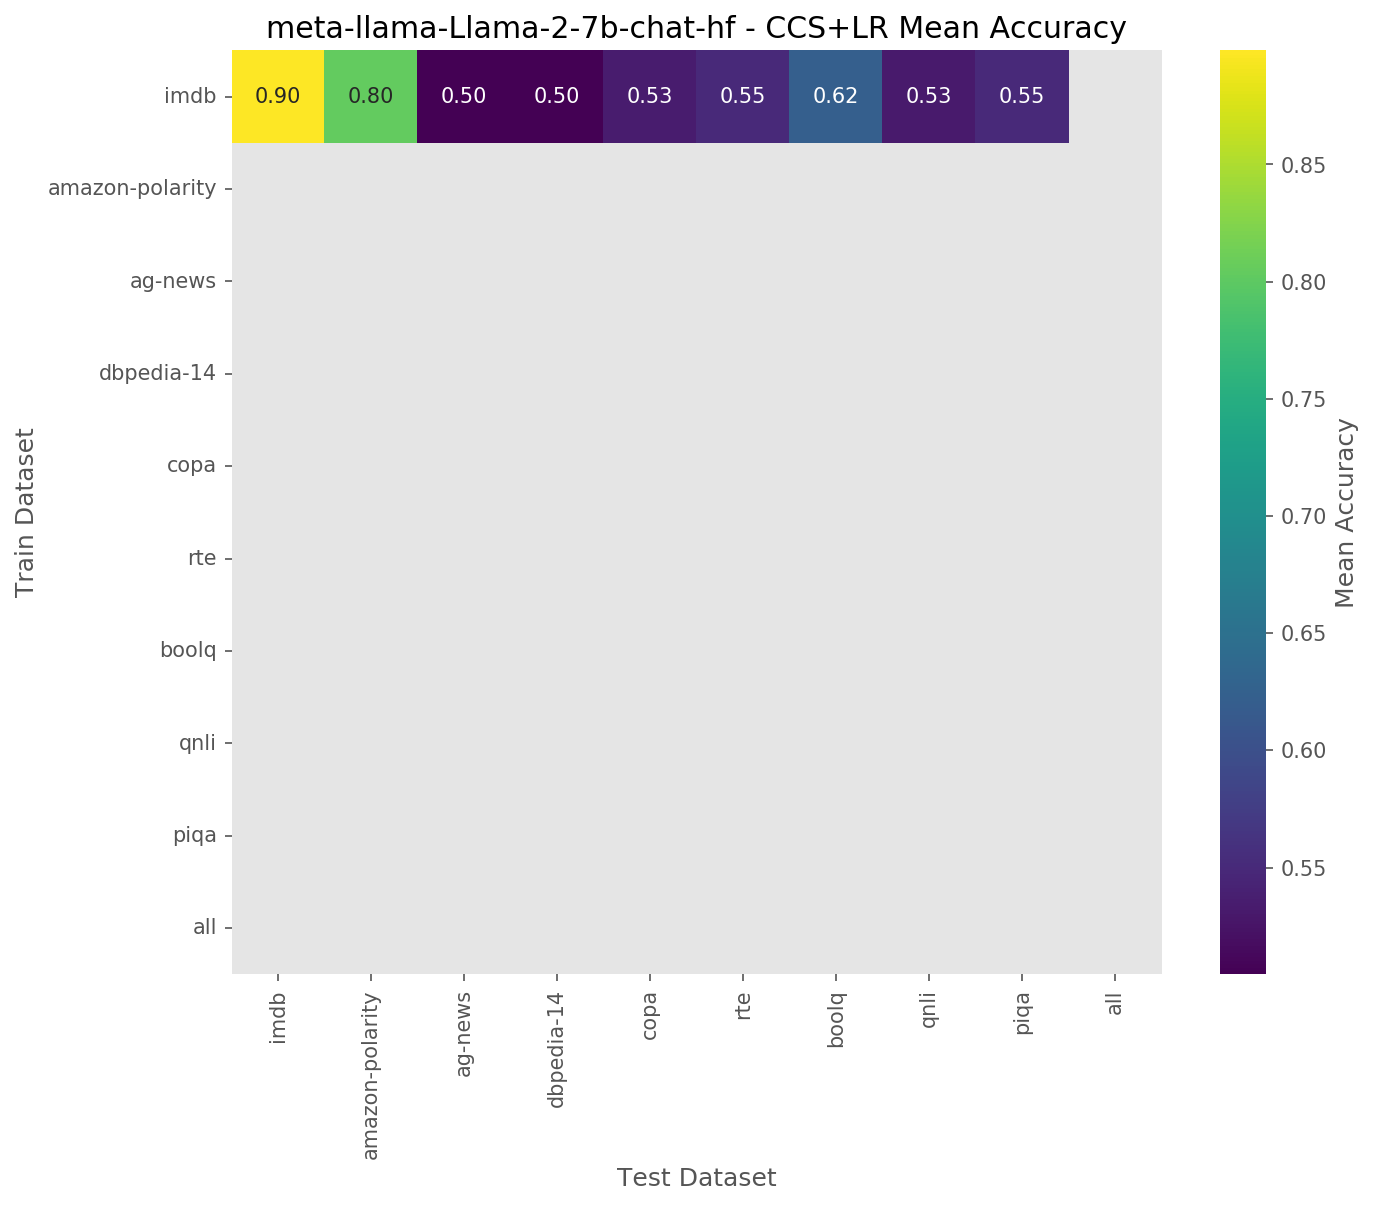

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-2-n_epochs=1000


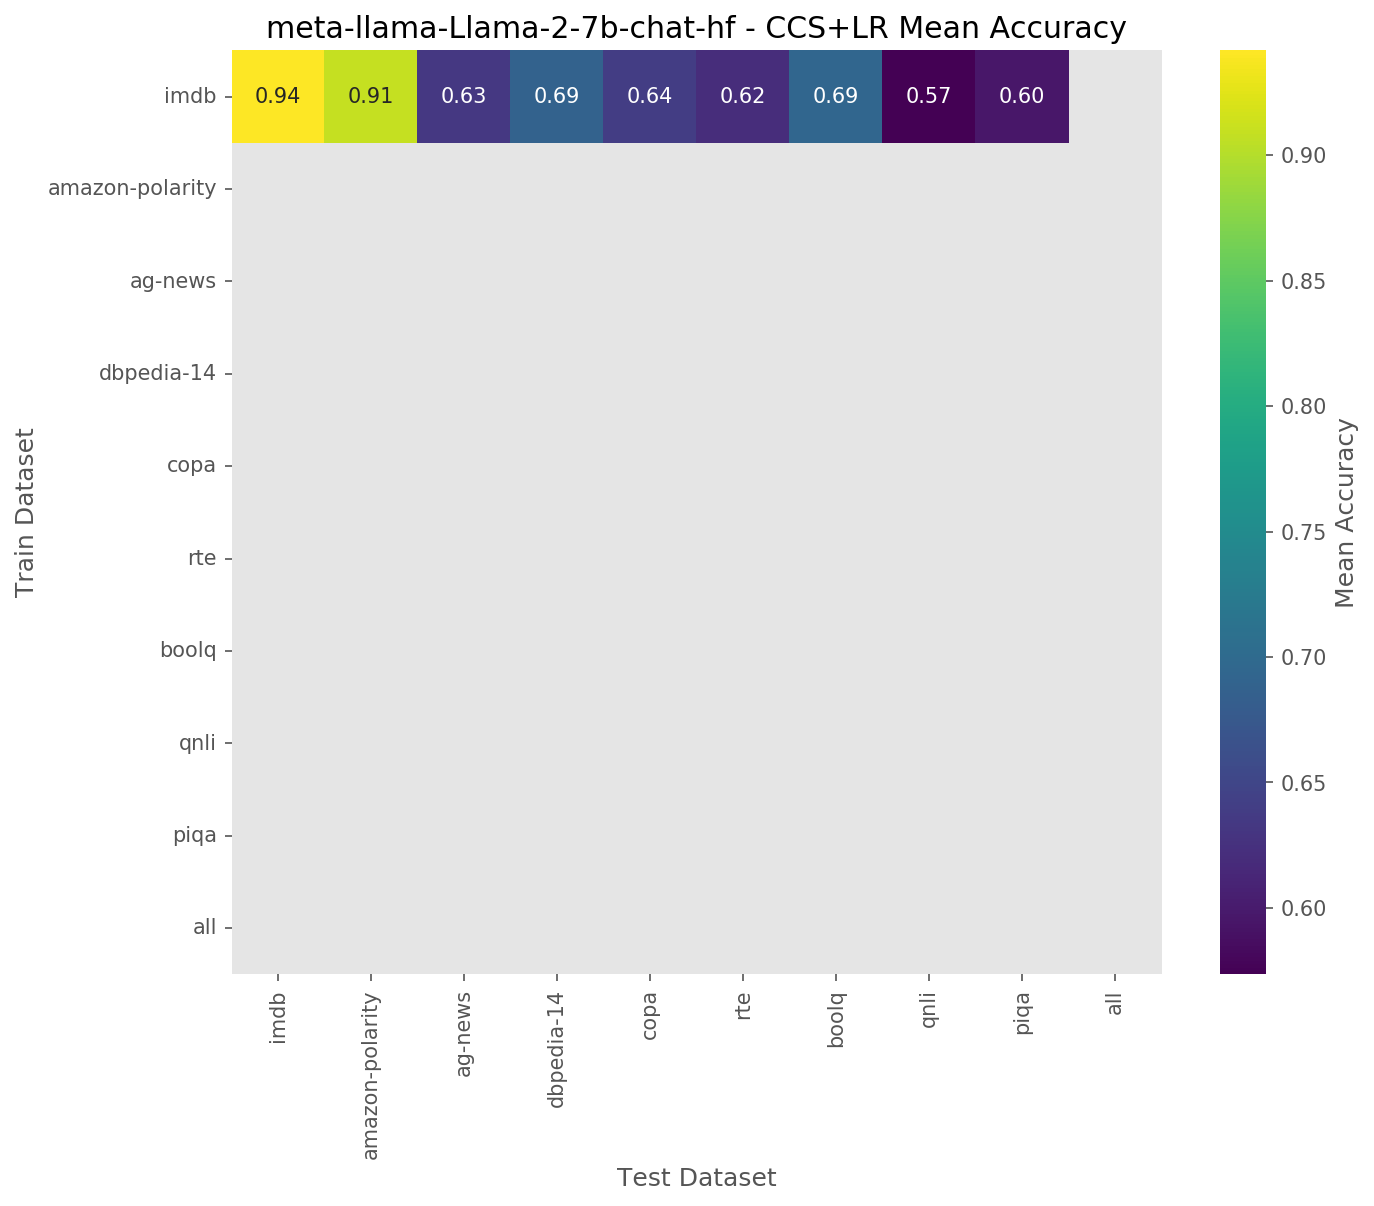

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-4-n_epochs=1000


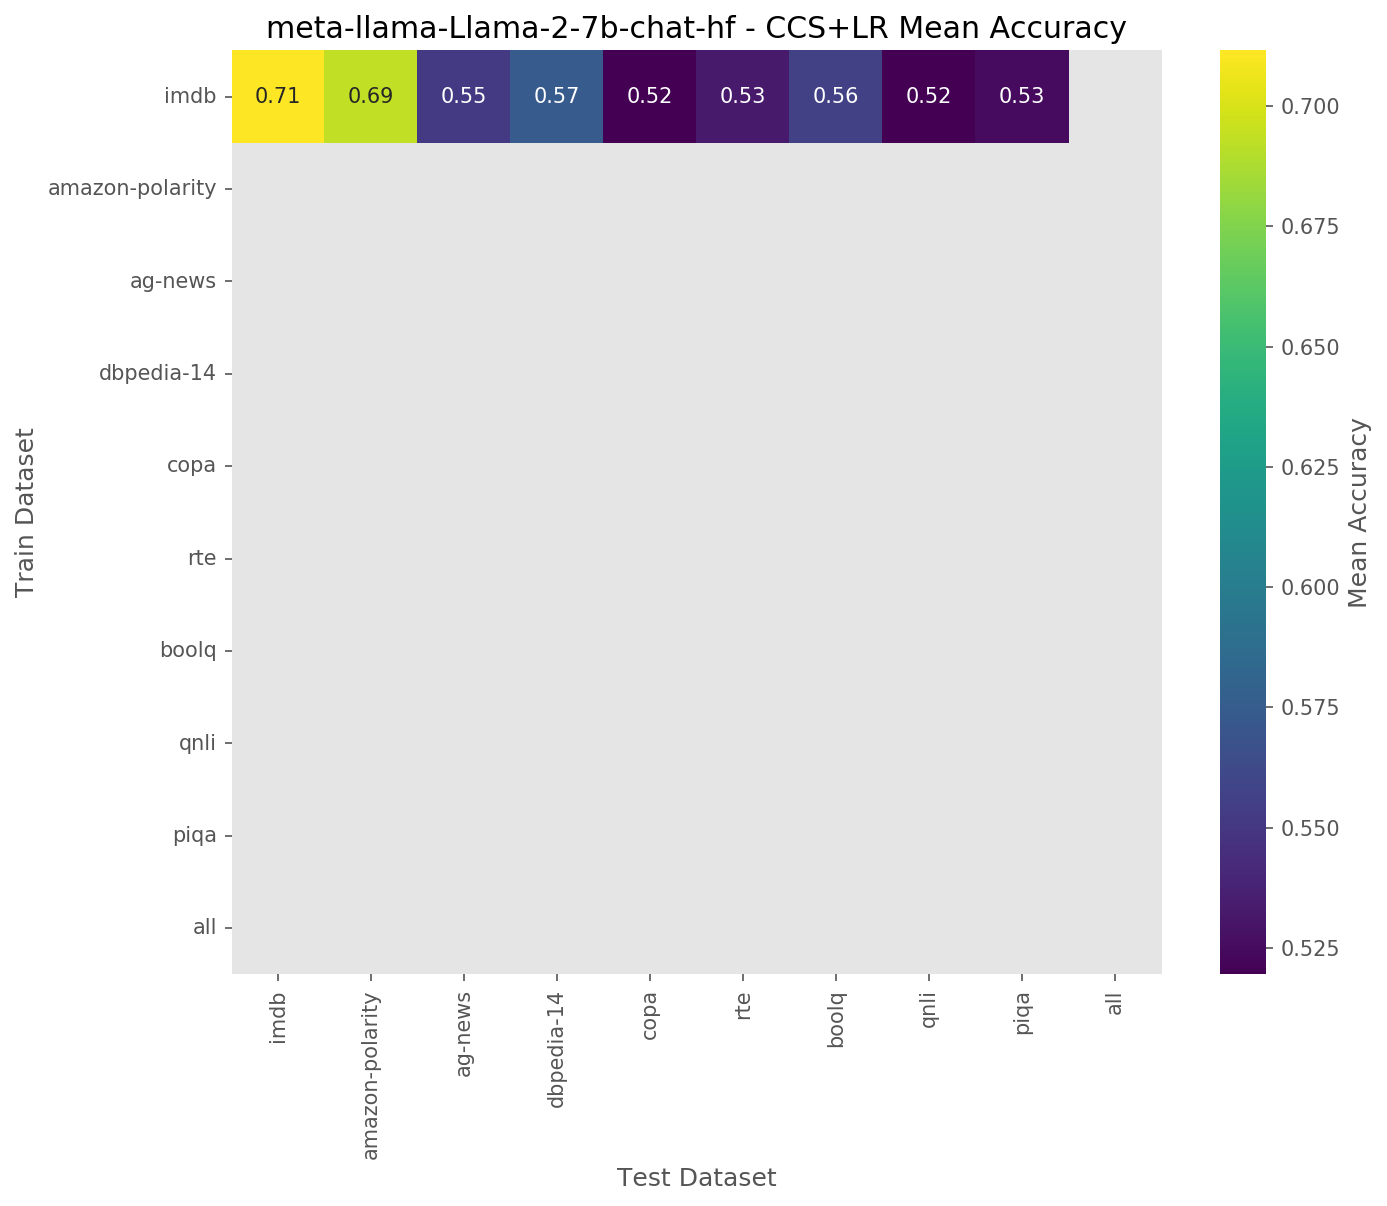

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000


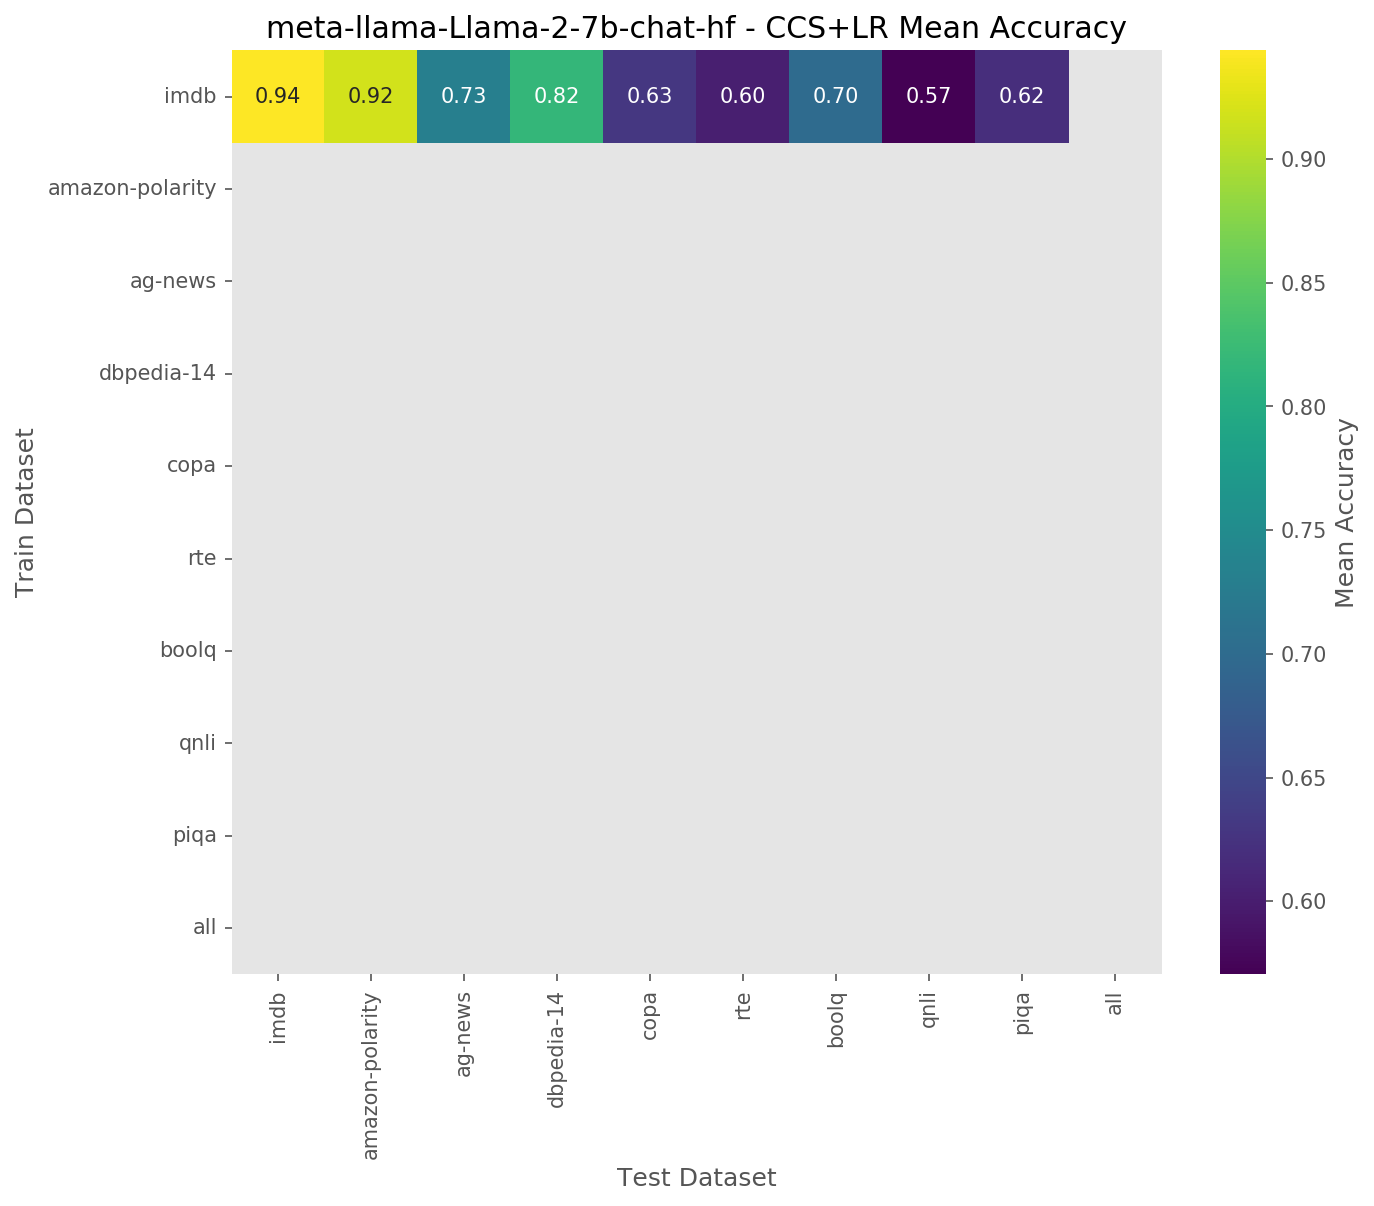

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-3-n_epochs=1000


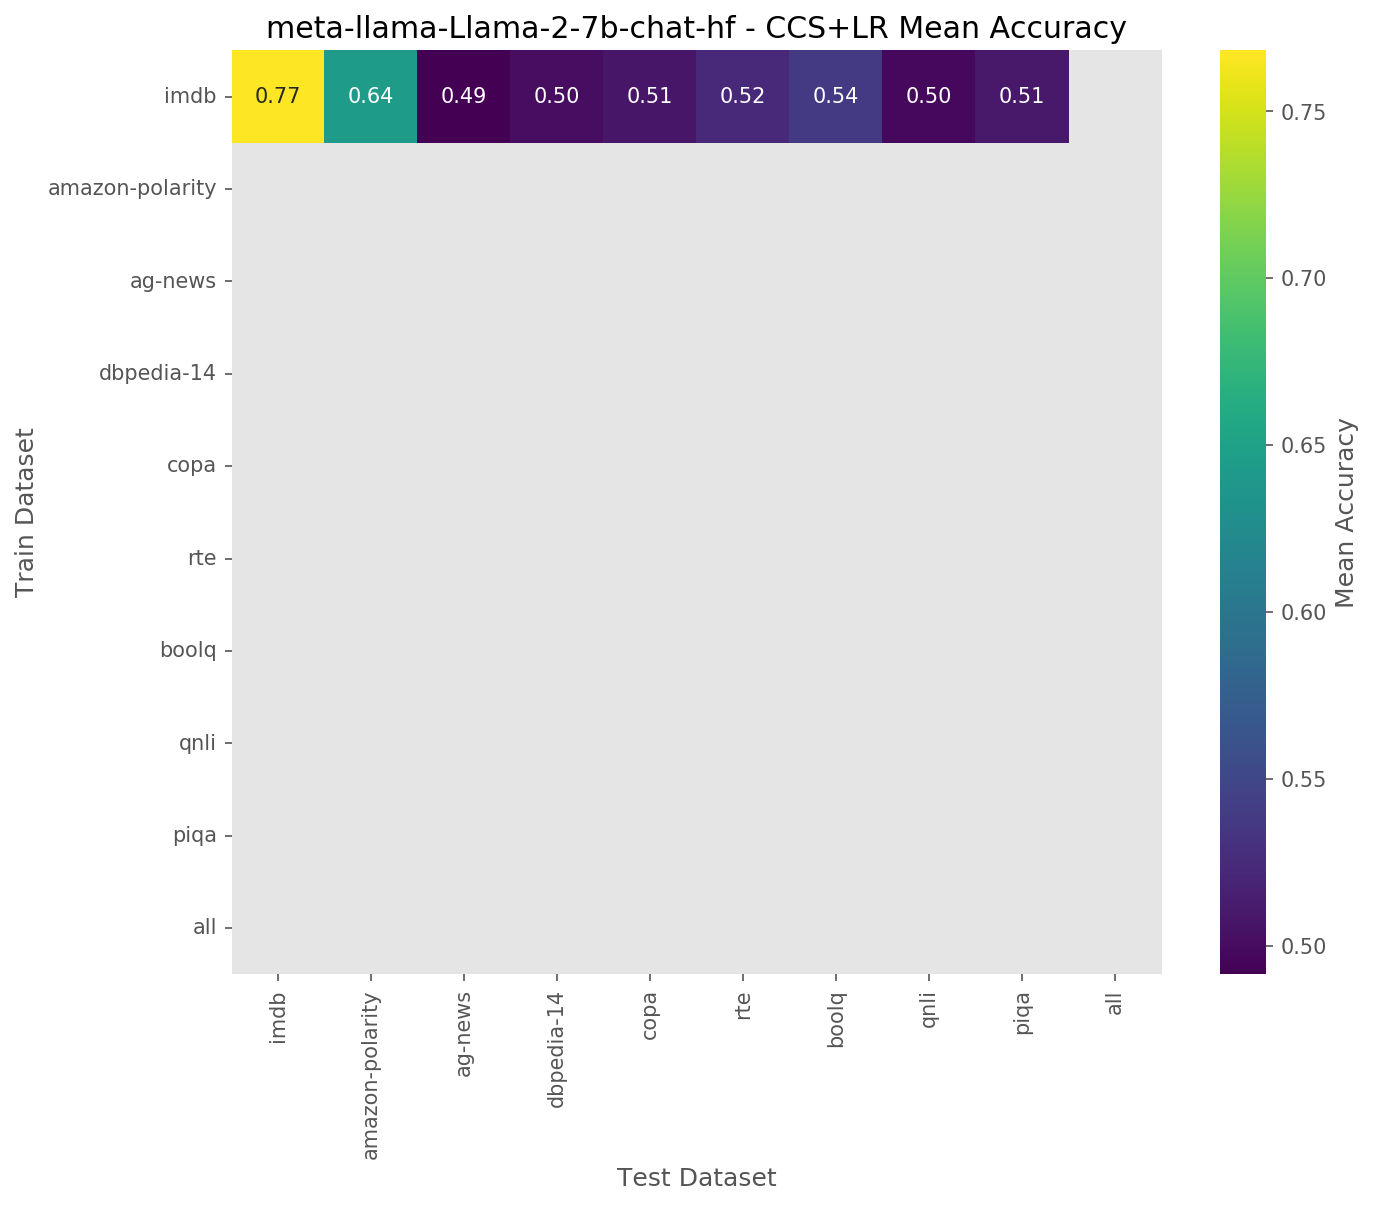

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-2-n_epochs=1000


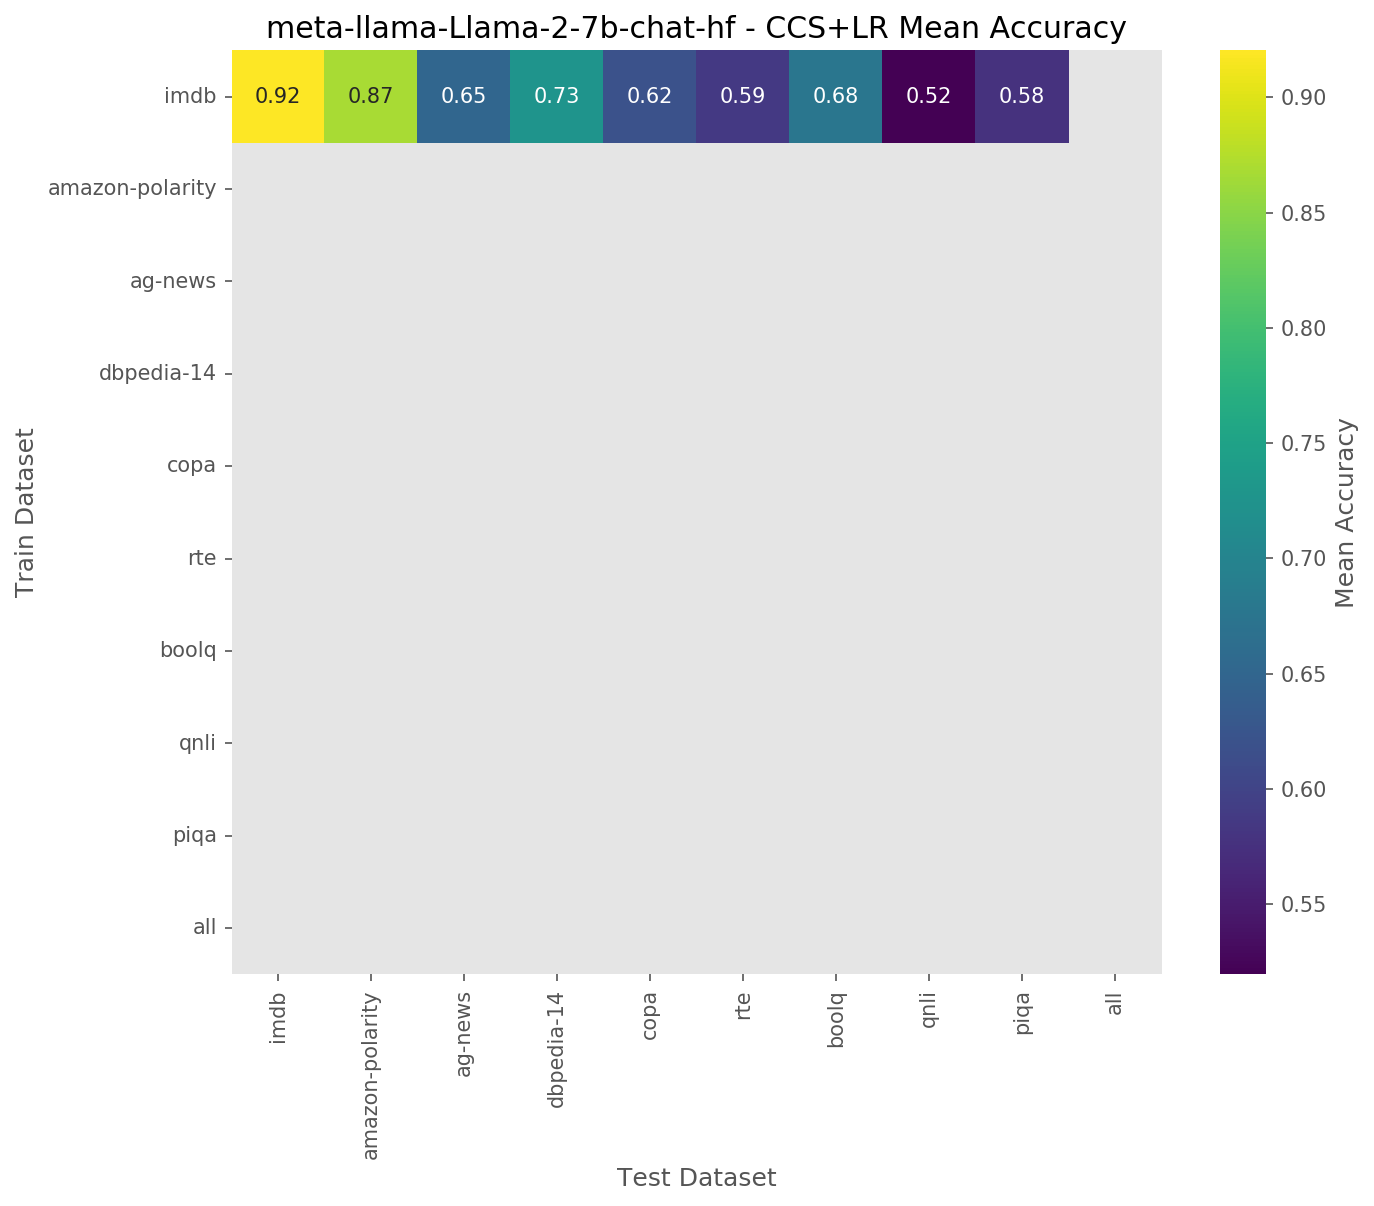

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-4-n_epochs=1000


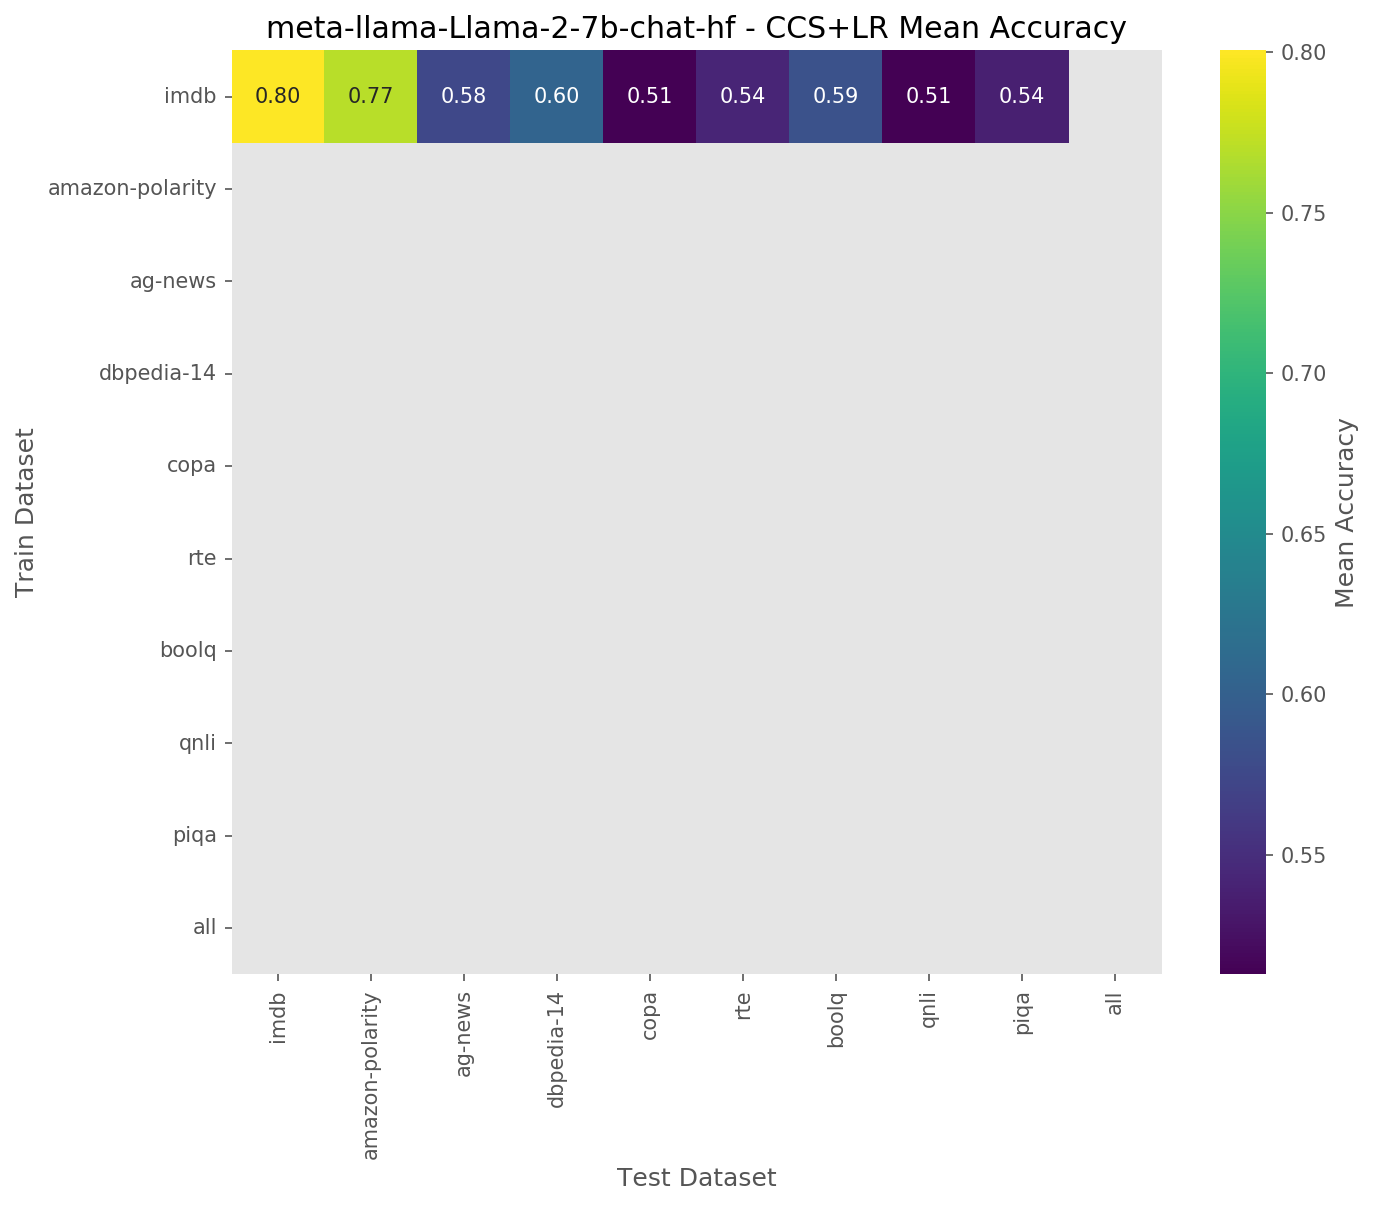

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-3-n_epochs=1000


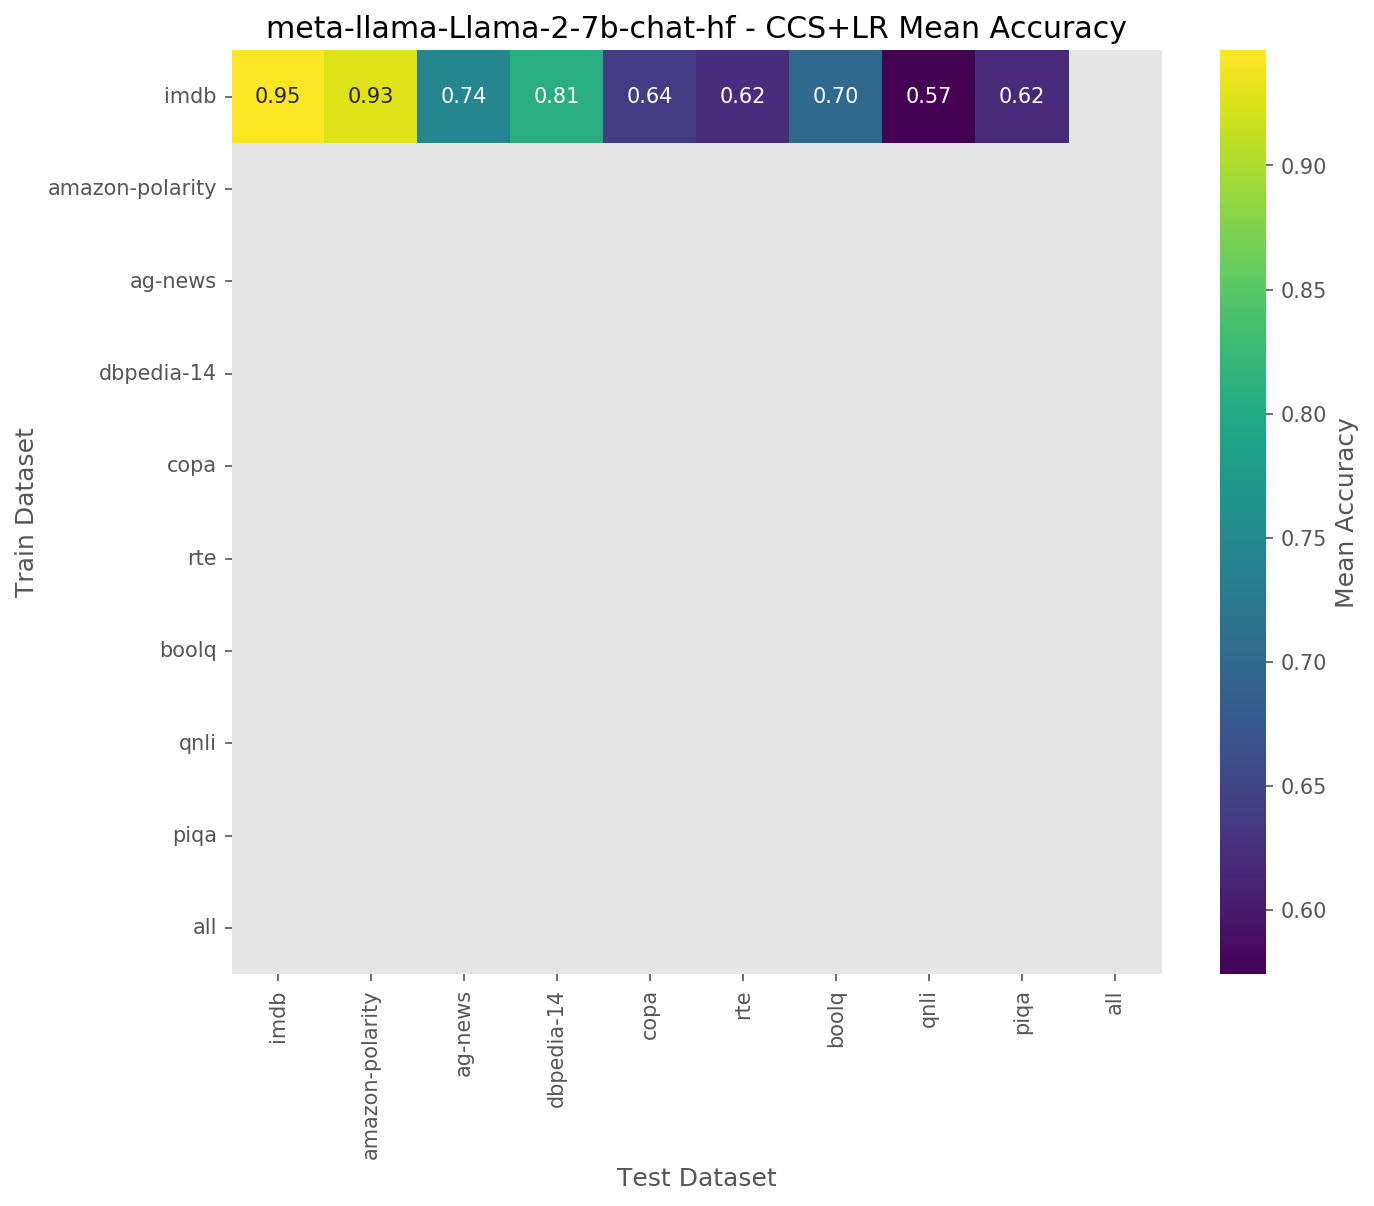

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-4-n_epochs=1000


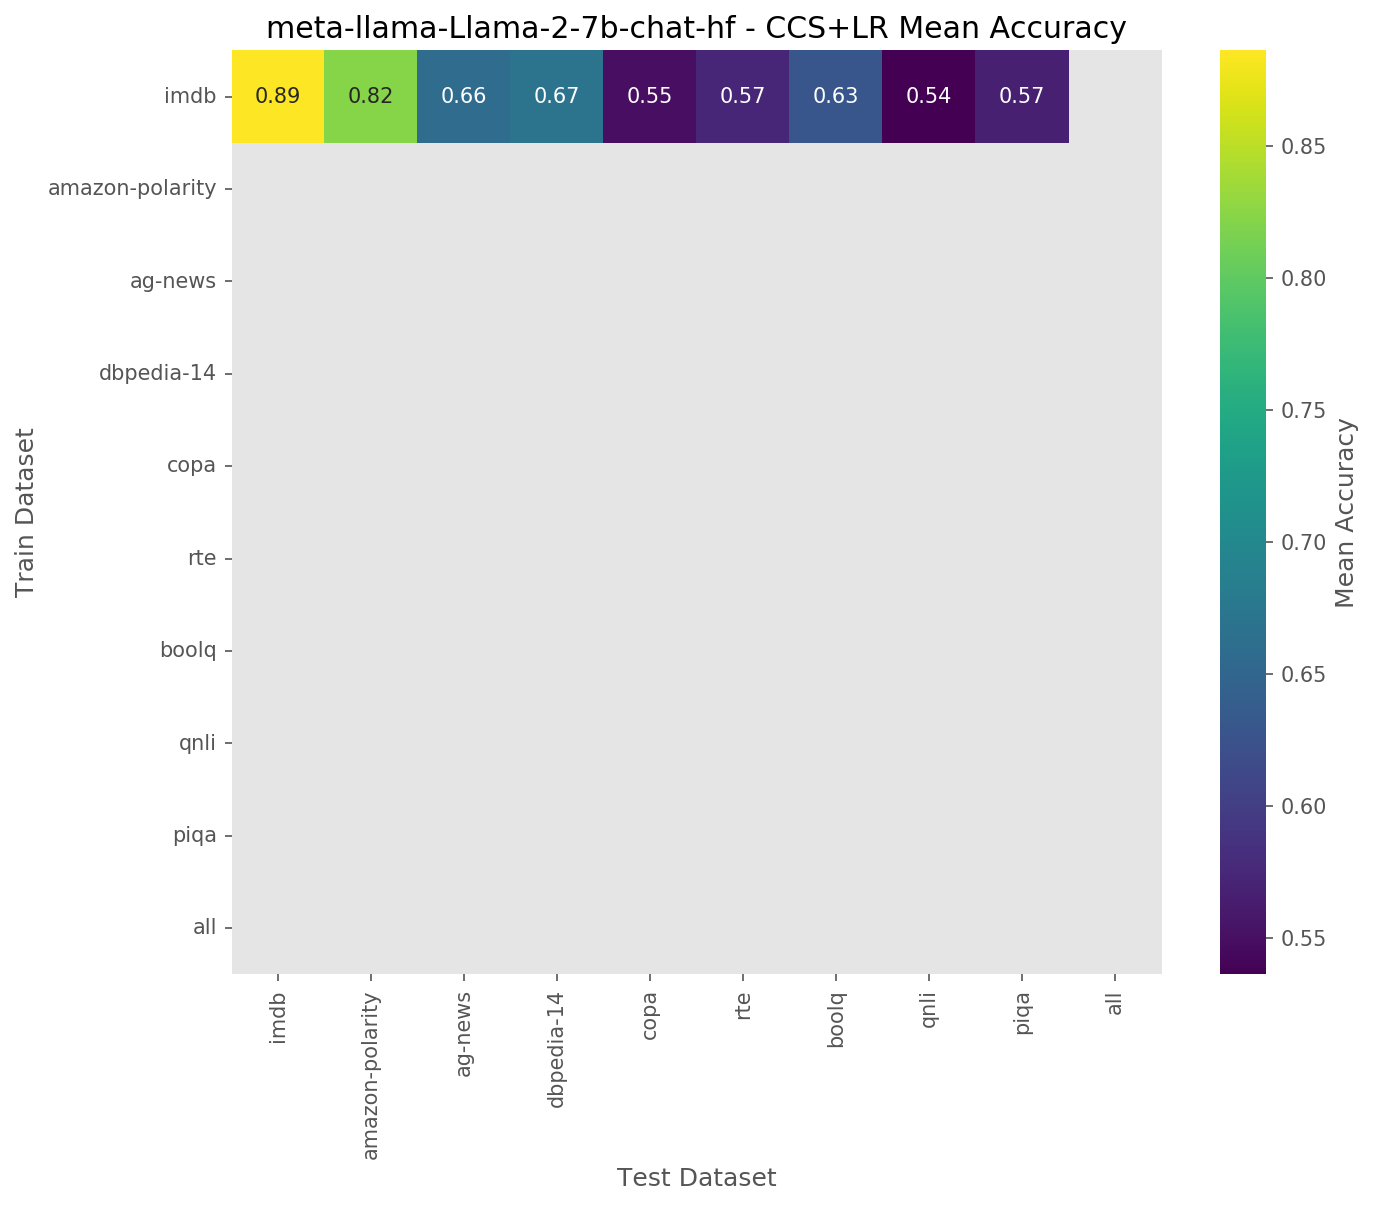

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-3-n_epochs=1000


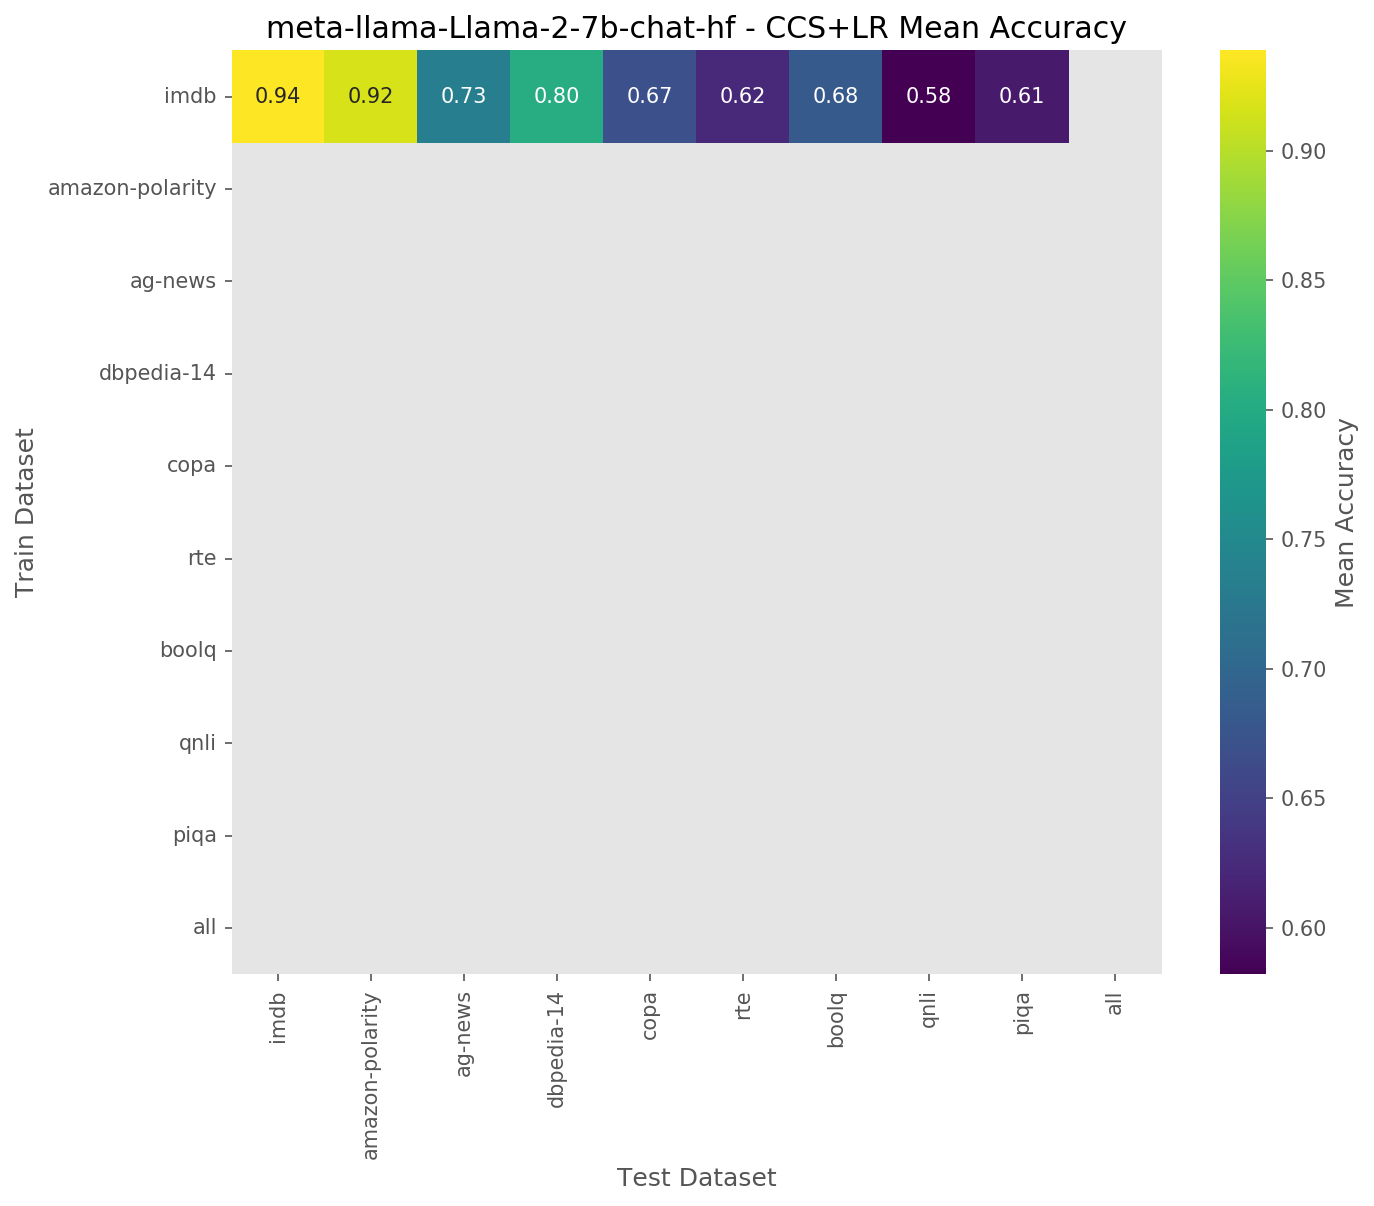

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-2-n_epochs=1000


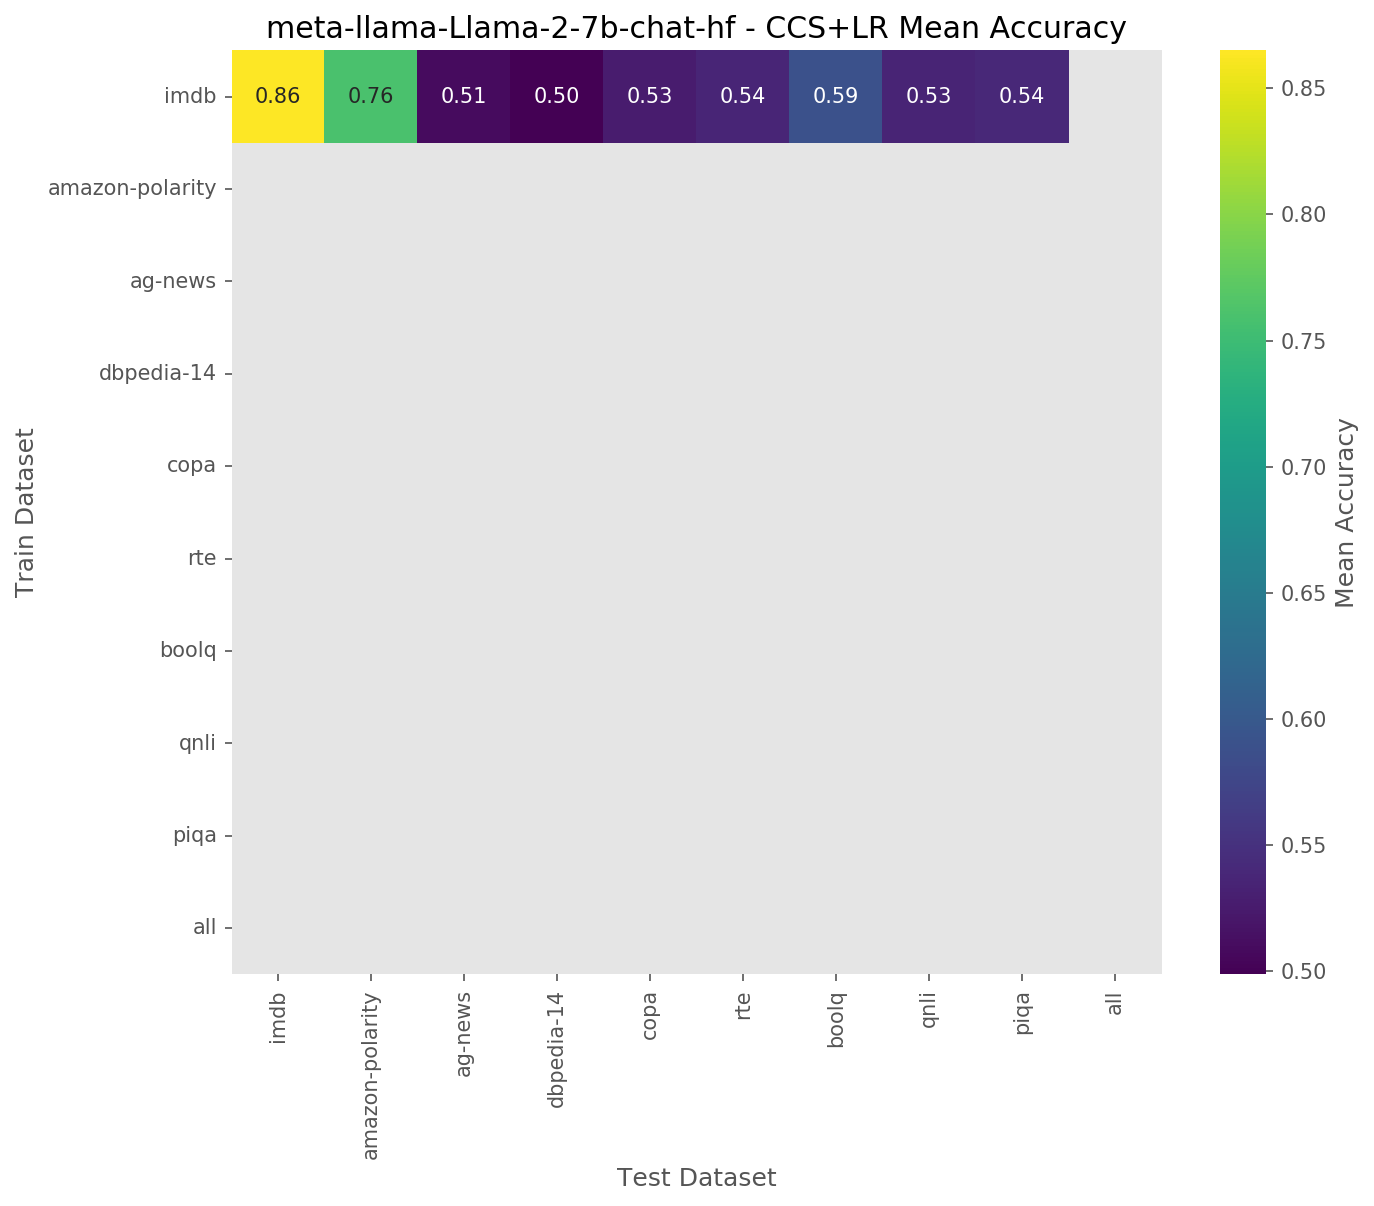

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-4-n_epochs=1000


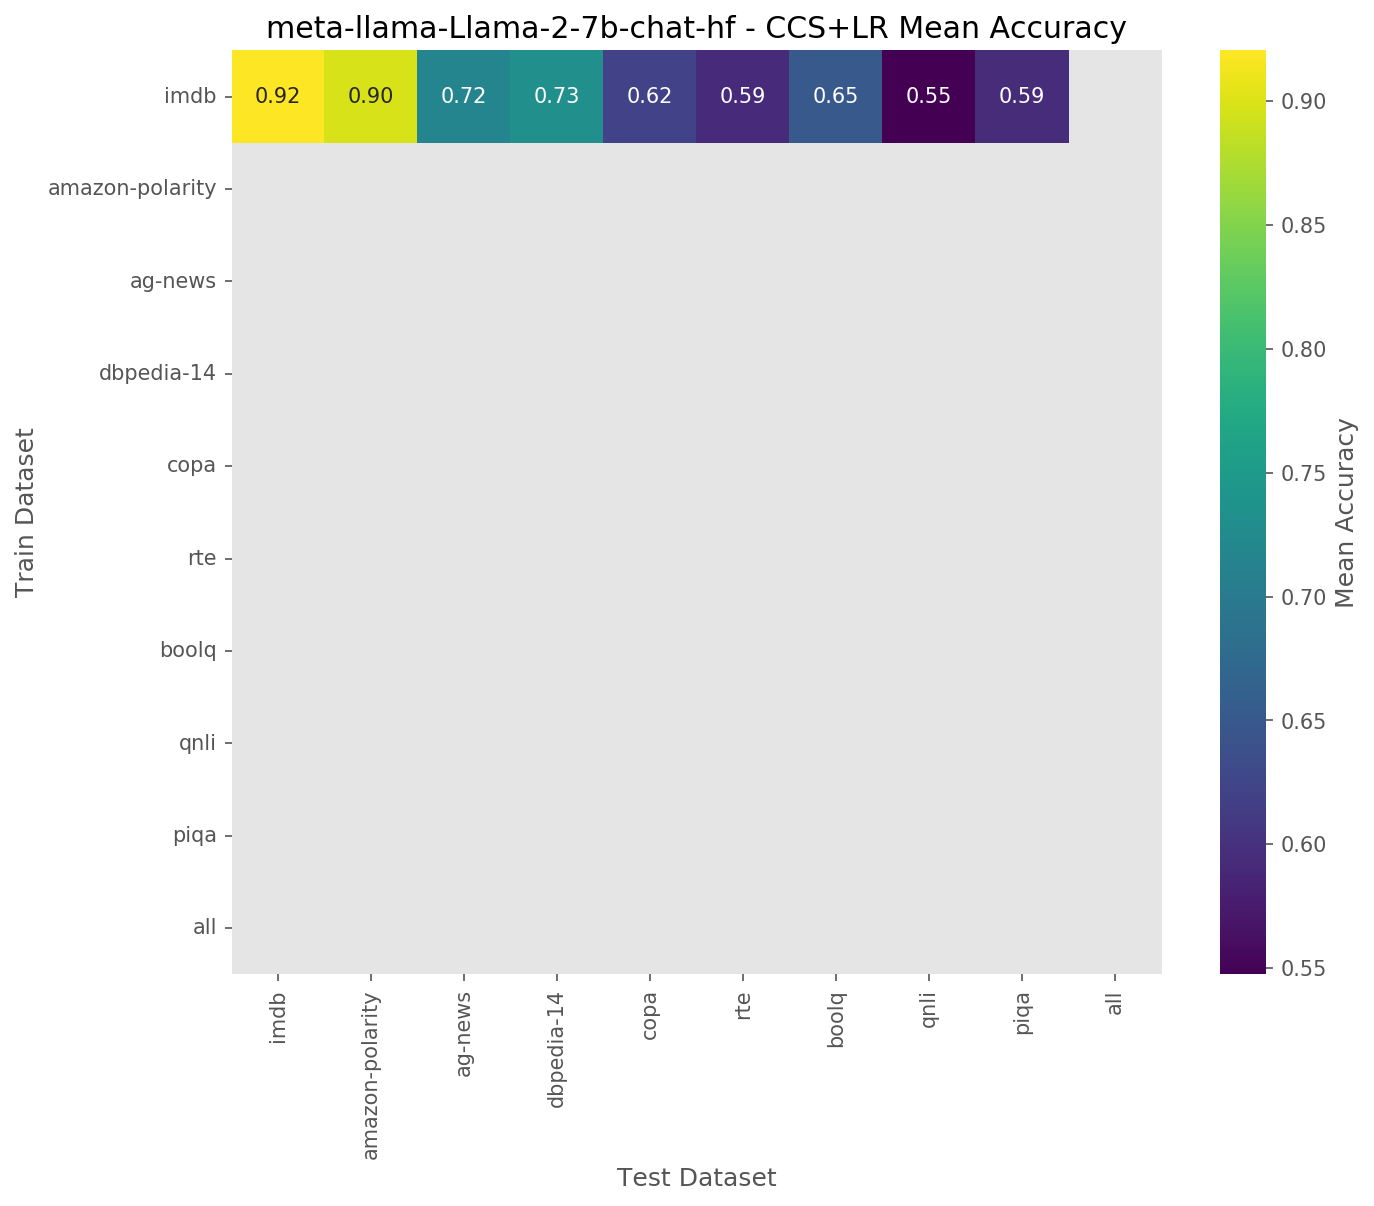

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-2-n_epochs=1000


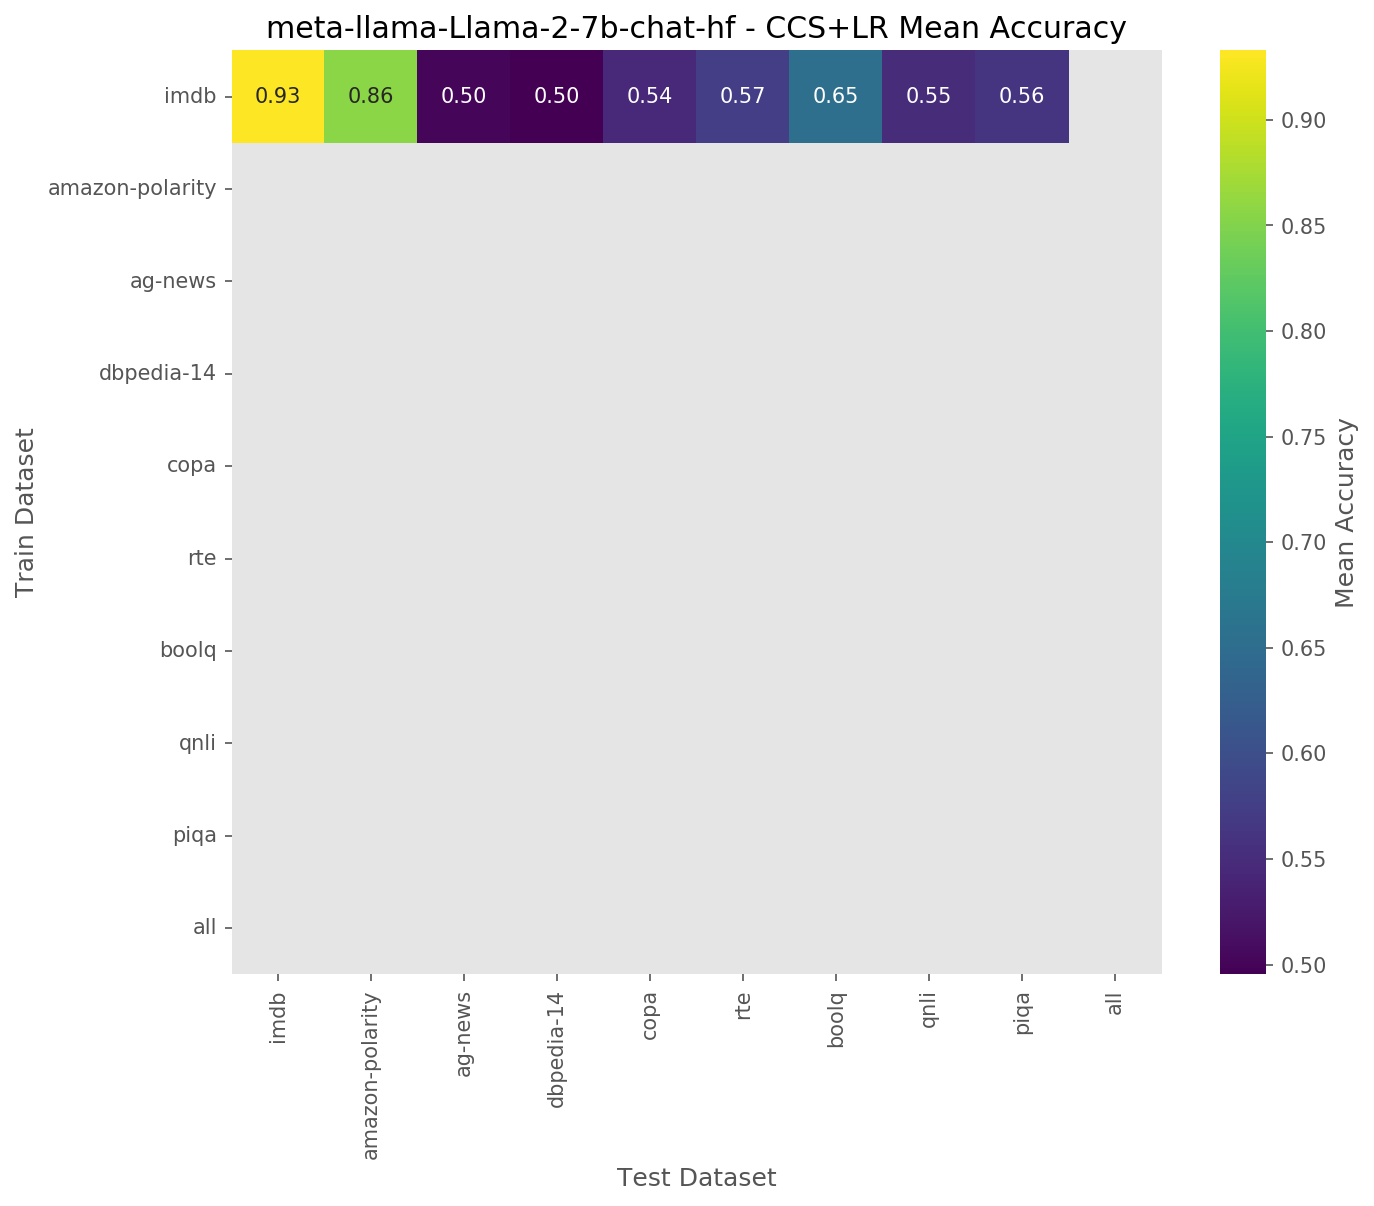

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-4-n_epochs=1000


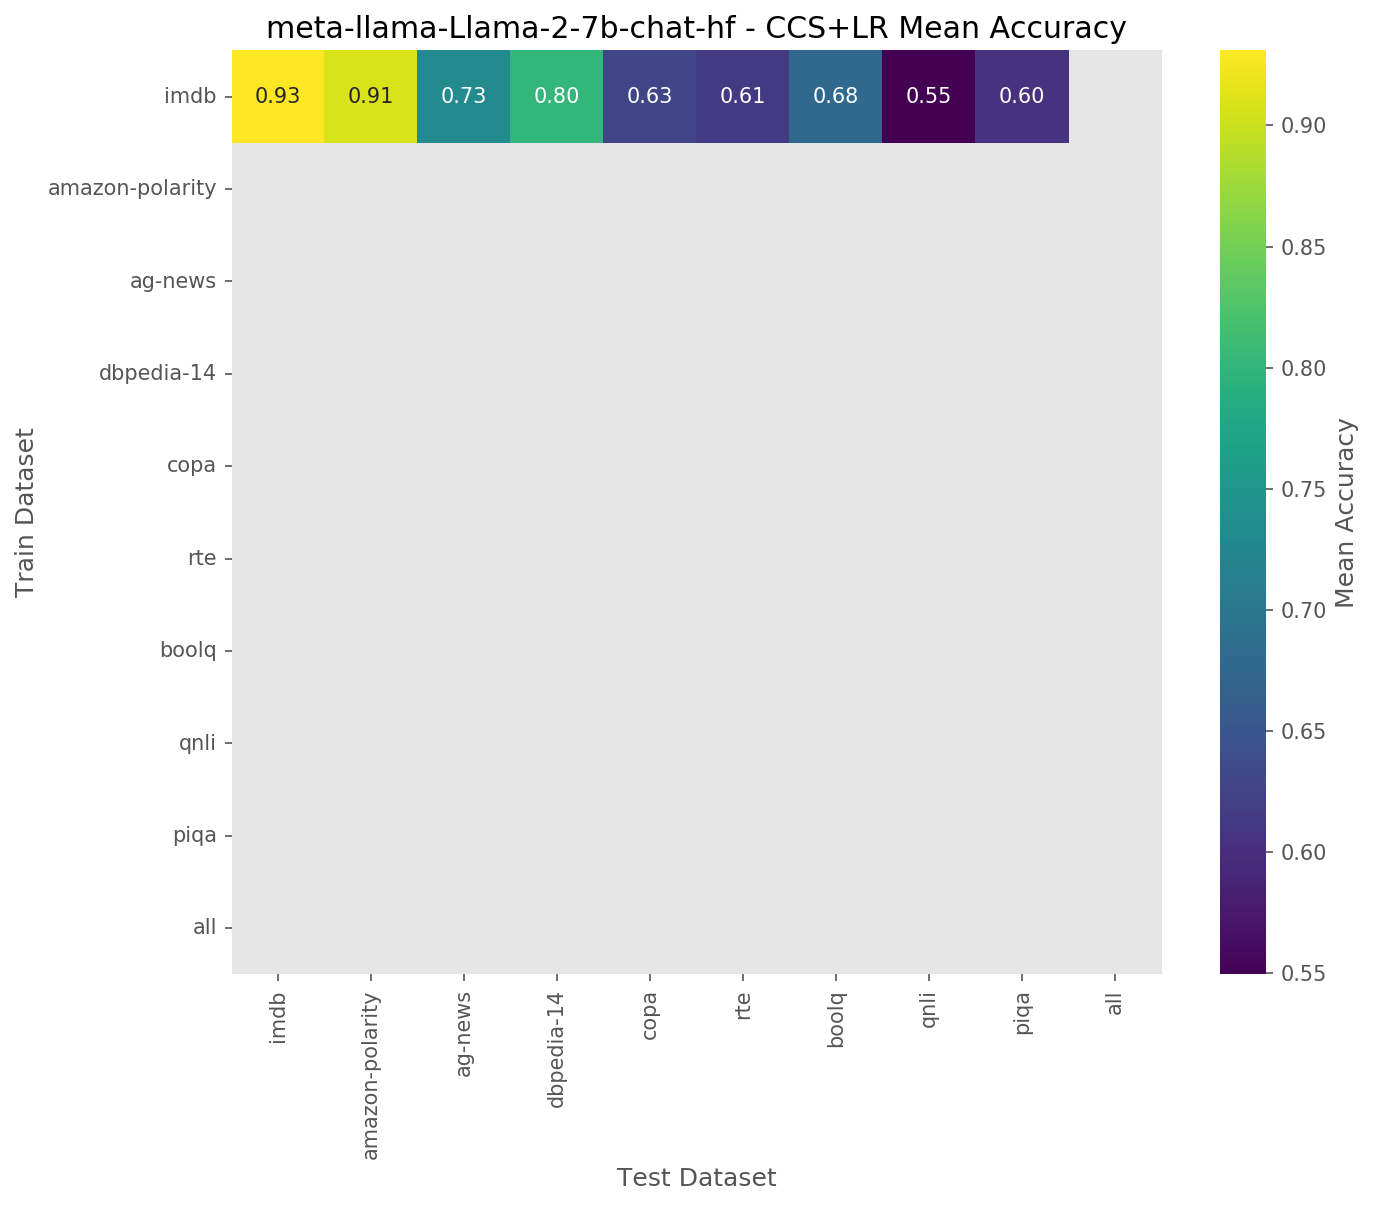

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-3-n_epochs=1000


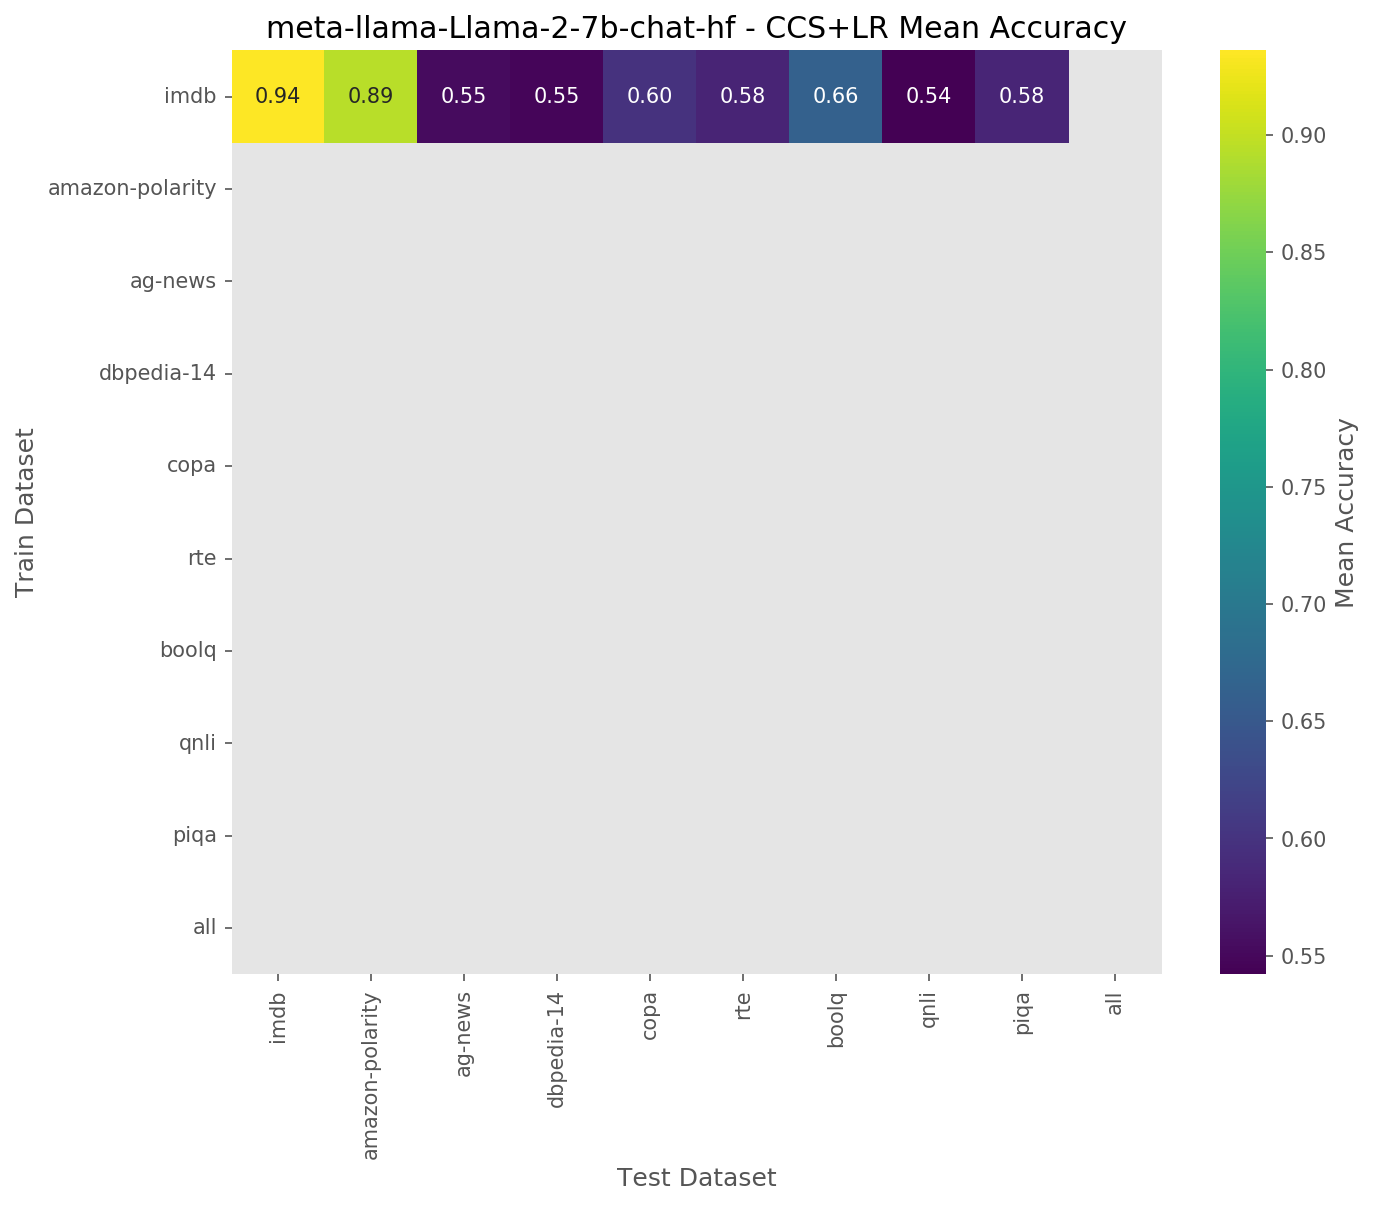

In [145]:
for exp_name, df in experiment_dfs.items():
    print(exp_name)
    plot_heatmap(df, "accuracy", std_annot=False)

# Accuracy violin plots

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-3-n_epochs=1000


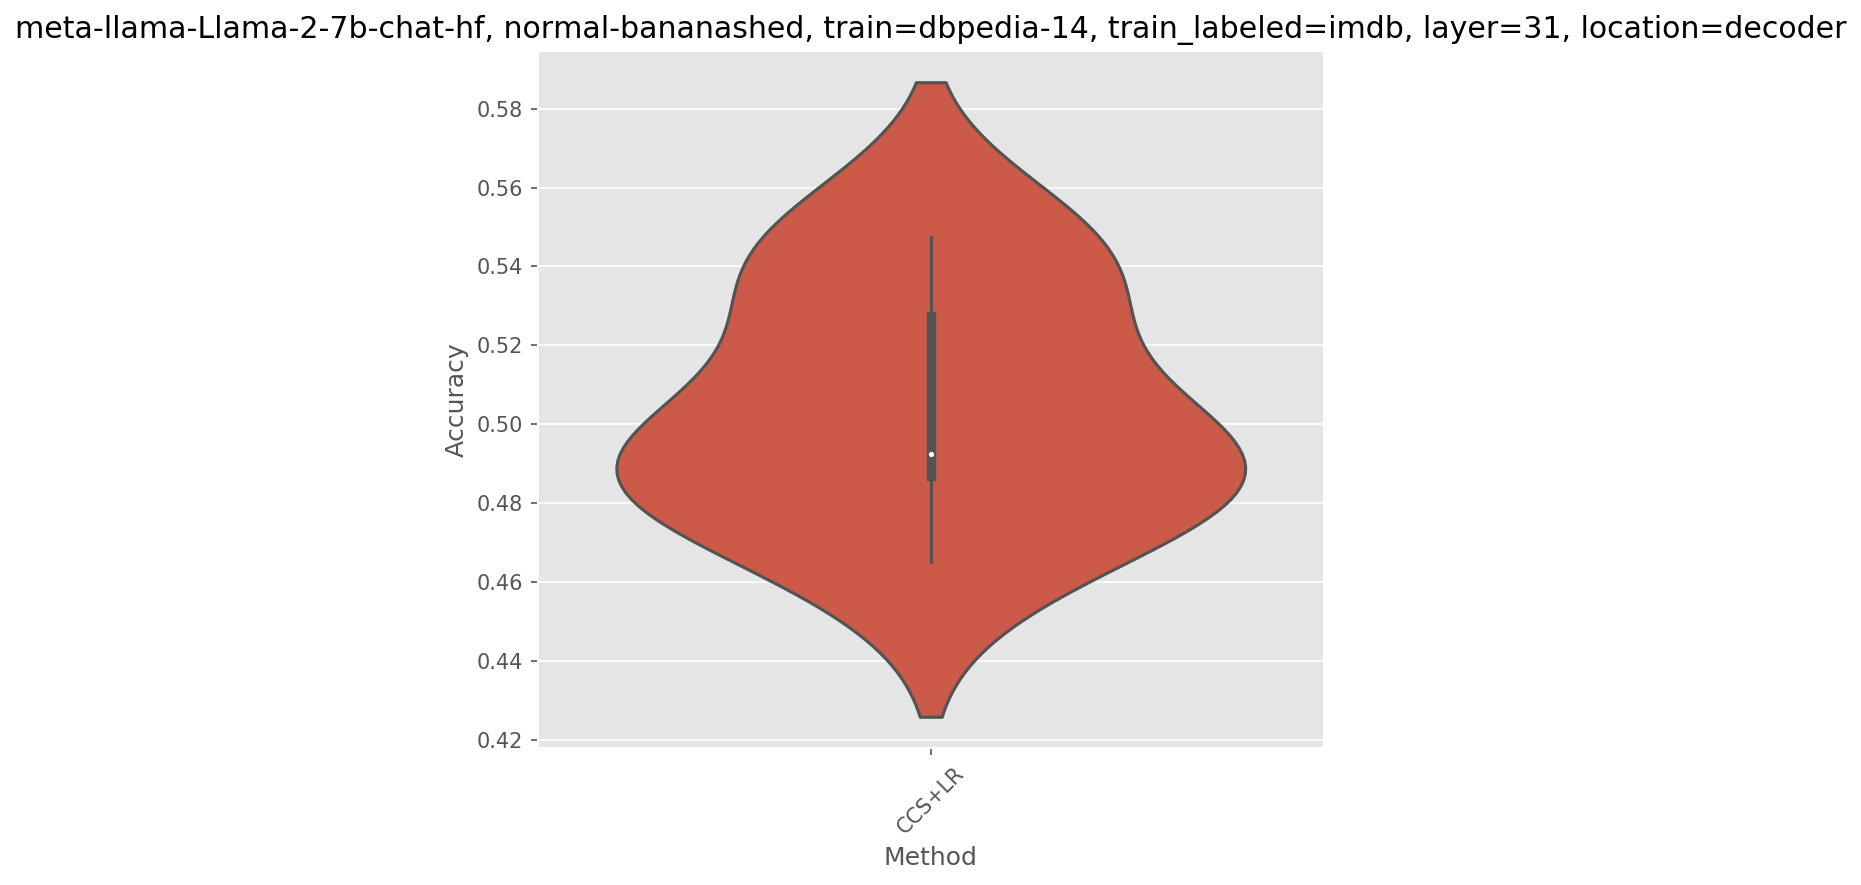

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-2-n_epochs=1000


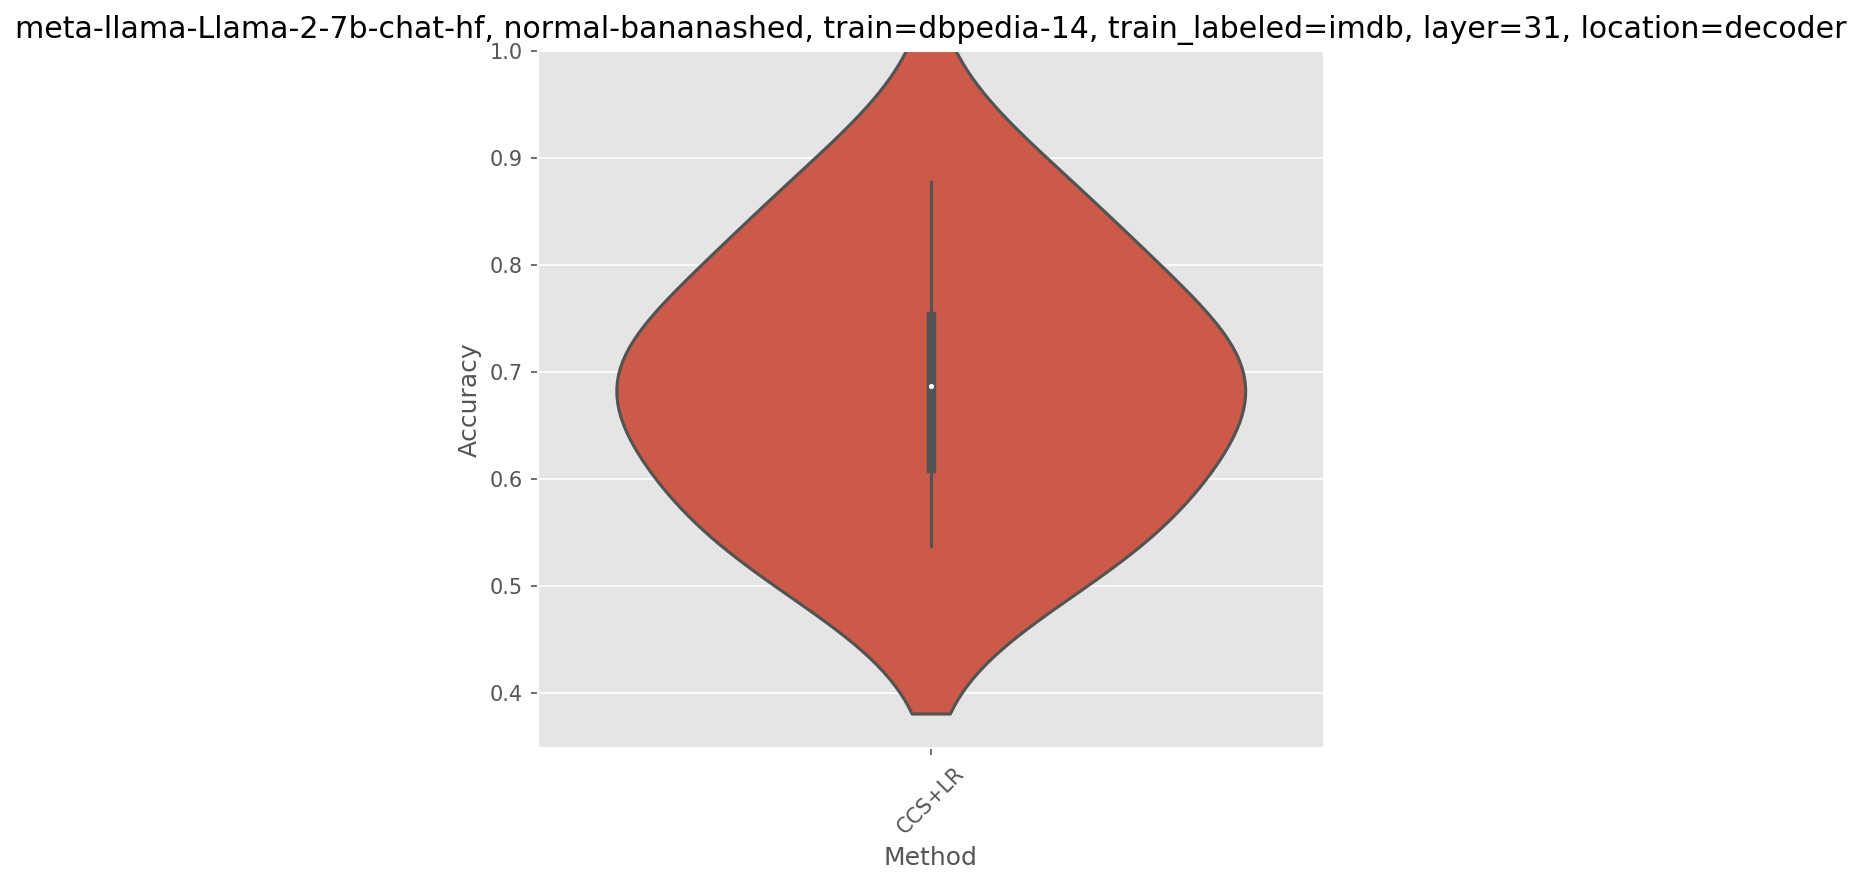

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-4-n_epochs=1000


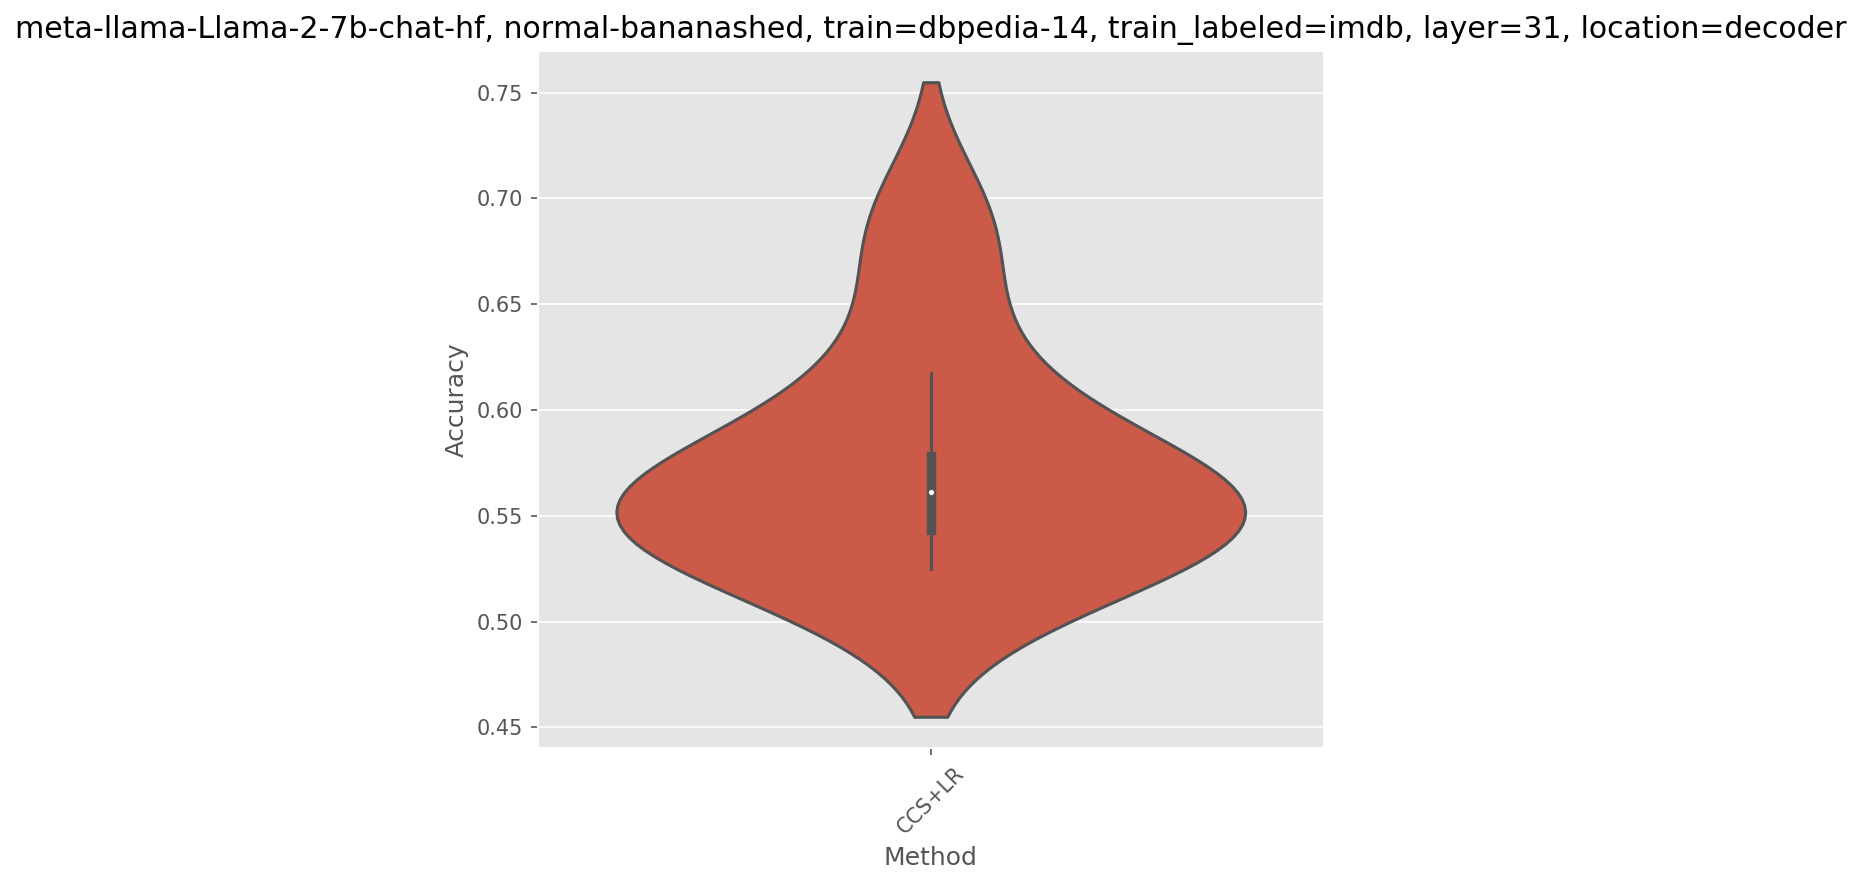

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000


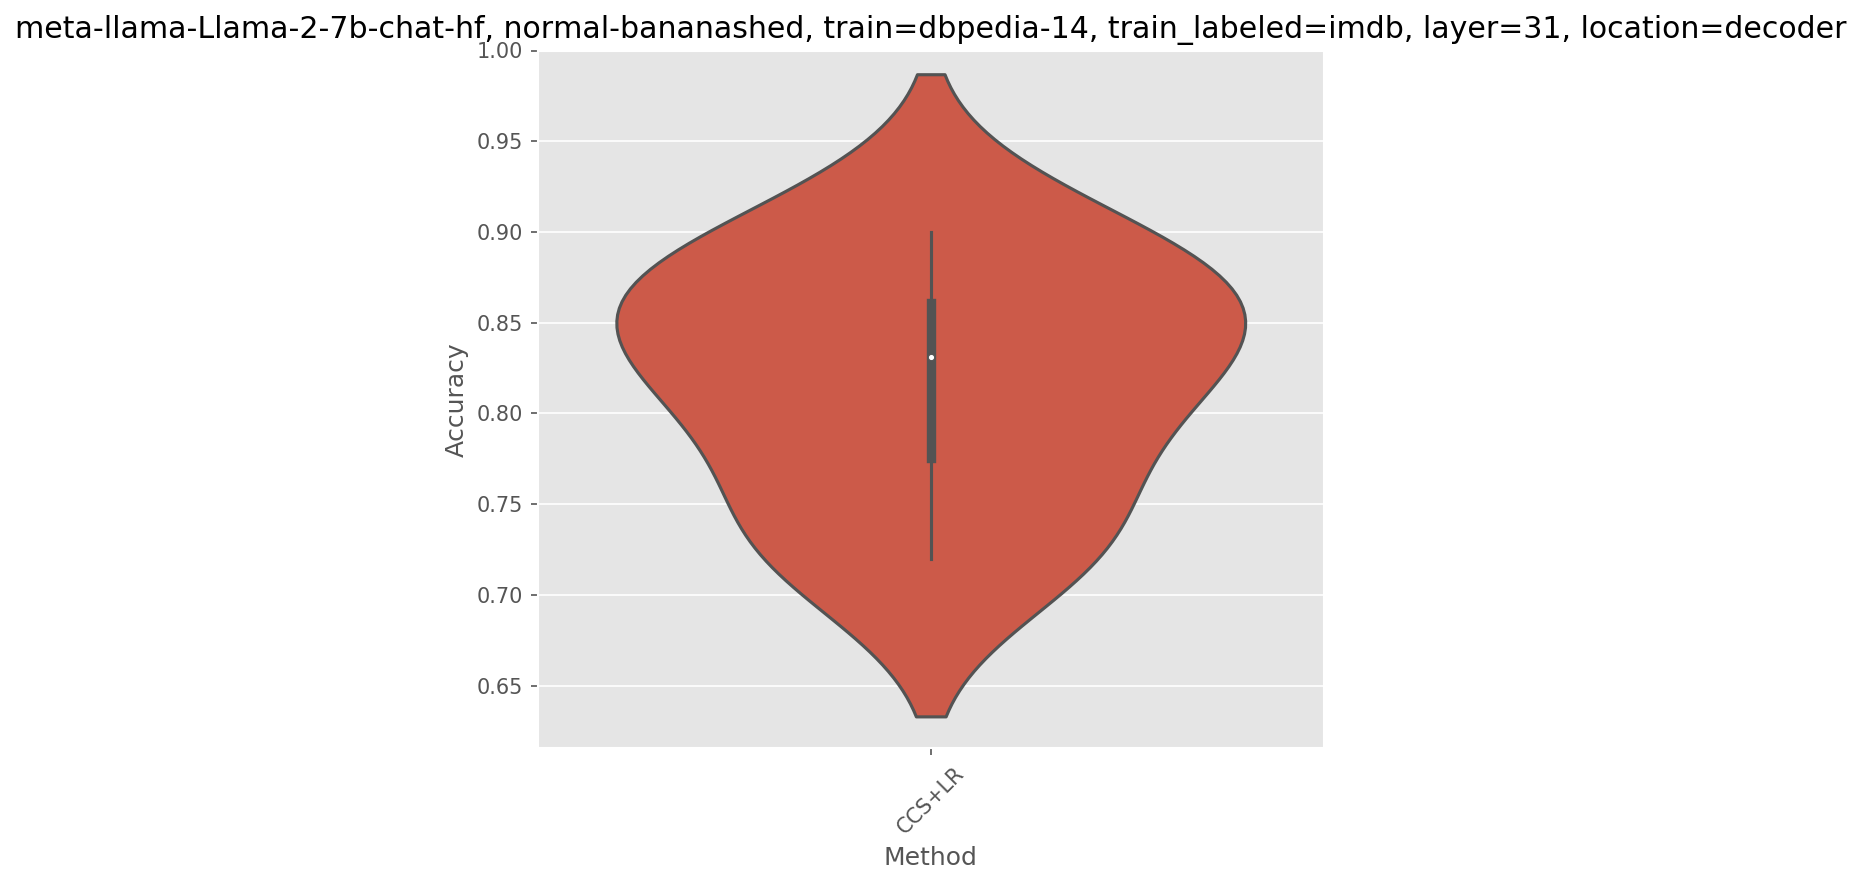

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-3-n_epochs=1000


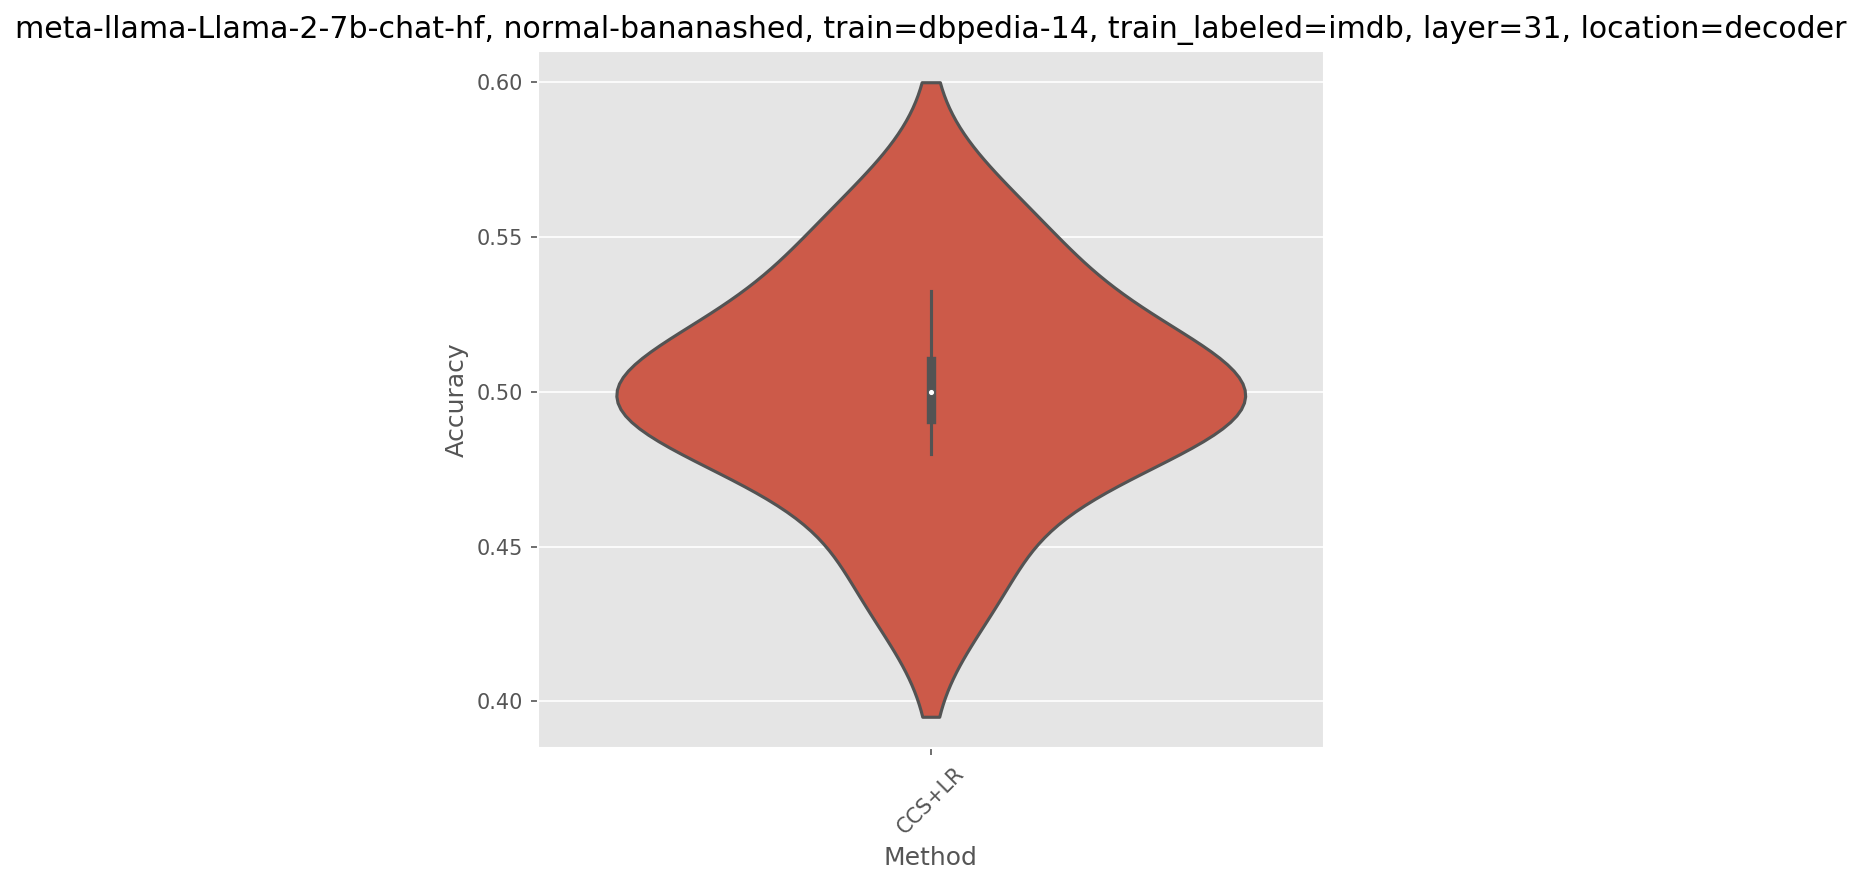

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-2-n_epochs=1000


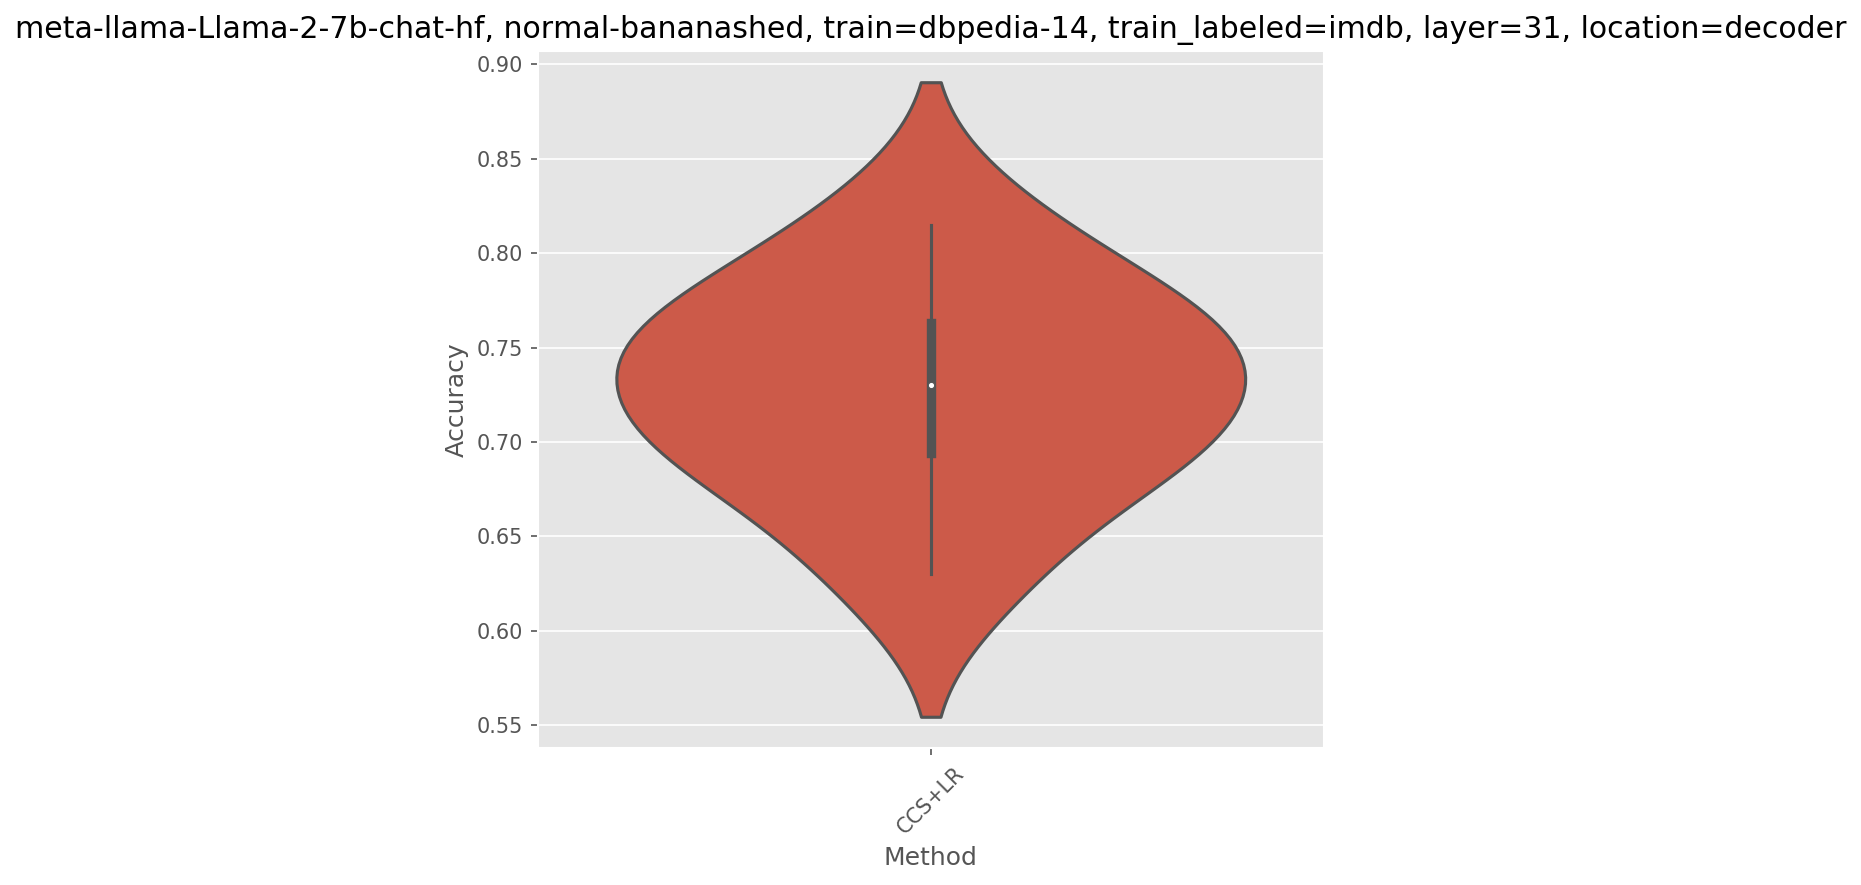

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-4-n_epochs=1000


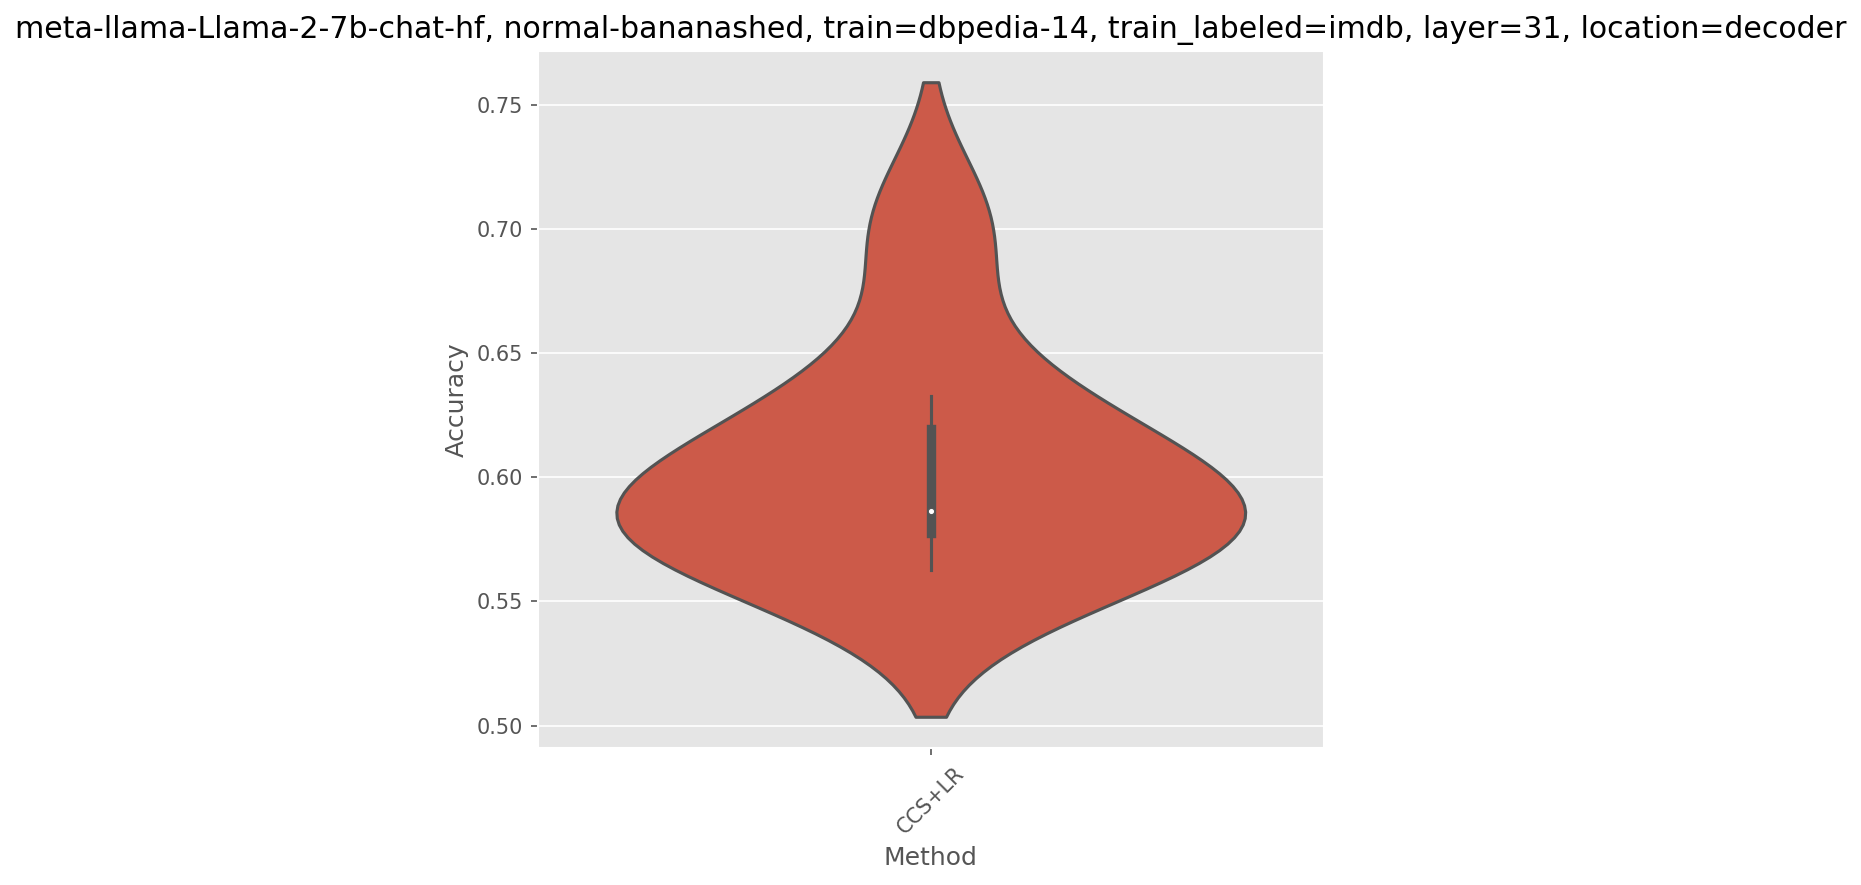

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-3-n_epochs=1000


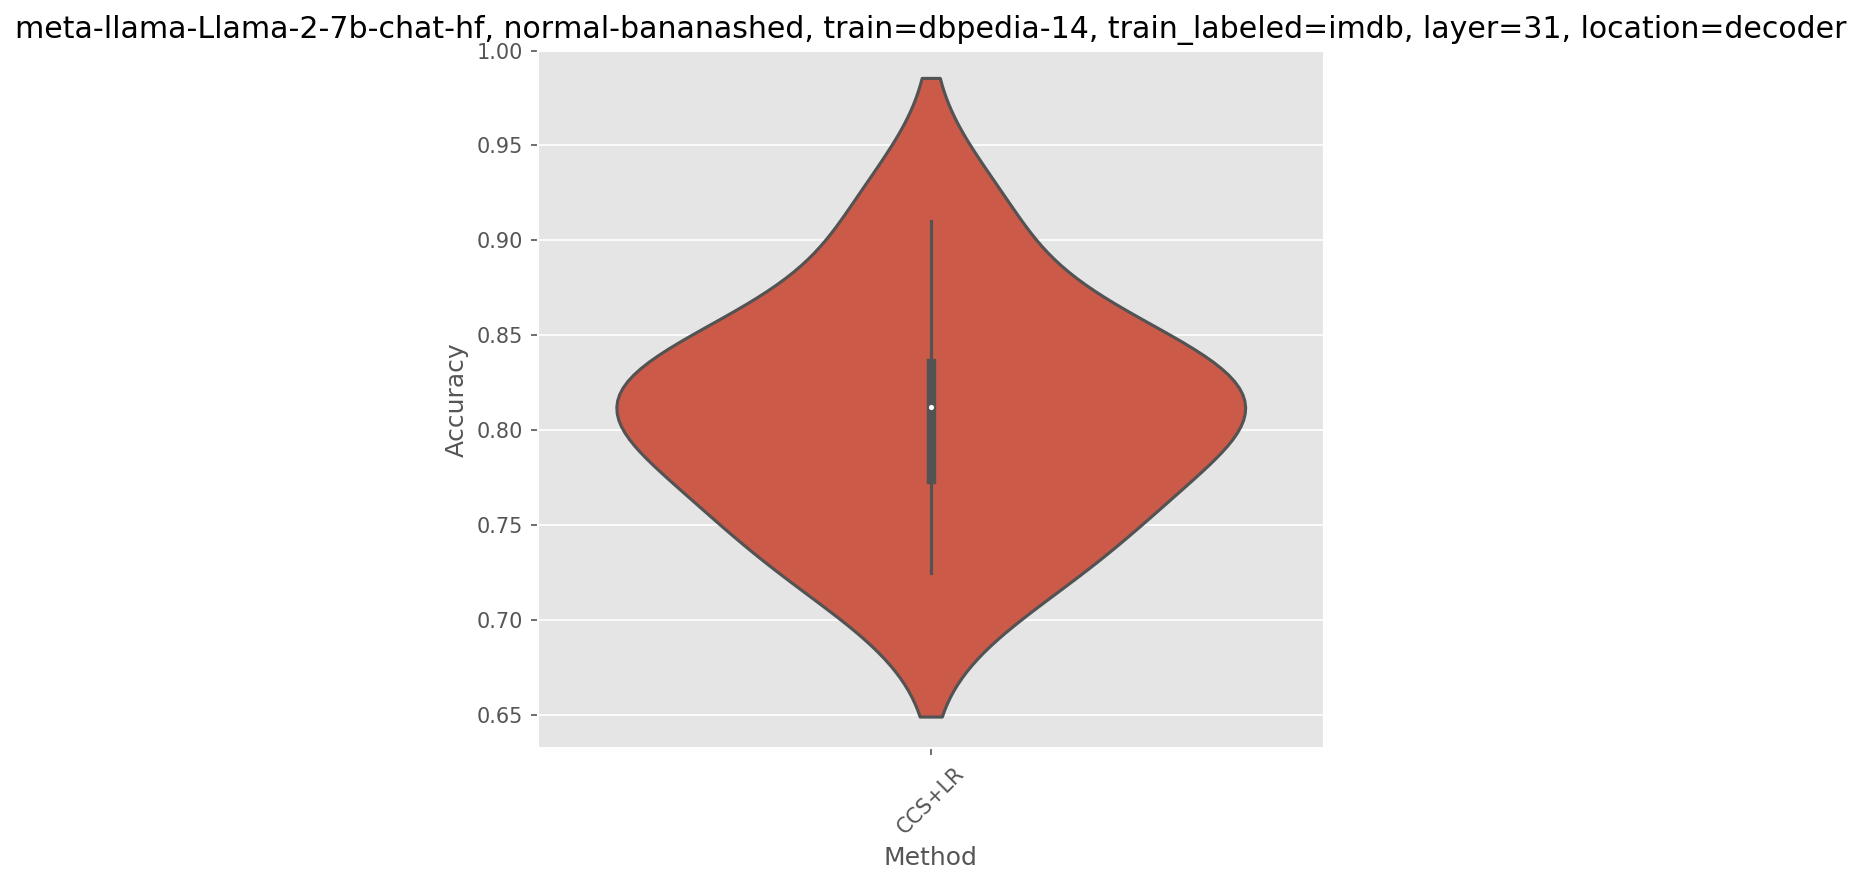

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-4-n_epochs=1000


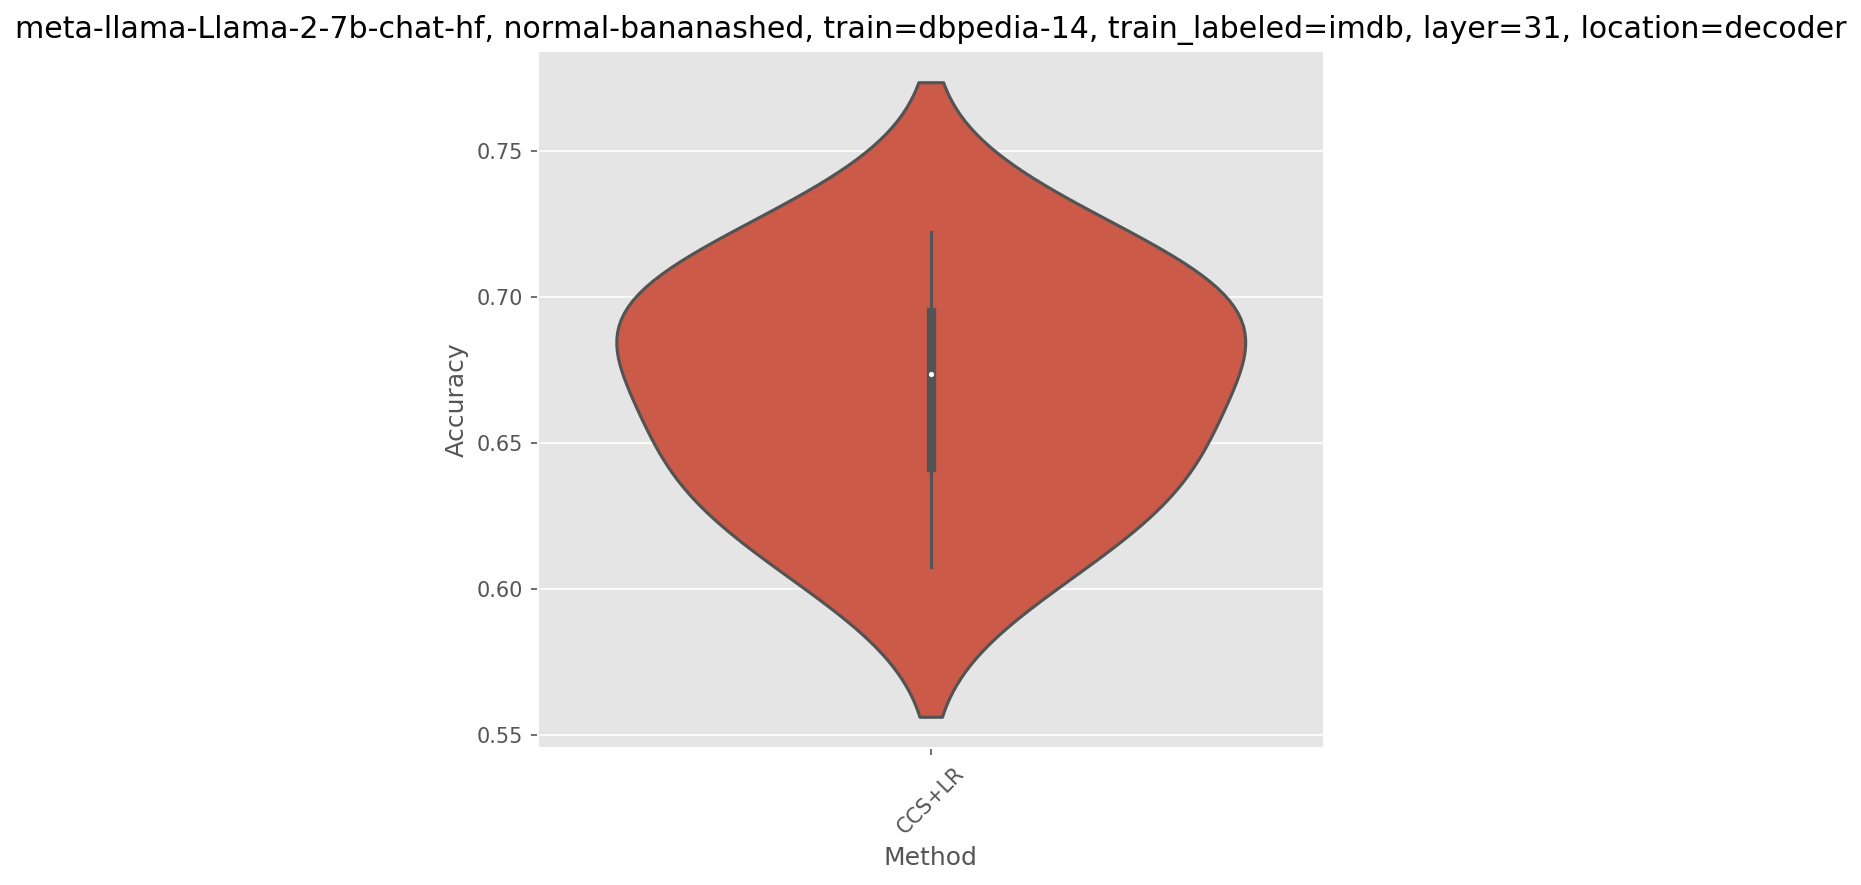

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-3-n_epochs=1000


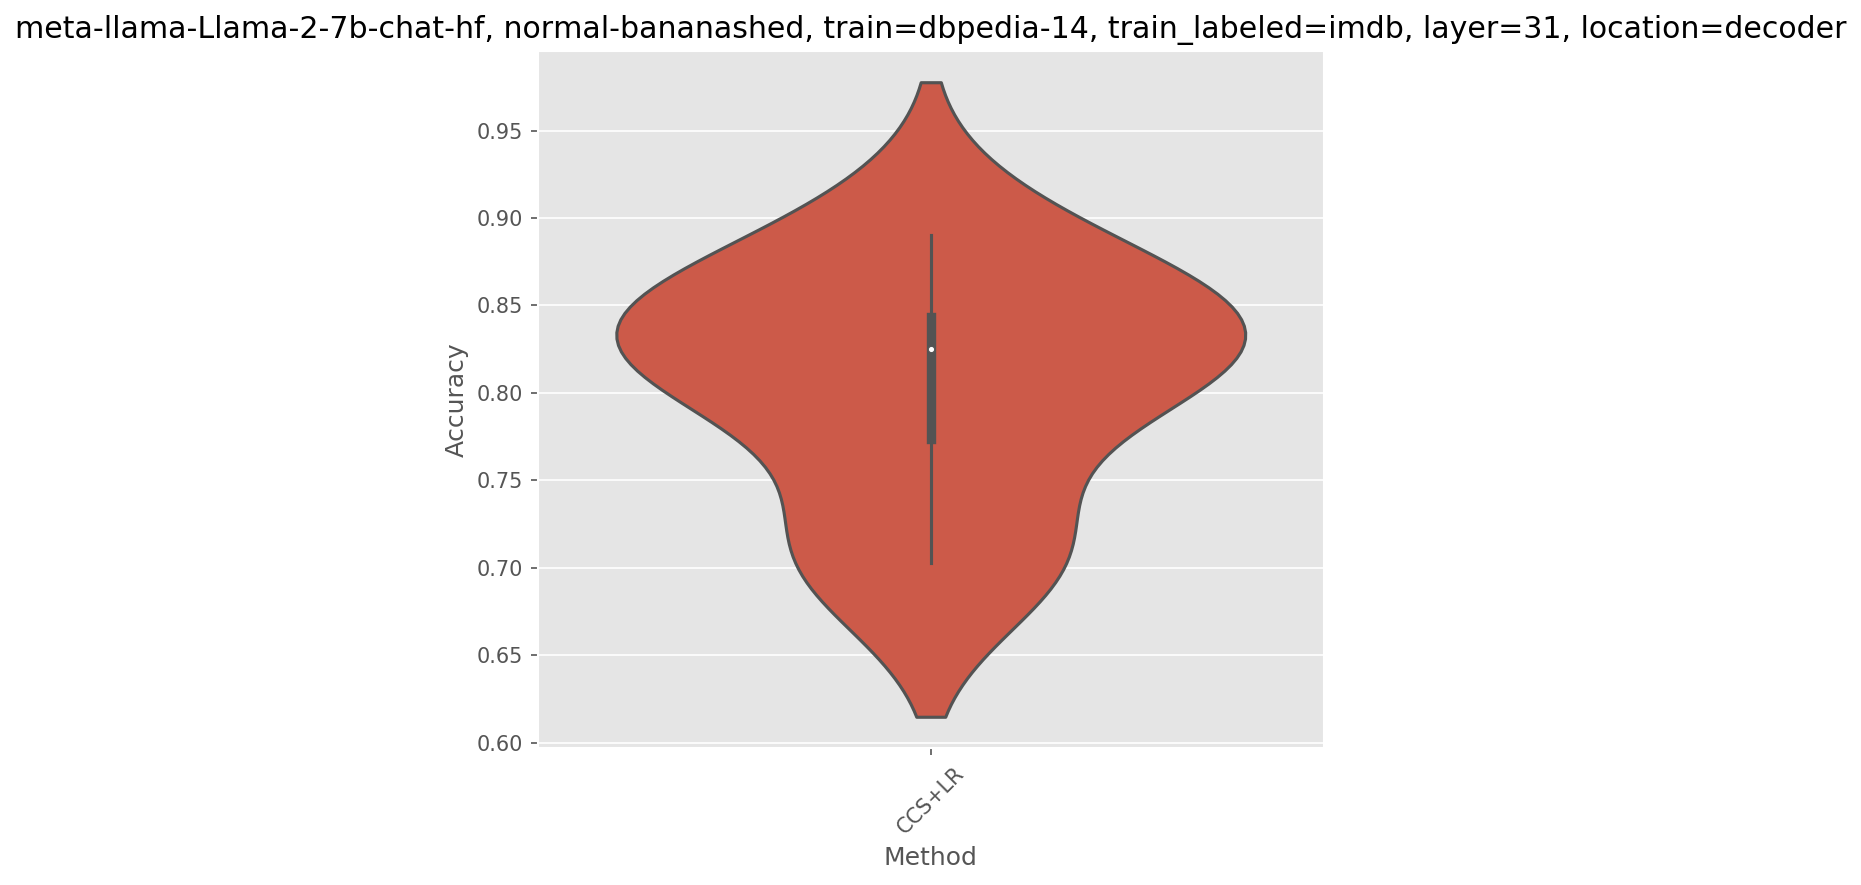

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.1-unsup_weight=1-lr=1e-2-n_epochs=1000


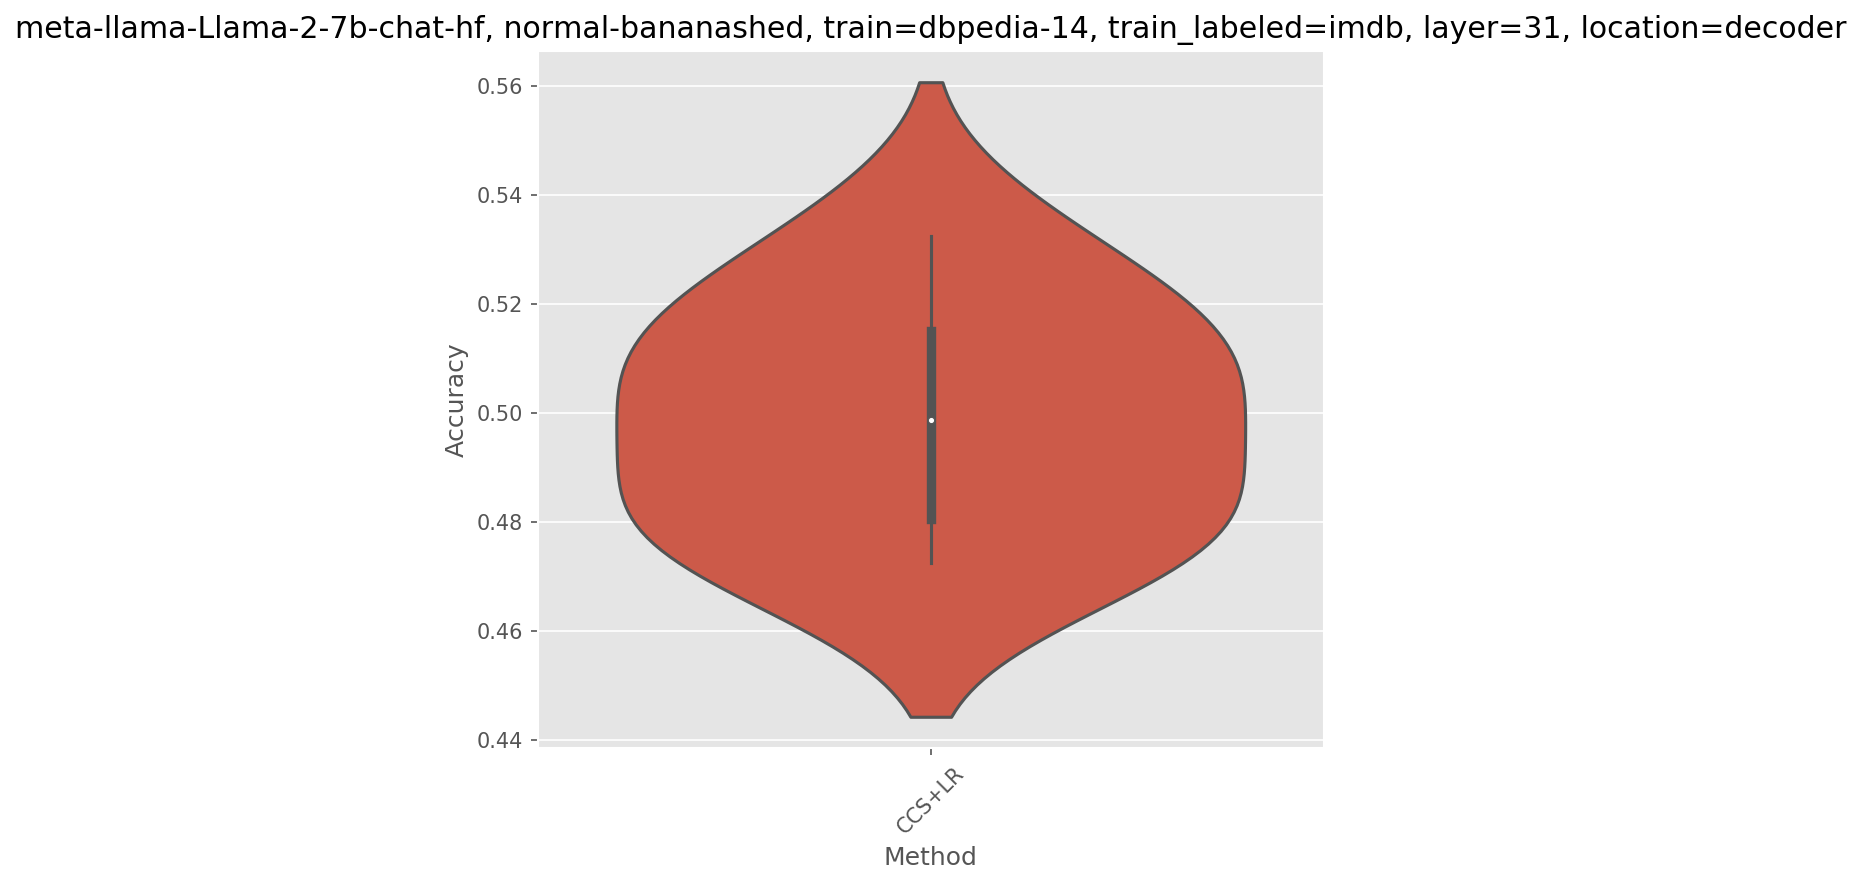

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-4-n_epochs=1000


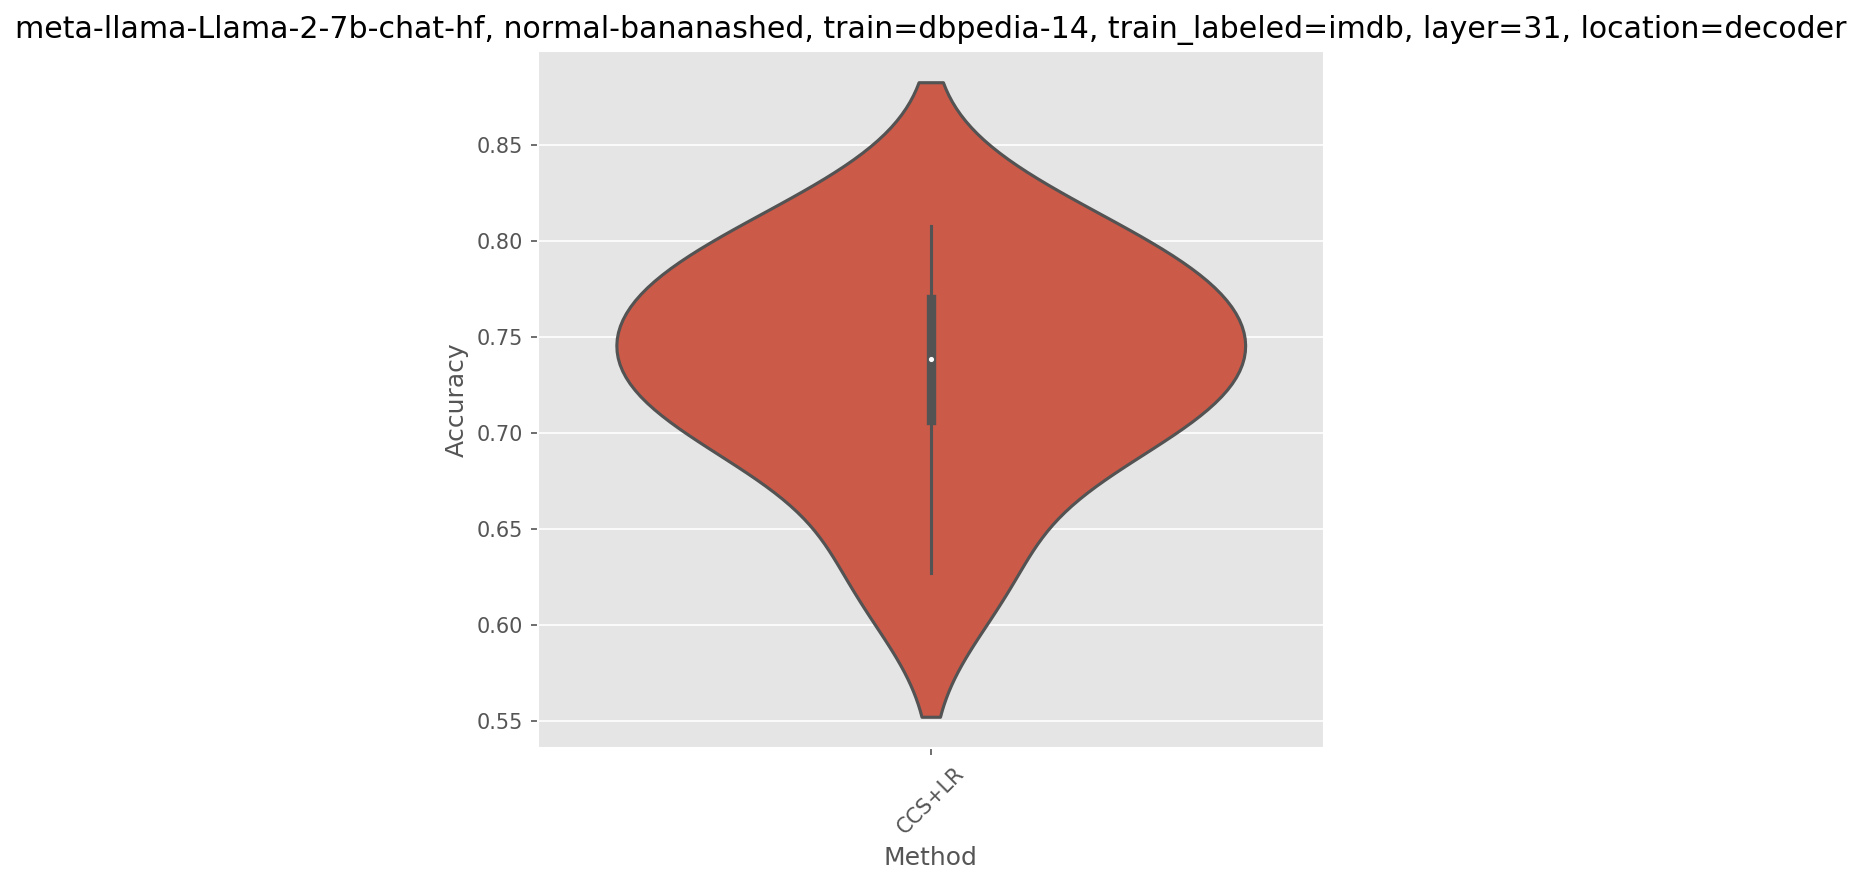

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=0.3-unsup_weight=1-lr=1e-2-n_epochs=1000


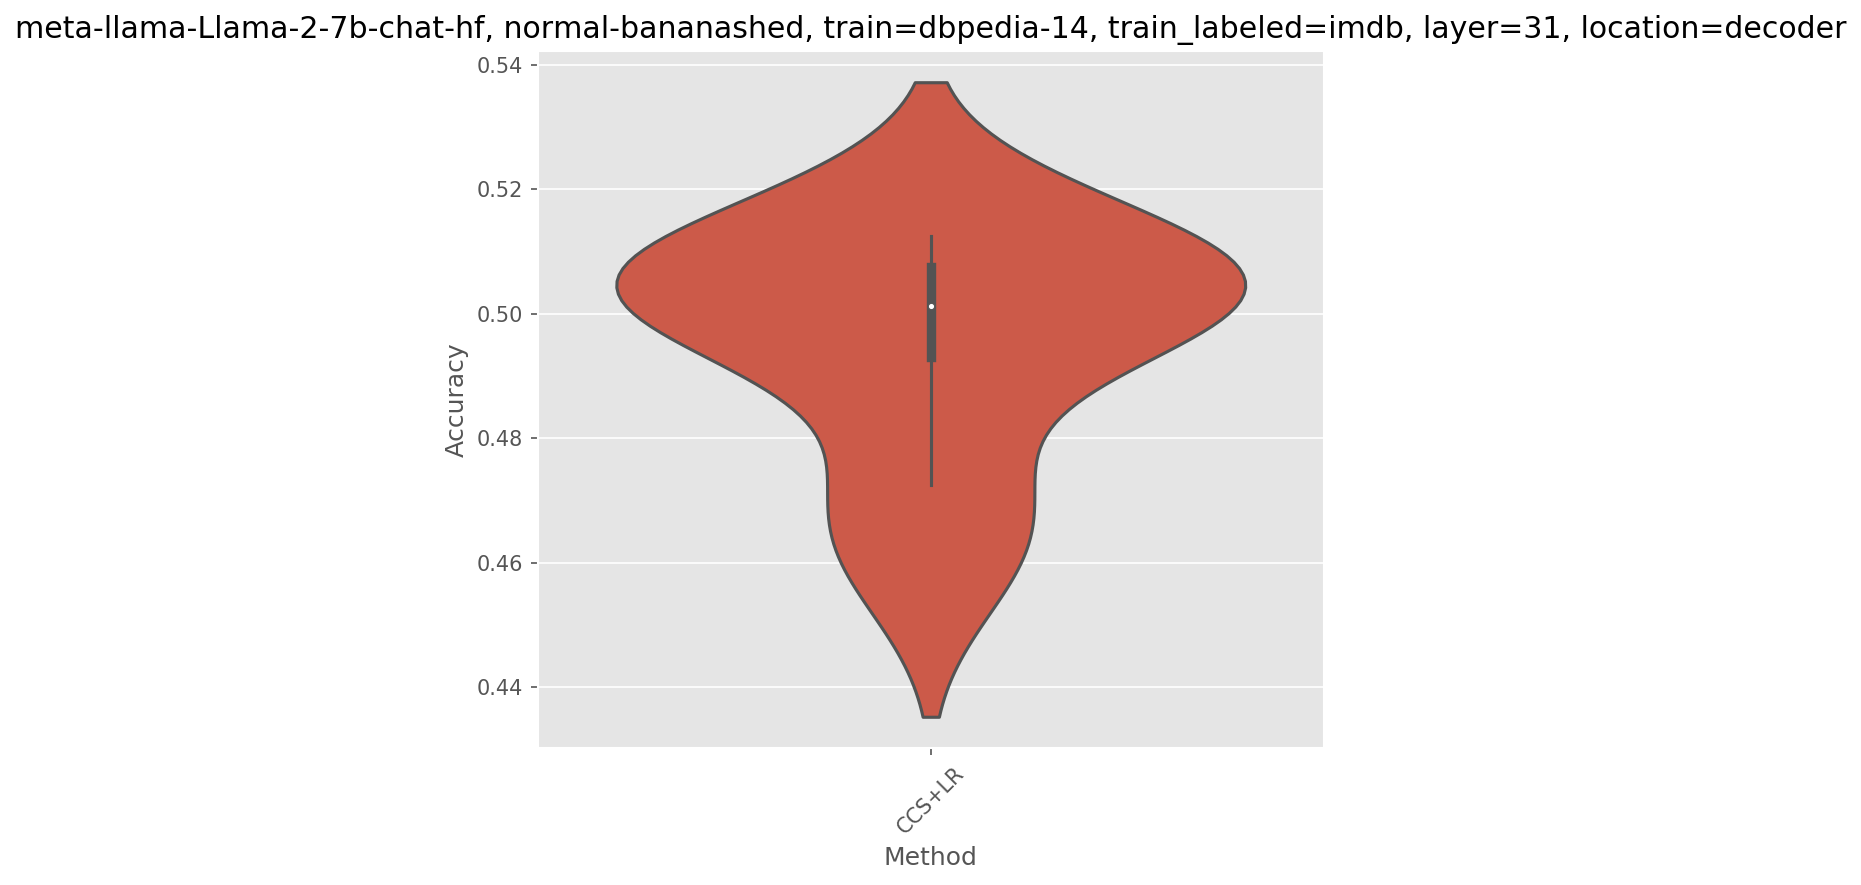

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=10-unsup_weight=1-lr=1e-4-n_epochs=1000


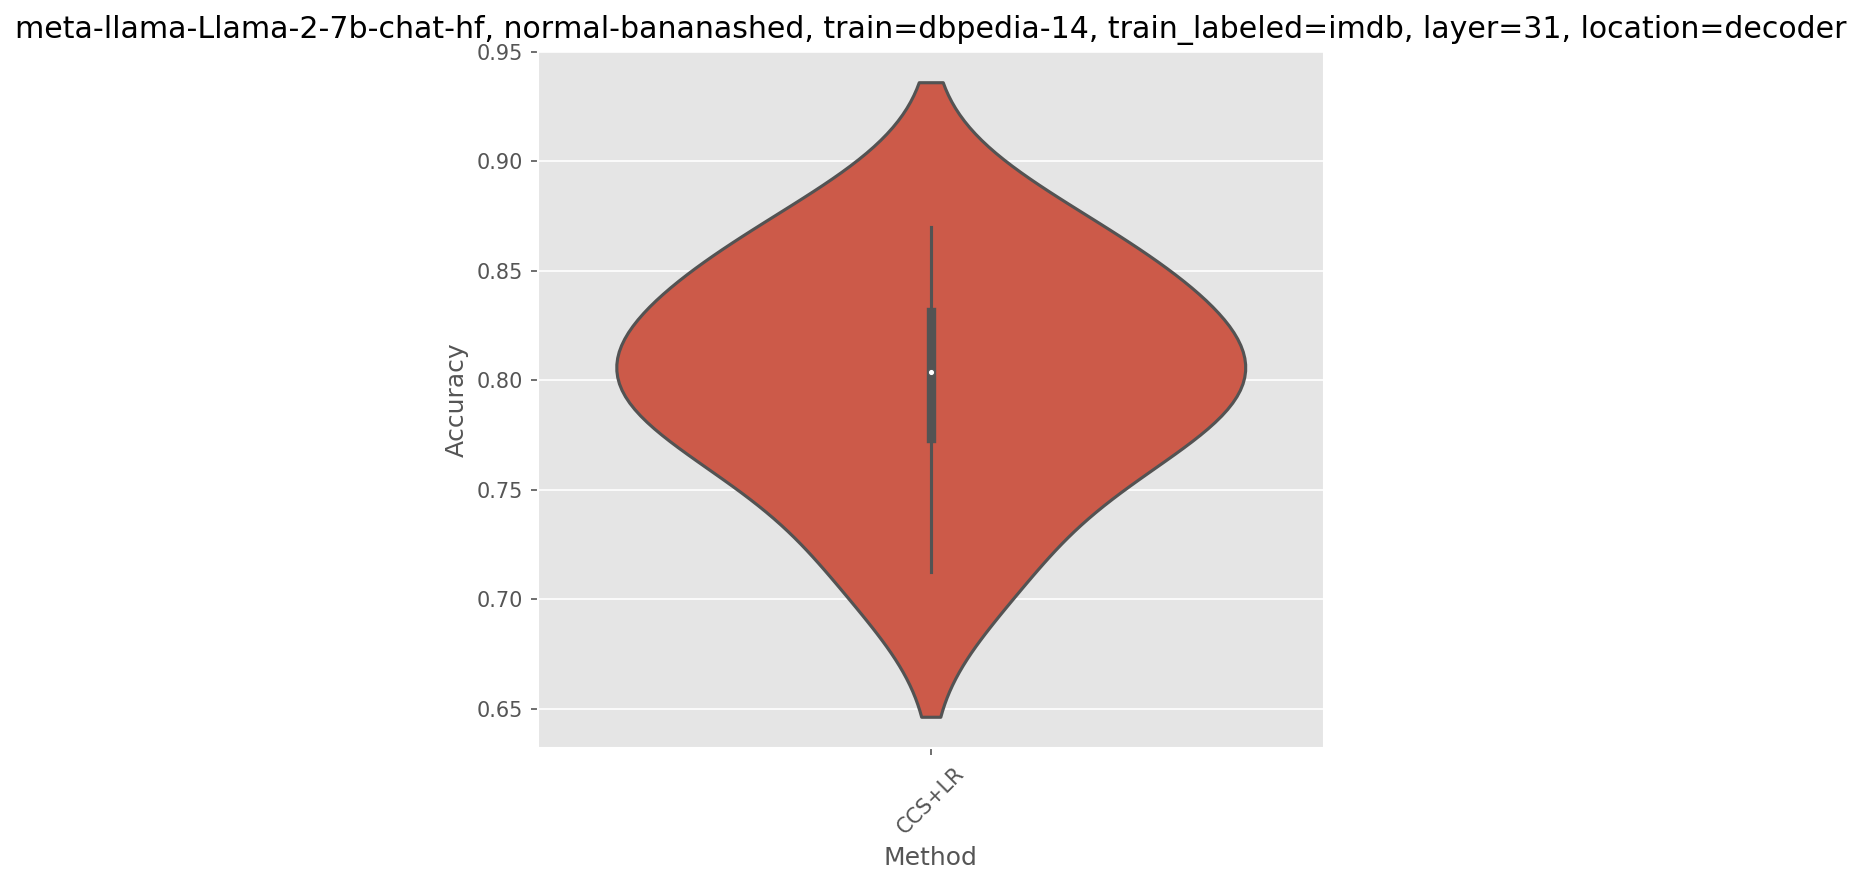

Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=1-unsup_weight=1-lr=1e-3-n_epochs=1000


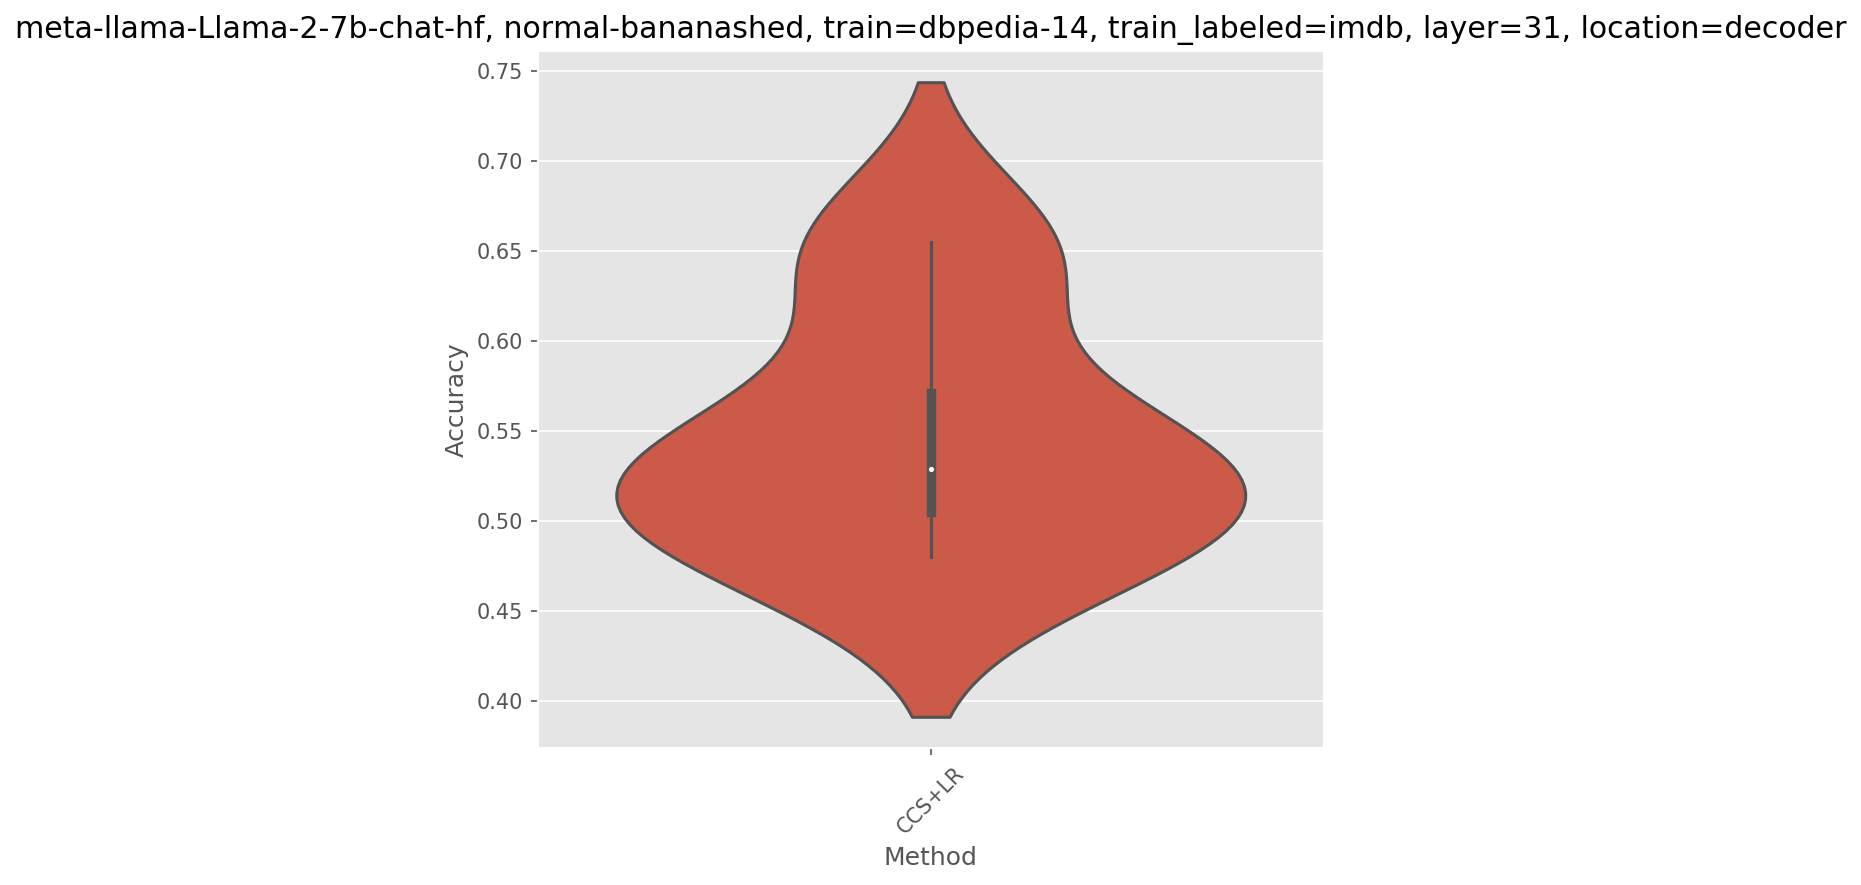

In [149]:
for exp_name, df in experiment_dfs.items():
    print(exp_name)
    plot_violin(df)

# Training curves

In [142]:
import json

path = "/scratch/users/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep/sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/1/train/fit_result_CCS+LR.json"

with open(path, "r") as f:
    fit_result = json.load(f)

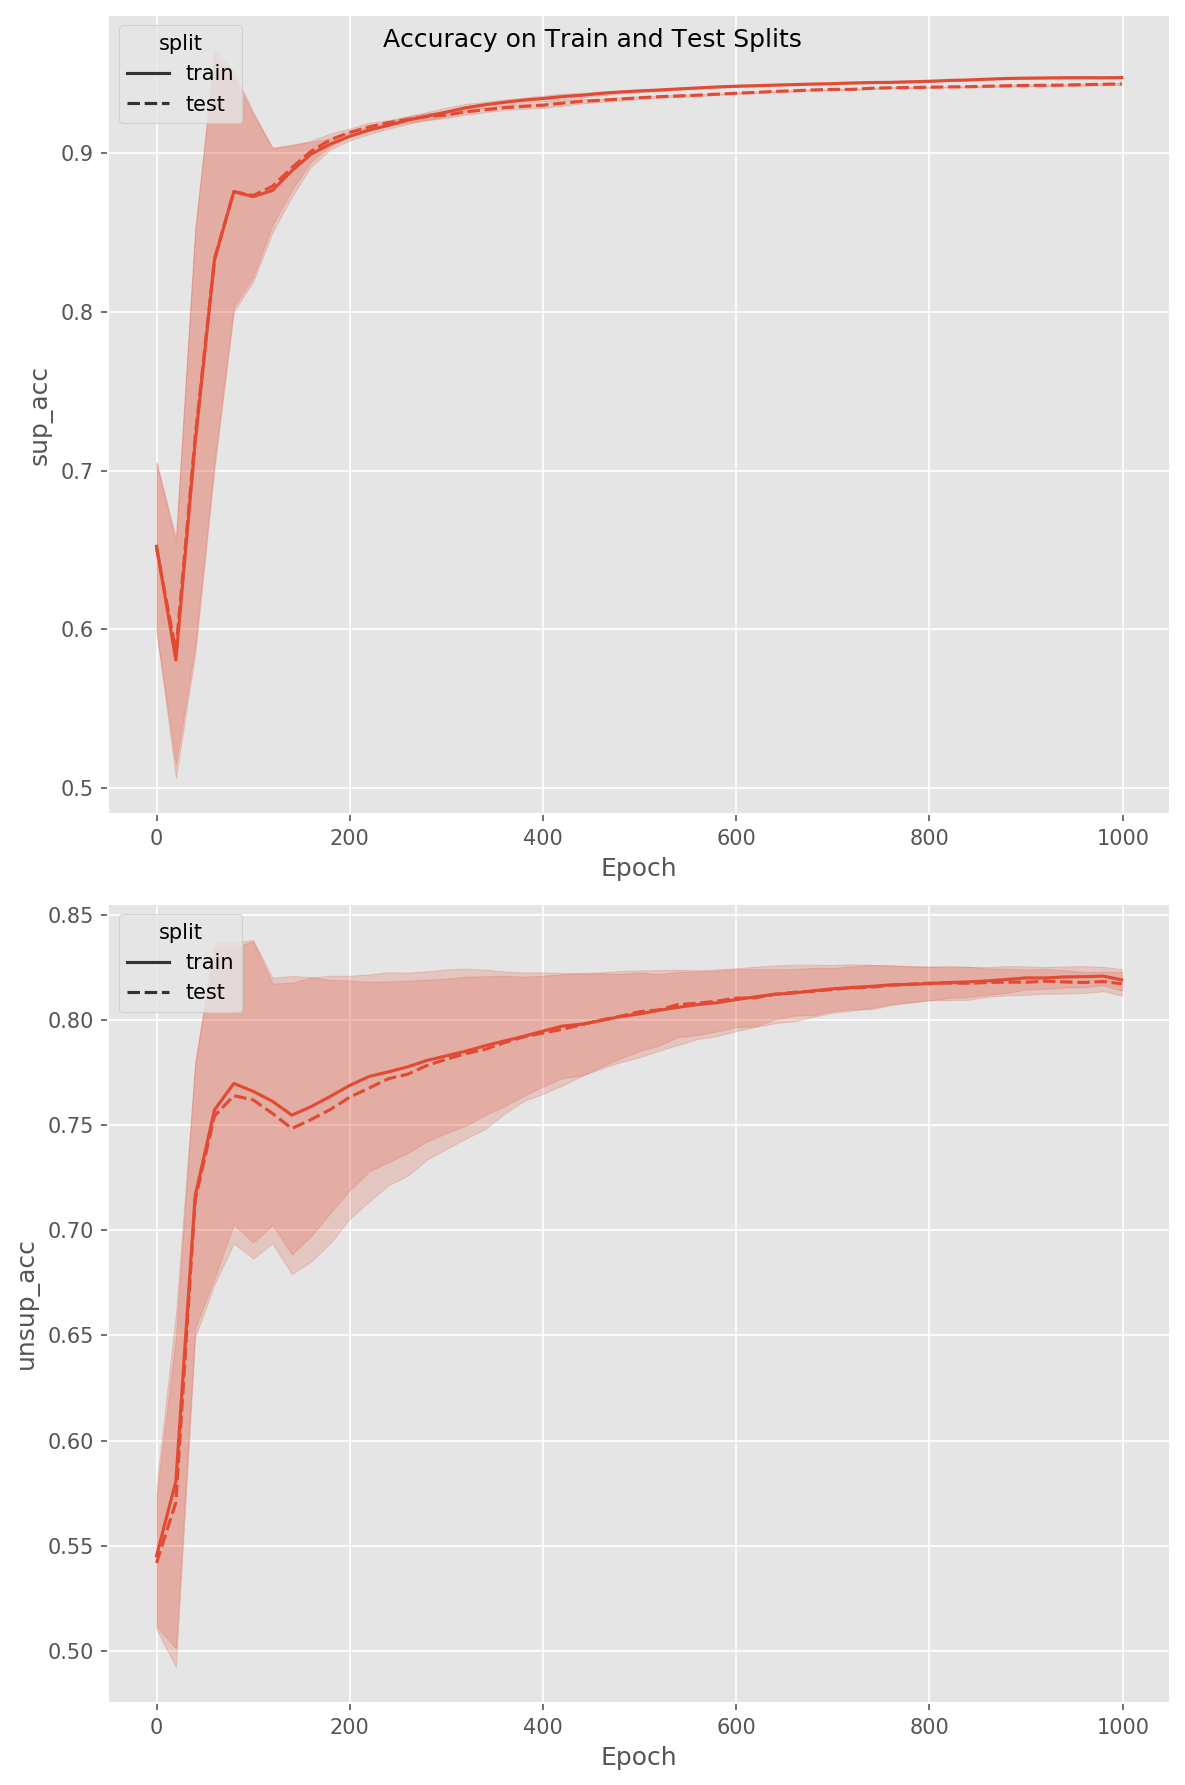

In [143]:
plot_df = plot_utils.plot_accuracy(fit_result)

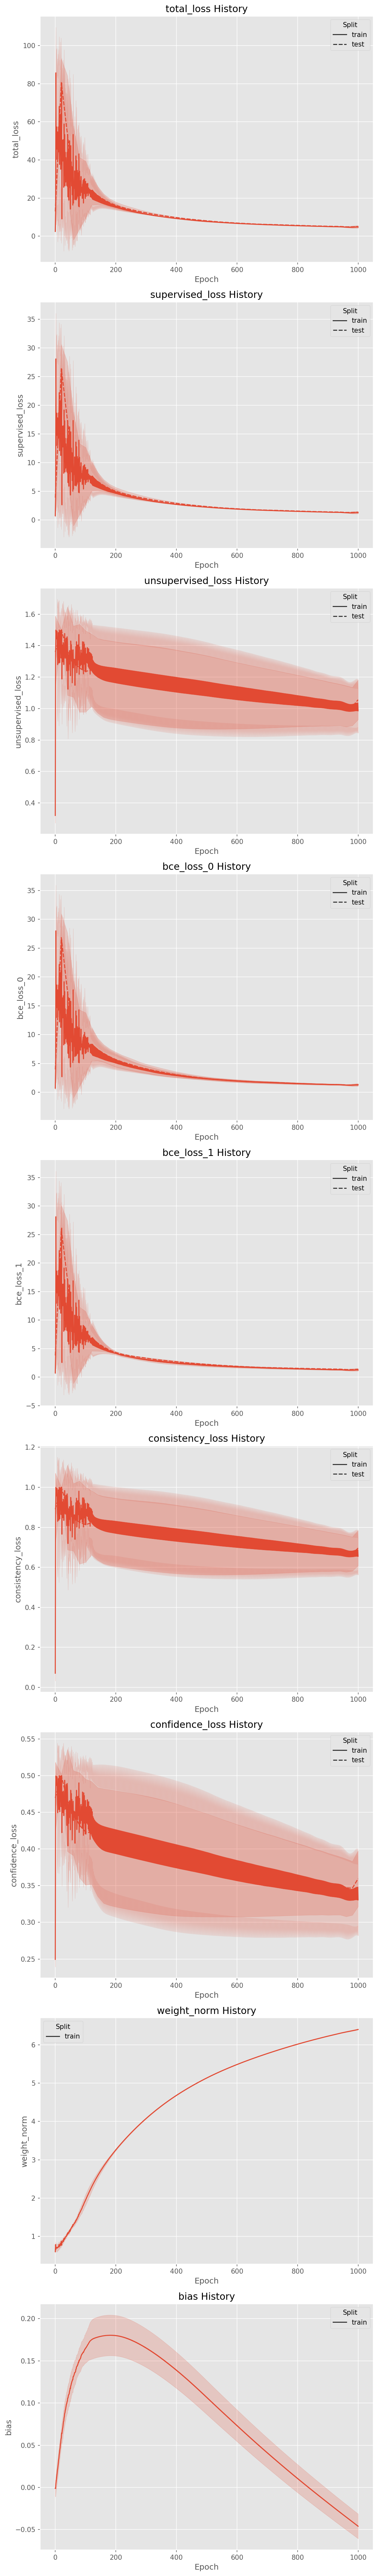

In [144]:
plot_utils.plot_history(fit_result)

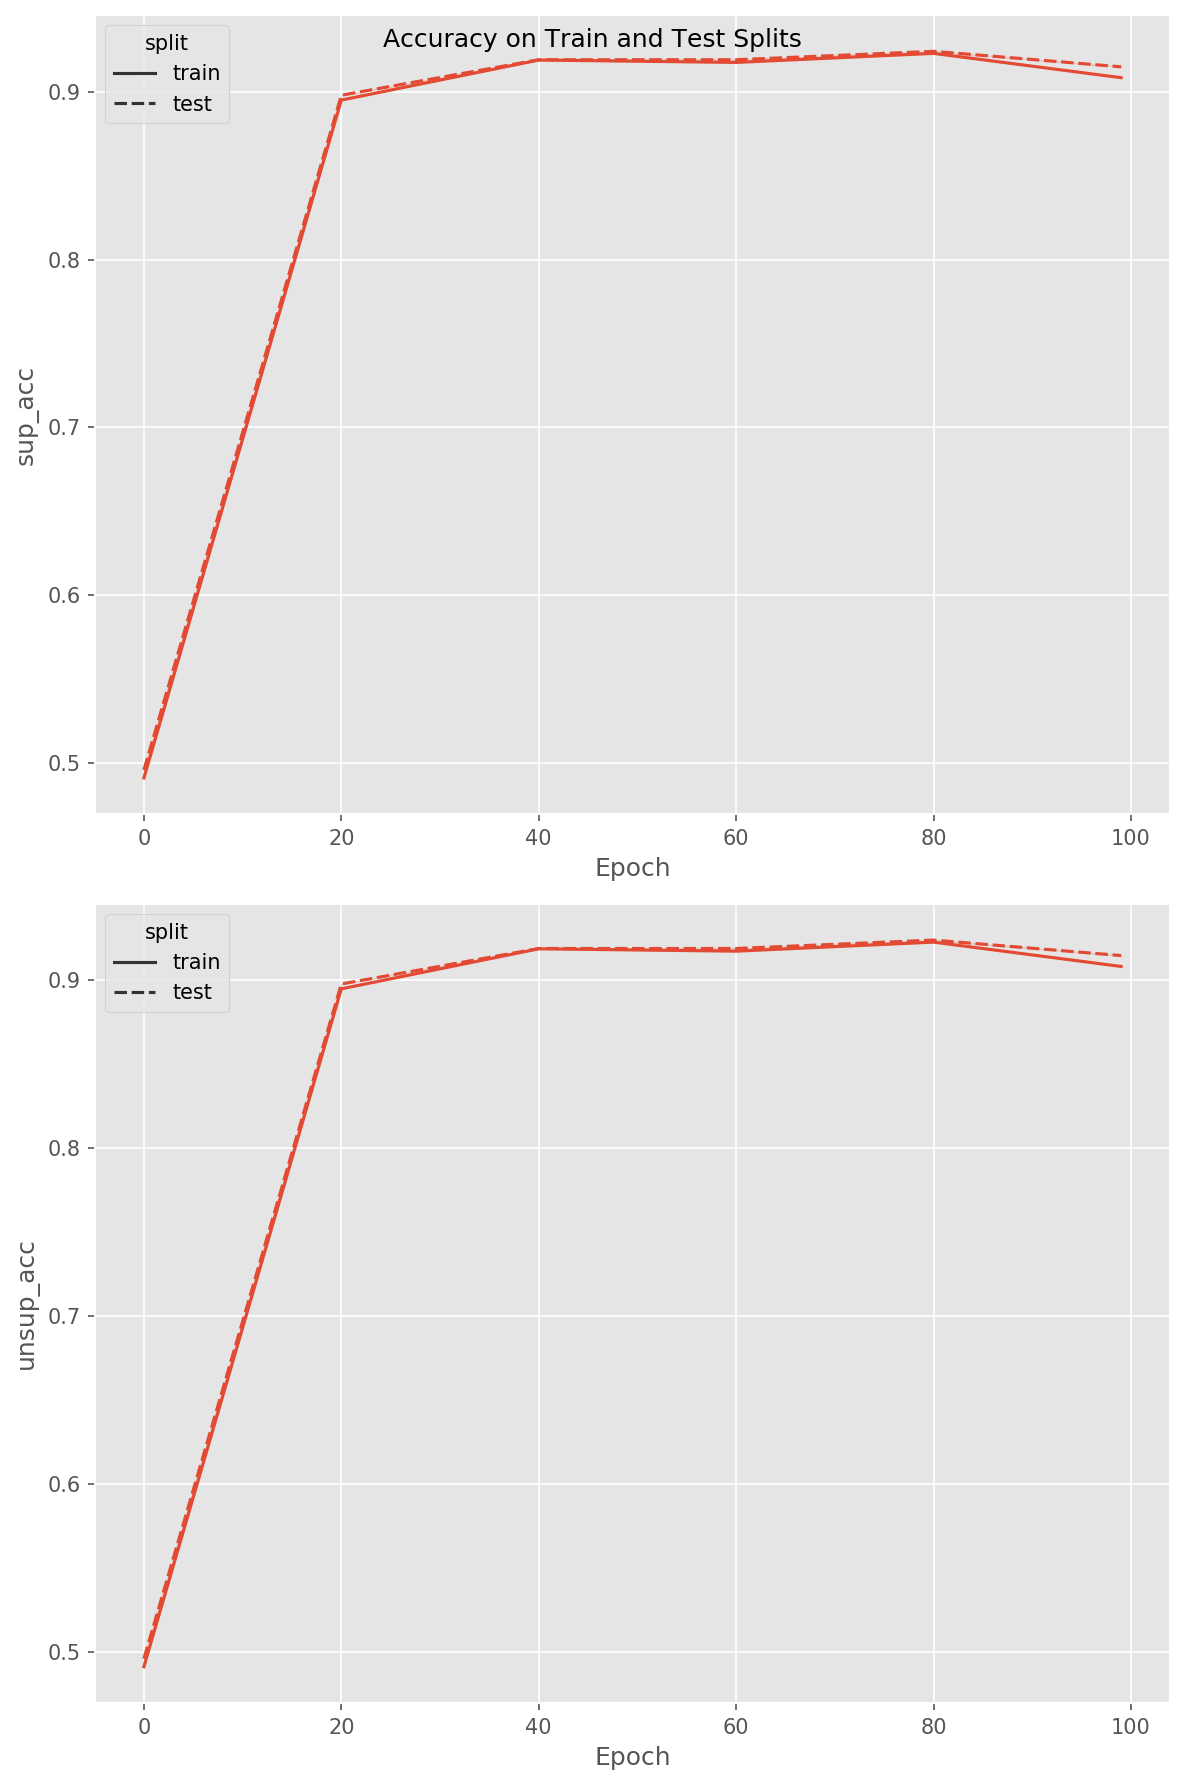

In [77]:
def plot_accuracy(fit_result, save_path=None):
    eval_histories = fit_result["eval_histories"]
    data = []

    for trial, history in enumerate(eval_histories):
        epochs = history["epoch"]
        for split in ["train", "test"]:
            for acc_dataset in ["sup_acc", "unsup_acc"]:
                acc_name = f"{split}_{acc_dataset}"
                acc_list = history[acc_name]
                for epoch, acc_val in zip(epochs, acc_list):
                    data.append(
                        {
                            "trial": trial,
                            "split": split,
                            "type": acc_dataset,
                            "epoch": epoch,
                            "accuracy": acc_val,
                        }
                    )
    df = pd.DataFrame(data)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(8, 12))
    for ax, acc_dataset in zip(axs, ["sup_acc", "unsup_acc"]):
        sns.lineplot(
                data=df,
                x="epoch",
                y="accuracy",
                style="split",
                ci="sd",
                markers=False,
                dashes=True,
                ax=ax,
            )
        ax.set_xlabel("Epoch")
        ax.set_ylabel(acc_dataset)

    fig.suptitle("Accuracy on Train and Test Splits")
    plt.tight_layout()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()


plot_accuracy(fit_result)

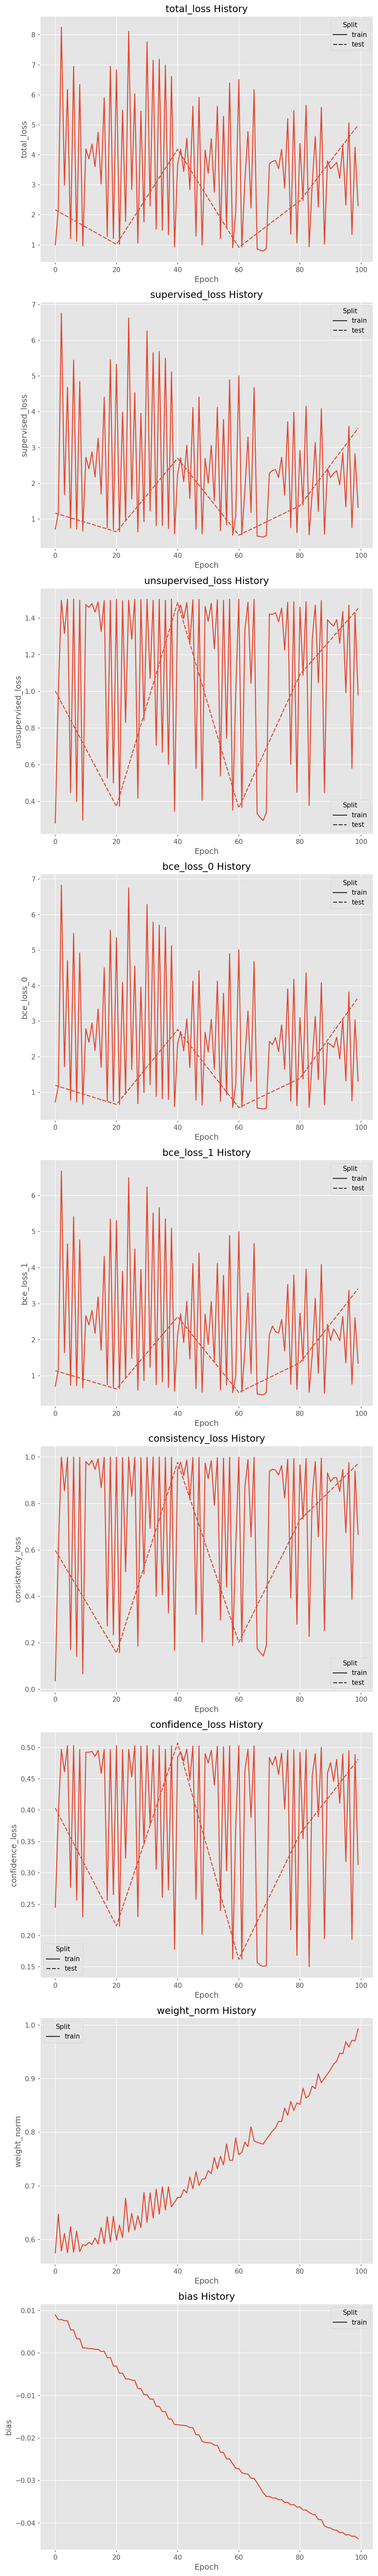

In [74]:
def plot_history(
    fit_result, vars_to_plot=None, one_fig=False, save_path=None, logger=None
):
    if not fit_result["train_histories"] and logger is not None:
        logger.info("No train_histories found in fit_result")

    if vars_to_plot is None:
        vars_to_plot = fit_result["train_histories"][0].keys()
    else:
        if not all(
            var_name in fit_result["train_histories"][0]
            for var_name in vars_to_plot
        ):
            raise ValueError(
                f"vars_to_plot contains unknown variable names: {vars_to_plot}"
            )

    # Prepare the data for plotting
    data = []
    for var_name in vars_to_plot:
        for split, histories in zip(
            ["train", "test"],
            [fit_result["train_histories"], fit_result["eval_histories"]],
        ):
            for trial, history in enumerate(histories):
                var_history = history.get(var_name, [])
                if "epoch" in history:
                    epochs = history["epoch"]
                else:
                    epochs = range(len(var_history))
                for epoch, value in zip(epochs, var_history):
                    data.append(
                        {
                            "Epoch": epoch,
                            "Value": value,
                            "Type": var_name,
                            "Trial": trial,
                            "Split": split,
                        }
                    )

    df = pd.DataFrame(data)

    # Plot
    nrows = 1 if one_fig else len(vars_to_plot)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows * 6))

    if one_fig:
        sns.lineplot(
            data=df,
            x="Epoch",
            y="Value",
            hue="Type",
            style="Split",
            ci="sd",
            markers=False,
            dashes=True,
            ax=axs,
        )
        axs.set_title("History with Confidence Interval")
        axs.set_xlabel("Epoch")
        axs.legend(title="Value")
    else:
        if nrows == 1:
            axs = [axs]

        for ax, var_name in zip(axs, vars_to_plot):
            sns.lineplot(
                data=df[df["Type"] == var_name],
                x="Epoch",
                y="Value",
                style="Split",
                ci="sd",
                markers=False,
                dashes=True,
                ax=ax,
            )
            ax.set_title(f"{var_name} History")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(var_name)

    plt.tight_layout()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

    return df


plot_df = plot_history(
    fit_result,
    # vars_to_plot=["total_loss", "supervised_loss"],
    one_fig=False,
)

In [55]:
plot_df

Epoch     Value             Type  Trial  Split
0        0  0.721262       total_loss      0  train
1        1  0.741357       total_loss      0  train
2        2  1.159783       total_loss      0  train
3        3  2.888847       total_loss      0  train
4        4  2.161690       total_loss      0  train
..     ...       ...              ...    ...    ...
207     20  2.314981  supervised_loss      0   test
208     40  2.076926  supervised_loss      0   test
209     60  1.893125  supervised_loss      0   test
210     80  1.738899  supervised_loss      0   test
211     99  1.618677  supervised_loss      0   test

[212 rows x 5 columns]

In [56]:
plot_df.query("Type == 'total_loss' and Split == 'test'")

Epoch     Value        Type  Trial Split
100      0  0.740589  total_loss      0  test
101     20  2.314981  total_loss      0  test
102     40  2.076926  total_loss      0  test
103     60  1.893125  total_loss      0  test
104     80  1.738899  total_loss      0  test
105     99  1.618677  total_loss      0  test

In [59]:
plot_df

Epoch     Value             Type  Trial  Split
0        0  0.721262       total_loss      0  train
1        1  0.741357       total_loss      0  train
2        2  1.159783       total_loss      0  train
3        3  2.888847       total_loss      0  train
4        4  2.161690       total_loss      0  train
..     ...       ...              ...    ...    ...
207     20  2.314981  supervised_loss      0   test
208     40  2.076926  supervised_loss      0   test
209     60  1.893125  supervised_loss      0   test
210     80  1.738899  supervised_loss      0   test
211     99  1.618677  supervised_loss      0   test

[212 rows x 5 columns]

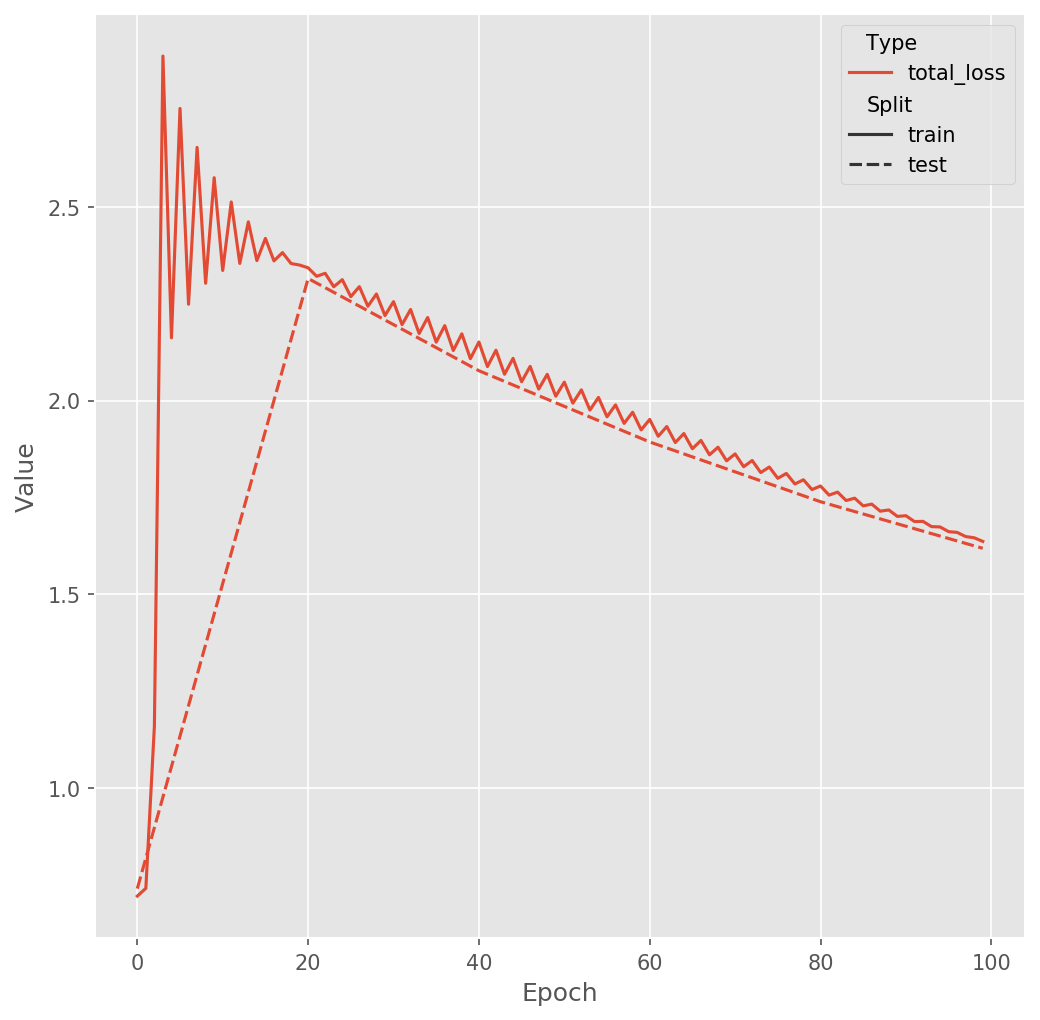

In [66]:
sns.lineplot(
    data=plot_df.query("Type == 'total_loss'"),
    x="Epoch",
    y="Value",
    hue="Type",
    style="Split",
    ci="sd",
    markers=False,
    dashes=True,
)

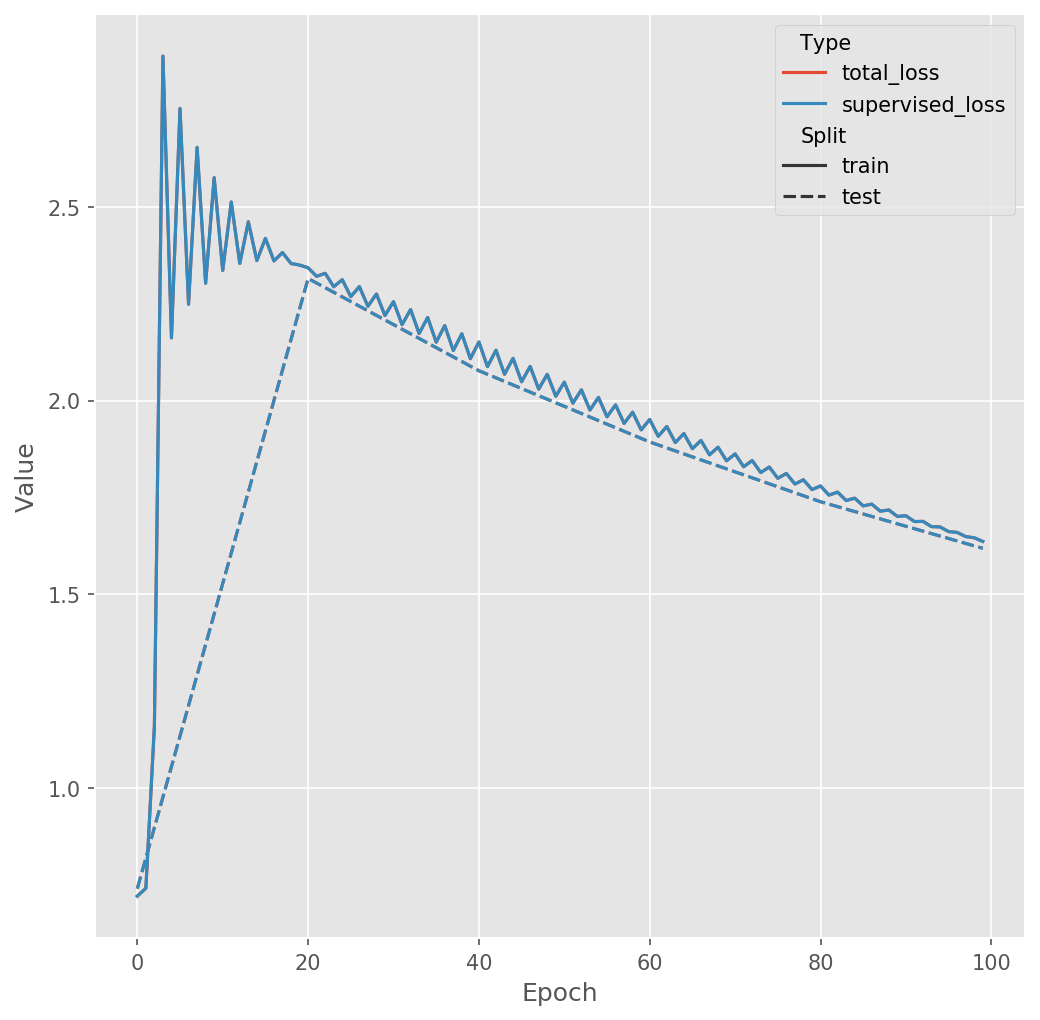

In [65]:
sns.lineplot(
    data=plot_df,
    x="Epoch",
    y="Value",
    hue="Type",
    style="Split",
    ci="sd",
    markers=False,
    dashes=True,
)

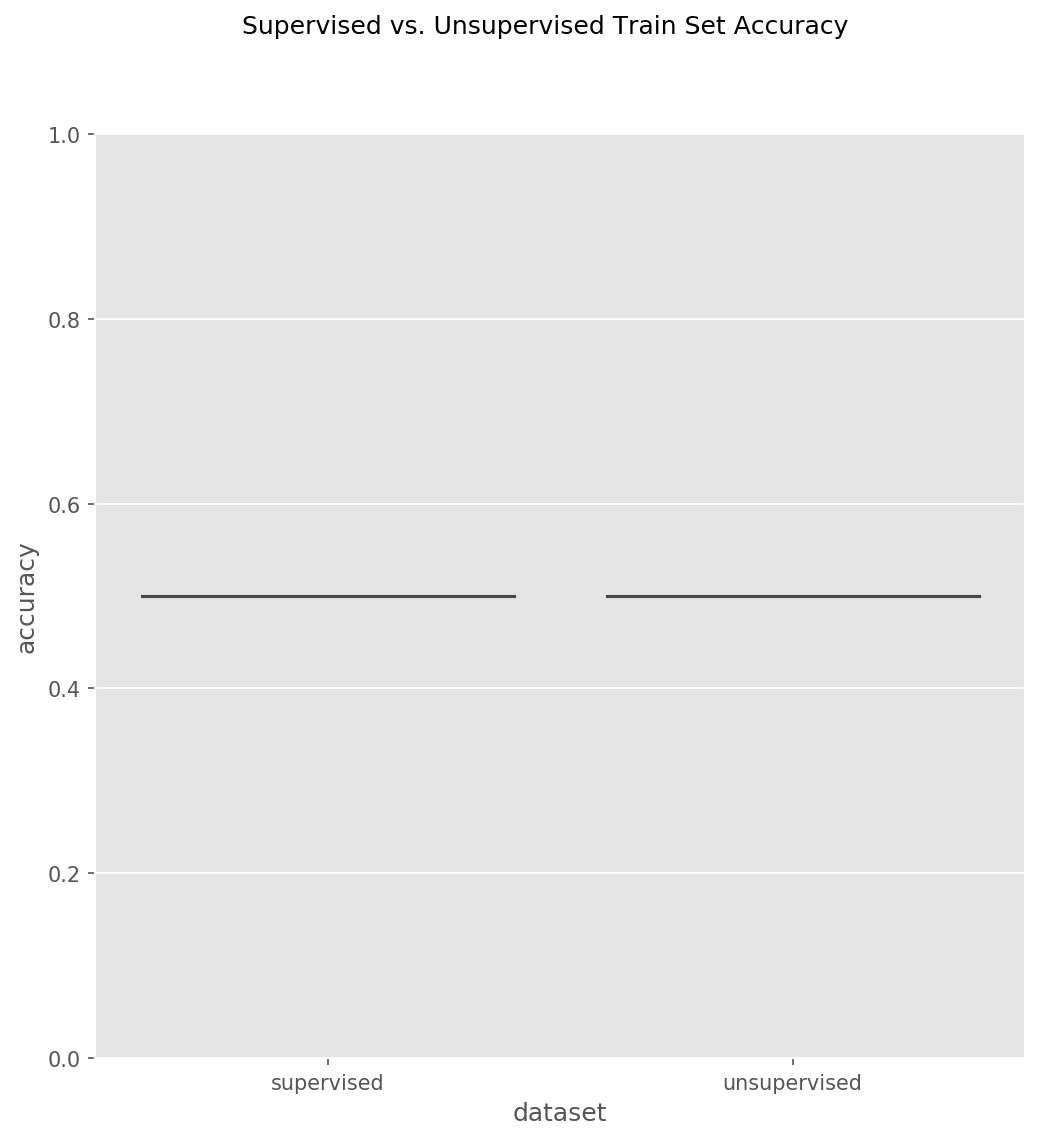

In [31]:
plot_utils.plot_accuracy(fit_result)

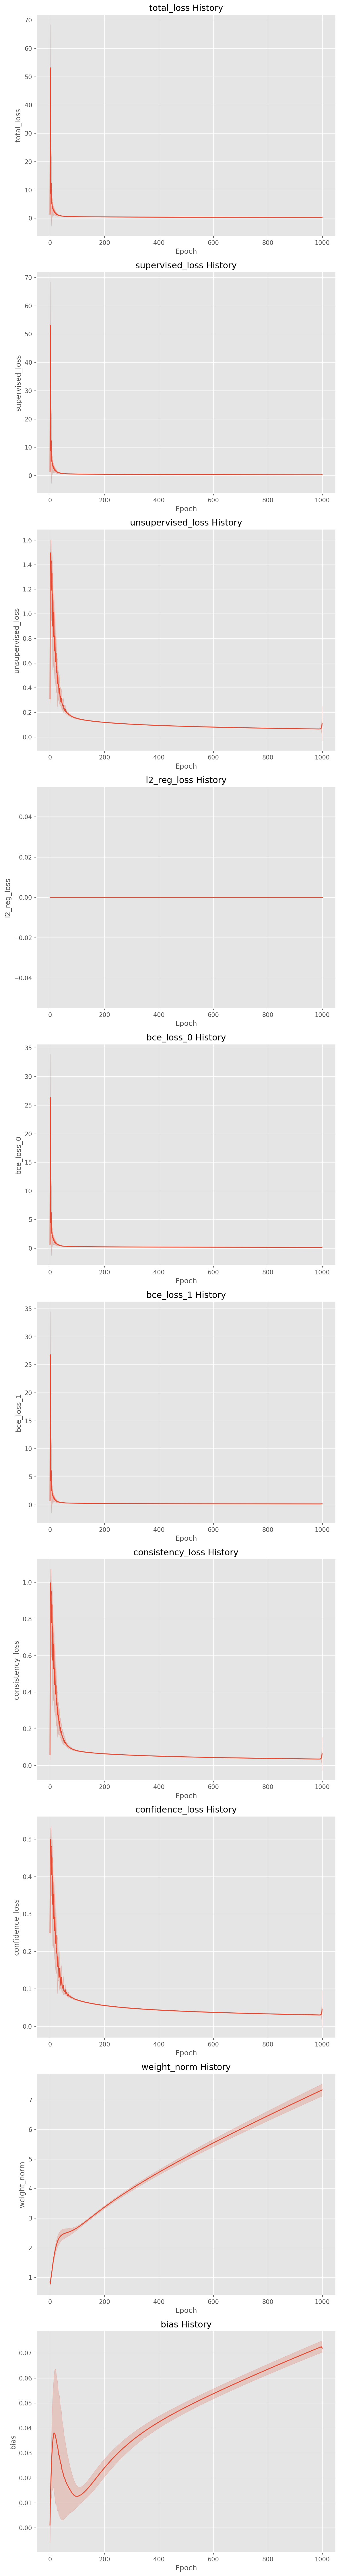

In [14]:
plot_utils.plot_history(fit_result, one_fig=False)

# ECE

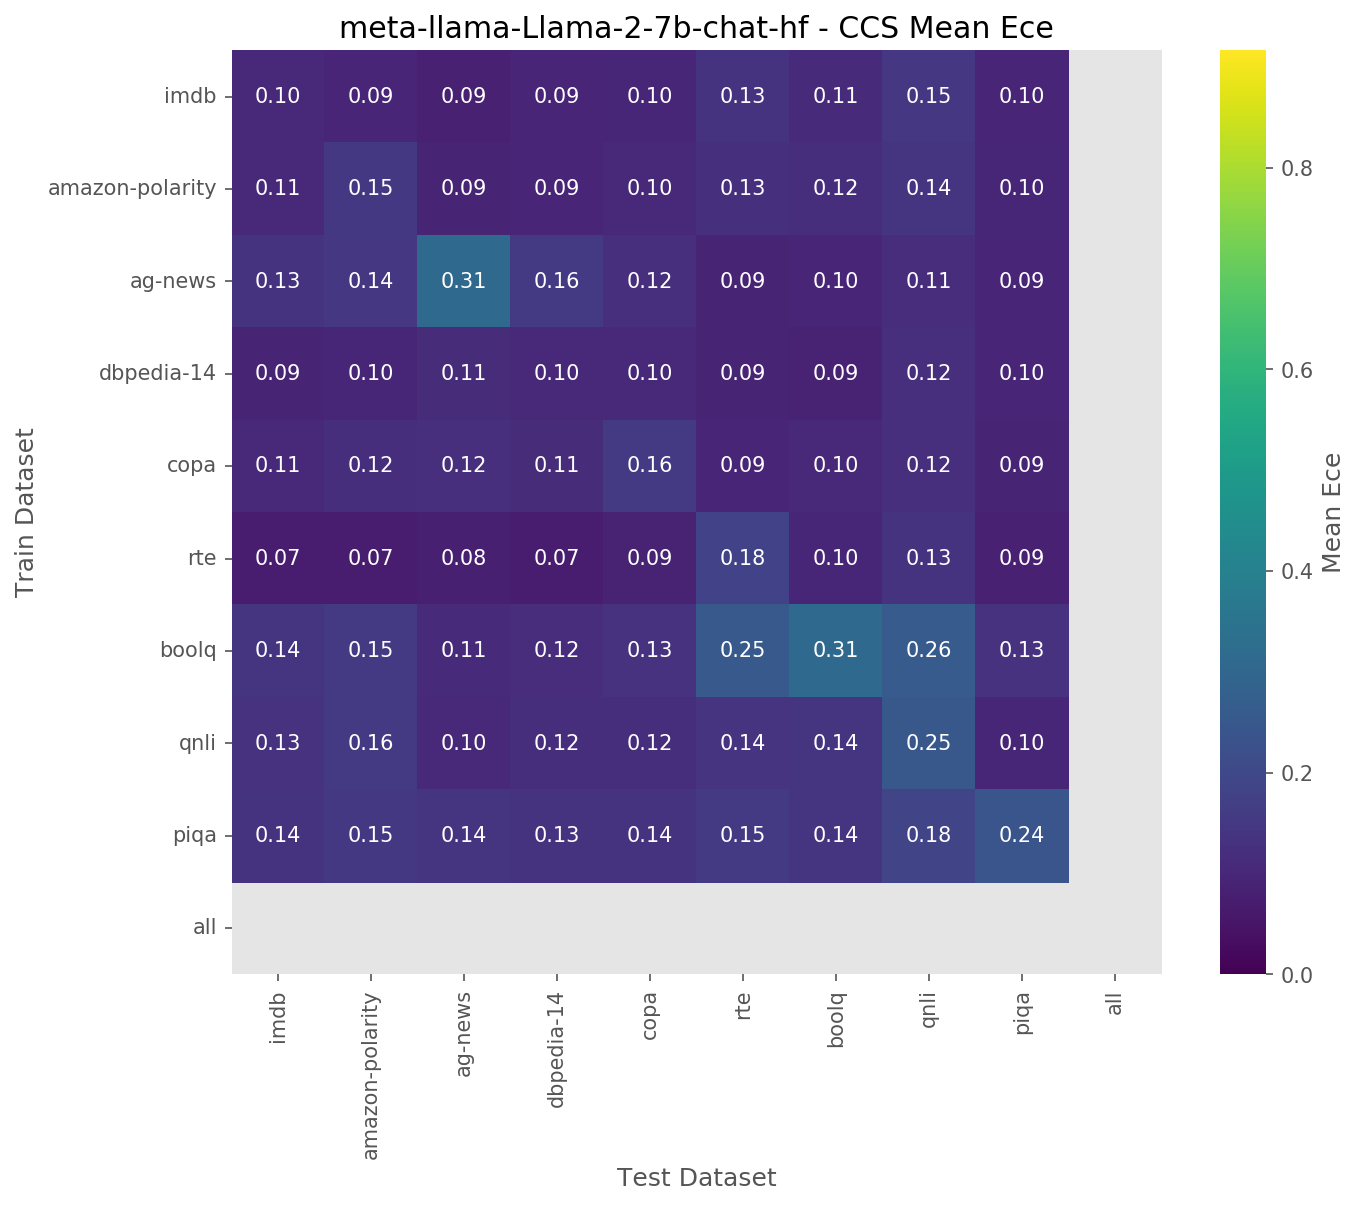

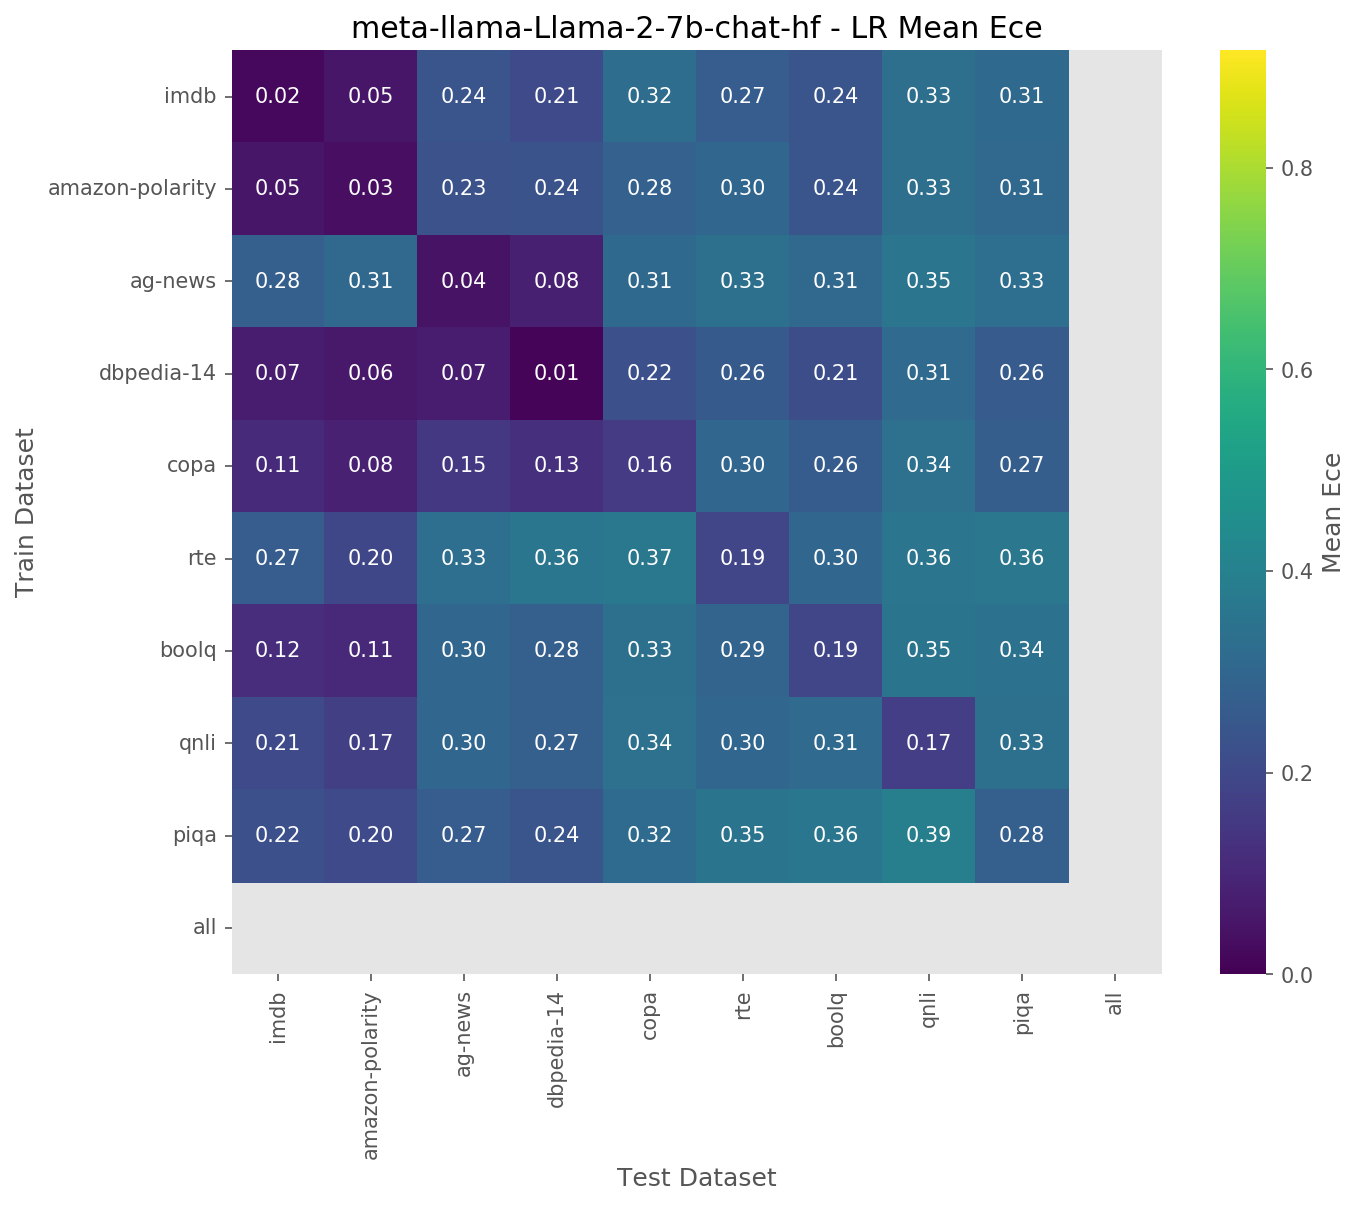

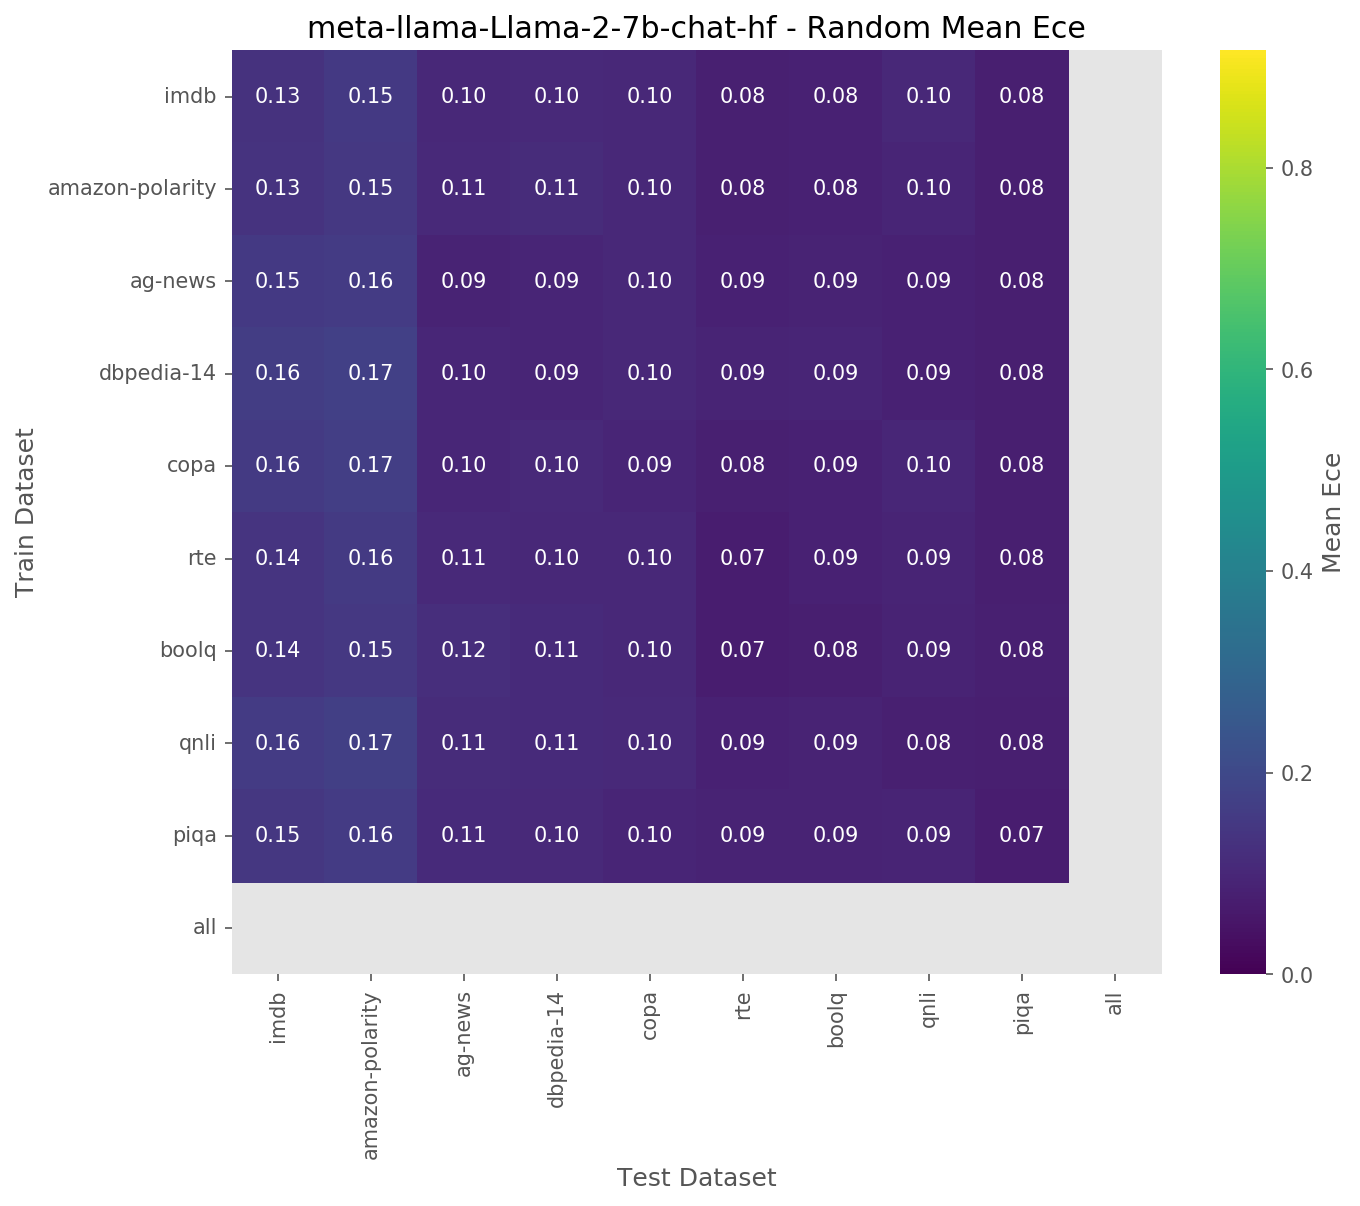

In [11]:
min_ece = df.ece.min()
max_ece = df.ece.max()
heatmap_kwargs = {"vmin": min_ece, "vmax": max_ece}
plot_heatmap(df, "ece", std_annot=False, heatmap_kwargs=heatmap_kwargs)

# Calibration curves

In [12]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_v3"
ece_df = make_ece_df(save_dir, experiment_name)

In [13]:
ece_df

Empty DataFrame
Columns: [model, method, train, test, prompt, seed, run_id, acc, ece, bin_mean_probs, bin_mean_labels, flip_probs]
Index: []

In [14]:
sample_ece_df = ece_df.query("method == 'CCS' and train == test and seed == 1 and prompt == 0")
for key, group_df in sample_ece_df.groupby(["model", "method", "train", "test", "prompt", "seed"]):
    assert len(group_df) == 2
    og_row = group_df[~group_df["flip_probs"]].iloc[0]
    flip_row = group_df[group_df["flip_probs"]].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    og_title = f"ECE={og_row.ece:.4f}"
    calibration_plot_from_bin_xy(og_row.bin_mean_probs, og_row.bin_mean_labels, og_title, ax=ax[0])

    flip_title = f"ECE={flip_row.ece:.4f}"
    calibration_plot_from_bin_xy(flip_row.bin_mean_probs, flip_row.bin_mean_labels, flip_title, ax=ax[1])

    title=f"{og_row.model} - {og_row.method} - train={og_row.train} - test={og_row.test} - prompt={og_row.prompt} - seed={og_row.seed}"
    fig.suptitle(title)